In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.7


exoplanet version: 0.2.0


# Astrometric fitting

In this tutorial we'll walk through the simplest astrometric example with `exoplanet` and then explain how to build up a more complicated example with parallax measurements. For our dataset, we'll use astrometric and radial velocity observations of a binary star system.

Astrometric observations usually consist of measurements of the separation and position angle of the secondary star (or directly imaged exoplanet), relative to the primary star as a function of time. The simplest astrometric orbit (in terms of number of parameters), describes the orbit using a semi-major axis `a_ang` measured in *arcseconds*, since the distance to the system is assumed to be unknown. We'll work through this example first, then introduce the extra constraints provided by parallax information.

## Data 
First, let's load and examine the data. We'll use the astrometric measurements of HR 466 (HD 10009) as compiled by [Pourbaix 1998](https://ui.adsabs.harvard.edu/#abs/1998A&AS..131..377P/abstract). The speckle observations are originally from [Hartkopf et al. 1996](https://ui.adsabs.harvard.edu/#abs/1996AJ....111..370H/abstract). 

In [3]:
from astropy.io import ascii
from astropy.time import Time

# grab the formatted data and do some munging
dirname = "https://gist.github.com/iancze/262aba2429cb9aee3fd5b5e1a4582d4d/raw/c5fa5bc39fec90d2cc2e736eed479099e3e598e3/"

astro_data_full = ascii.read(dirname + "astro.txt", format="csv", fill_values=[(".", '0')])

# convert UT date to JD
astro_dates = Time(astro_data_full["date"].data, format="decimalyear")

# Following the Pourbaix et al. 1998 analysis, we'll limit ourselves to the highest quality data
# since the raw collection of data outside of these ranges has some ambiguities in swapping 
# the primary and secondary star
ind = (astro_dates.value > 1975.) & (astro_dates.value < 1999.73) \
    & (~astro_data_full["rho"].mask) & (~astro_data_full["PA"].mask)

astro_data = astro_data_full[ind]

astro_yrs = astro_data["date"]
astro_dates.format = 'jd'
astro_jds = astro_dates[ind].value

Many of these measurements in this heterogeneous dataset do not have reported error measurements. For these, we assume a modest uncertainty of $1^\circ$ in position angle and $0.01^{\prime\prime}$ in separation for the sake of specifying something, but we'll include a jitter term for both of these measurements as well. The scatter in points around the final solution will be a decent guide of what the measurement uncertainties actually were.

In [4]:
import numpy as np

astro_data["rho_err"][astro_data["rho_err"].mask == True] = 0.01
astro_data["PA_err"][astro_data["PA_err"].mask == True] = 1.0

# Convert all masked frames to be raw np arrays, since theano has issues with astropy masked columns
rho_data = np.ascontiguousarray(astro_data["rho"], dtype=float) # arcsec
rho_err = np.ascontiguousarray(astro_data["rho_err"], dtype=float)

# The position angle measurements come in degrees in the range [0, 360].
# We'll convert this to radians in the range [-pi, pi]
deg = np.pi/180.
theta_data = np.ascontiguousarray(astro_data["PA"] * deg, dtype=float) 
theta_data[theta_data > np.pi] -= 2 * np.pi

theta_err = np.ascontiguousarray(astro_data["PA_err"] * deg) # radians

## Astrometric conventions

The conventions describing the orientation of the orbits are described in detail in the *exoplanet* paper; we summarize them briefly here. Generally, we follow the conventions from Pourbaix et al. 1998, which are a consistent set conforming to the right-hand-rule and the conventions of the visual binary field, where the ascending node is that where the secondary is *receeding* from the observer (without radial velocity information, there is a $\pi$ degeneracy in which node is ascending, and so common practice in the literature is to report a value in the range $[0,\pi]$). The orbital inclination ranges from $[0, \pi$]. $i = 0$ describes a face-on orbit rotating counter-clockwise on the sky plane, while $i=\pi$ describes a face-on orbit rotating clockwise on the sky. $i = \pi/2$ is an edge-on orbit. 

The observer frame $X$, $Y$, $Z$ is oriented on the sky such that $+Z$ points towards the observer, $X$ is the north axis, and $Y$ is the east axis. *All* angles are measured in radians, and the position angle is returned in the range $[-\pi, \pi]$, which is the degrees east of north (be sure to check your data is in this format too!) The radial velocity is still defined such that a positive radial velocity corresponds to motion away from the observer.

In an astrometric-only orbit, it is common practice in the field to report $\omega = \omega_\mathrm{secondary}$, whereas with an RV orbit it is generally common practice to report $\omega = \omega_\mathrm{primary}$. The result is that unless the authors specify what they're using, in a joint astrometric-RV orbit there is an ambiguity to which $\omega$ the authors mean, since $\omega_\mathrm{primary} = \omega_\mathrm{secondary} + \pi$. To standardize this across the *exoplanet* package, in all orbits (including astrometric-only) $\omega = \omega_\mathrm{primary}$.

/mnt/home/dforeman/miniconda3/envs/autoexoplanet/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


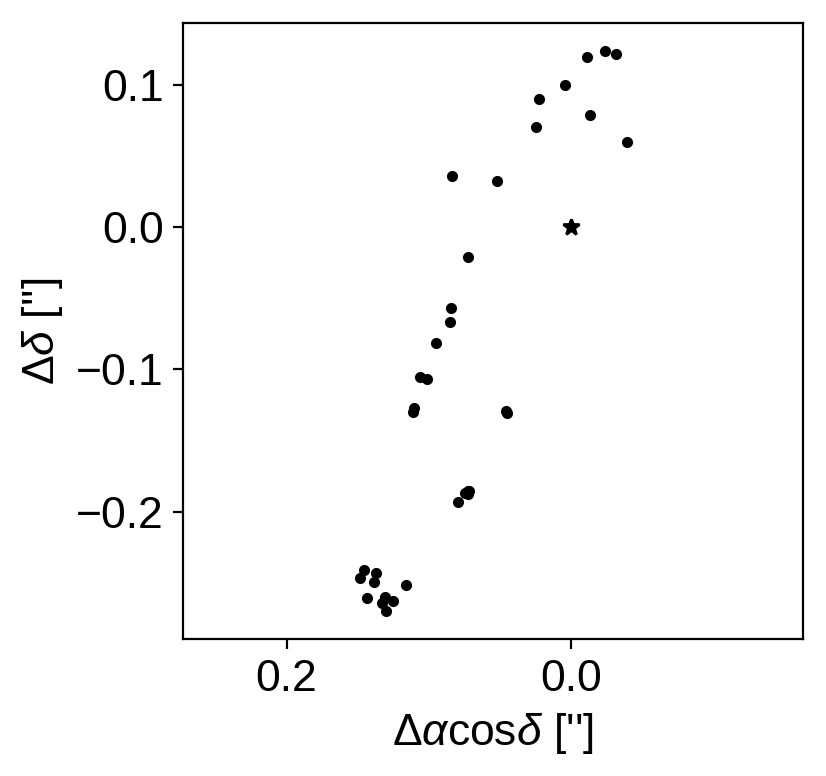

In [5]:
import matplotlib.pyplot as plt

# Make a plot of the astrometric data on the sky
# The convention is that North is up and East is left
fig, ax = plt.subplots(nrows=1, figsize=(4, 4))

xs = rho_data * np.cos(theta_data) # X is north
ys = rho_data * np.sin(theta_data) # Y is east
ax.plot(ys, xs, ".k")
ax.set_ylabel(r"$\Delta \delta$ ['']")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax.invert_xaxis()
ax.plot(0,0, "k*")
ax.set_aspect("equal", "datalim")

The plot on the sky is helpful to look at, but the "raw" measurements are the values of $\rho$ (separation) and $\theta$ (also called P.A., position angle) that we listed in our data table, and that the measurement uncertainties live on these values as nice Gaussians. So, to visualize this space more clearly, we can plot $\rho$ vs. time and P.A. vs. time.

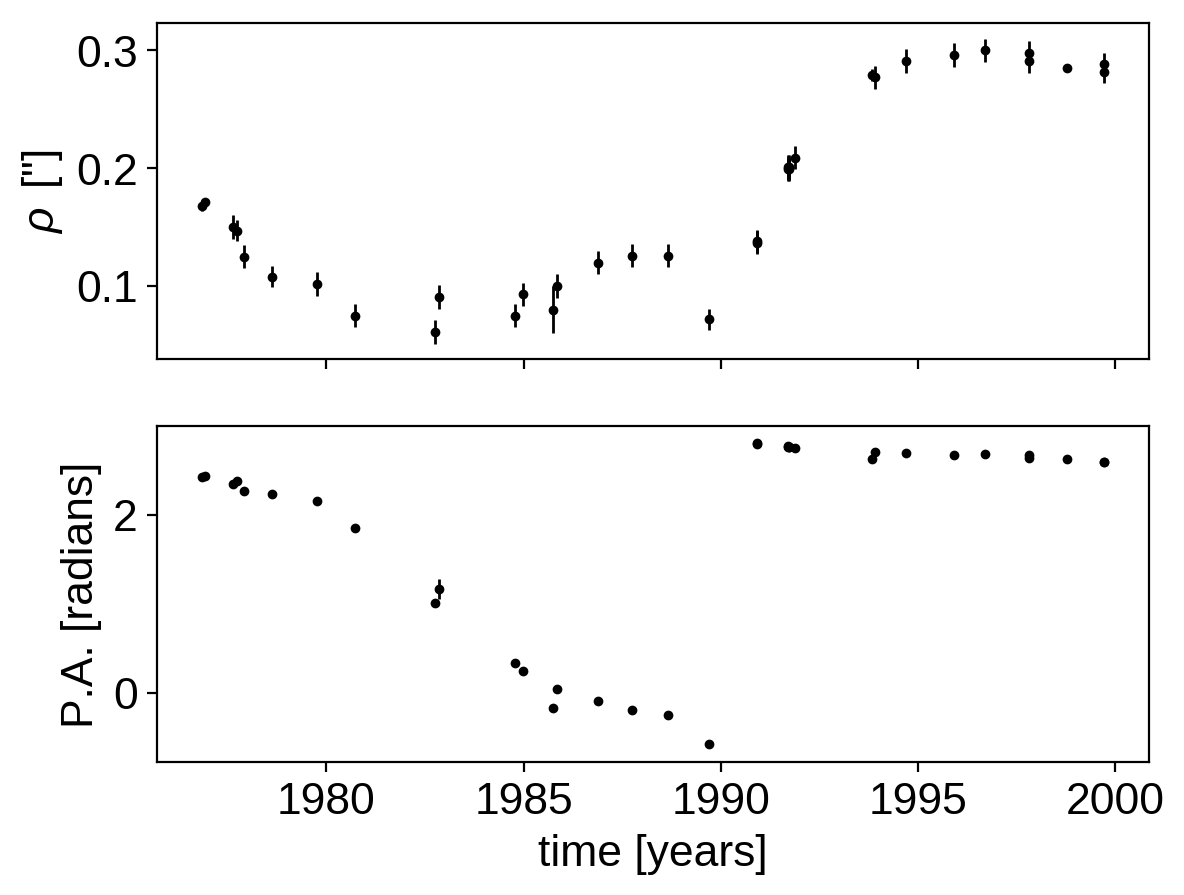

In [6]:
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].errorbar(astro_yrs, rho_data, yerr=rho_err, fmt=".k", lw=1, ms=5)
ax[0].set_ylabel(r'$\rho\,$ ["]')

ax[1].errorbar(astro_yrs, theta_data, yerr=theta_err, fmt=".k", lw=1, ms=5)
ax[1].set_ylabel(r'P.A. [radians]')
ax[1].set_xlabel("time [years]");

## Fitting the astrometric orbit with *exoplanet*

To get started, let's import the relative packages from *exoplanet*, plot up a preliminary orbit from the literature, and then sample to find the best parameters.

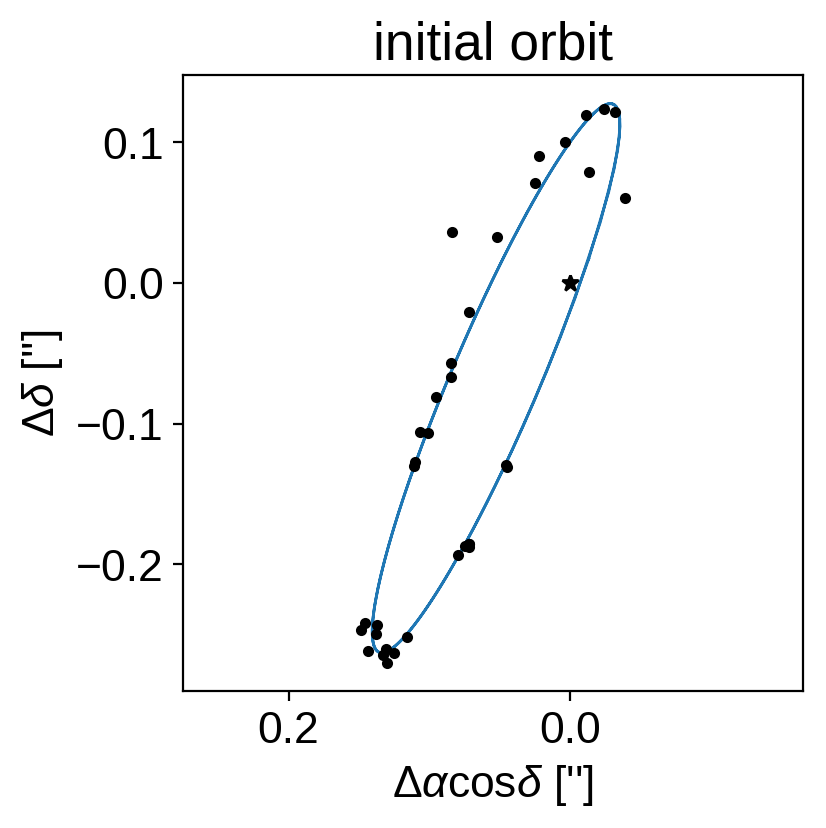

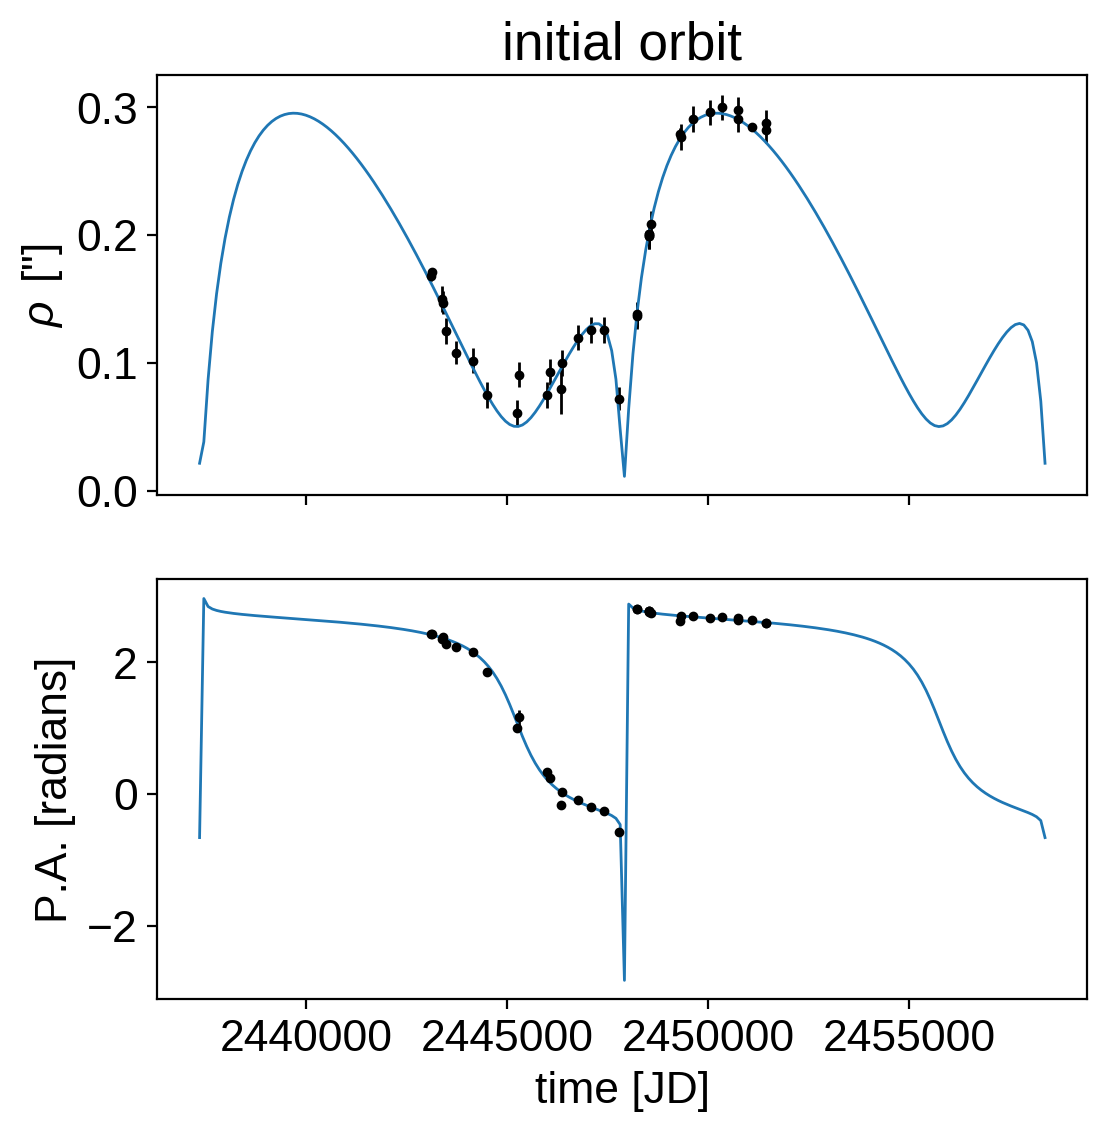

In [7]:
import pymc3 as pm 
import theano.tensor as tt

import exoplanet as xo
from exoplanet.distributions import Angle

from astropy import constants

# conversion constant from au to R_sun
au_to_R_sun = (constants.au / constants.R_sun).value

# Just to get started, let's take a look at the orbit using the best-fit parameters from Pourbaix et al. 1998

# Orbital elements from Pourbaix et al. 1998
# For the relative astrometric fit, we only need the following parameters
a_ang = 0.324  # arcsec
parallax = 1  # arcsec (meaningless choice for now)
a = a_ang * au_to_R_sun / parallax
e = 0.798
i = 96.0 * deg  # [rad]
omega = 251.6 * deg - np.pi  # Pourbaix reports omega_2, but we want omega_1
Omega = 159.6 * deg 
P = 28.8 * 365.25 # days

T0 = Time(1989.92, format="decimalyear")
T0.format = "jd"
T0 = T0.value  # [Julian Date]

# instantiate the orbit
orbit = xo.orbits.KeplerianOrbit(
    a=a, t_periastron=T0, period=P, incl=i, ecc=e,
    omega=omega, Omega=Omega)

# The position functions take an optional argument parallax to convert from
# physical units back to arcseconds
t = np.linspace(T0 - P, T0 + P, num=200) # days
rho, theta = theano.function([], orbit.get_relative_angles(t, parallax))()

# Plot the orbit 
fig, ax = plt.subplots(nrows=1, figsize=(4, 4))

xs = rho * np.cos(theta) # X is north
ys = rho * np.sin(theta) # Y is east
ax.plot(ys, xs, color="C0", lw=1)

# plot the data
xs = rho_data * np.cos(theta_data) # X is north
ys = rho_data * np.sin(theta_data) # Y is east
ax.plot(ys, xs, ".k")

ax.set_ylabel(r"$\Delta \delta$ ['']")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax.invert_xaxis()
ax.plot(0, 0, "k*")
ax.set_aspect("equal", "datalim")
ax.set_title("initial orbit");

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax[0].errorbar(astro_jds, rho_data, yerr=rho_err, fmt=".k", lw=1, ms=5)
ax[0].plot(t, rho, color="C0", lw=1)
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[0].set_title("initial orbit");

ax[1].errorbar(astro_jds, theta_data, yerr=theta_err, fmt=".k", lw=1, ms=5)
ax[1].plot(t, theta, color="C0", lw=1)
ax[1].set_ylabel(r'P.A. [radians]')
ax[1].set_xlabel("time [JD]");

Now that we have an initial orbit, we can set the model up using PyMC3 to do inference.

In [8]:
yr = 365.25

# for predicted orbits
t_fine = np.linspace(astro_jds.min() - 500, astro_jds.max() + 500, num=1000)

def get_model(parallax=None):
    with pm.Model() as model:

        if parallax is None:
            # Without an actual parallax measurement, we can model the orbit in units of arcseconds
            # by providing a fake_parallax and conversion constant
            plx = 1  # arcsec 
        else:
            # Below we will run a version of this model where a measurement of parallax is provided
            # The measurement is in milliarcsec
            m_plx = pm.Bound(pm.Normal, lower=0, upper=100)("m_plx", mu=parallax[0], sd=parallax[1], testval=parallax[0])
            plx = pm.Deterministic("plx", 1e-3 * m_plx)
            
        a_ang = pm.Uniform("a_ang", 0.1, 1.0, testval=0.324)
        a = pm.Deterministic("a", a_ang / plx)

        # We expect the period to be somewhere in the range of 25 years, 
        # so we'll set a broad prior on logP
        logP = pm.Normal("logP", mu=np.log(25*yr), sd=10.0, testval=np.log(28.8*yr))
        P = pm.Deterministic("P", tt.exp(logP))

        # For astrometric-only fits, it's generally better to fit in
        # p = (Omega + omega)/2 and m = (Omega - omega)/2 instead of omega and Omega
        # directly
        omega0 = 251.6 * deg - np.pi
        Omega0 = 159.6 * deg
        p = Angle("p", testval=0.5*(Omega0 + omega0))
        m = Angle("m", testval=0.5*(Omega0 - omega0))
        omega = pm.Deterministic("omega", p - m)
        Omega = pm.Deterministic("Omega", p + m)

        # For these orbits, it can also be better to fit for a phase angle
        # (relative to a reference time) instead of the time of periasteron
        # passage directly
        phase = Angle("phase", testval=0.0)
        tperi = pm.Deterministic("tperi", T0 + P * phase / (2*np.pi))

        # Geometric uiform prior on cos(incl)
        cos_incl = pm.Uniform("cos_incl", lower=-1, upper=1, testval=np.cos(96.0 * deg))
        incl = pm.Deterministic("incl", tt.arccos(cos_incl))
        ecc = pm.Uniform("ecc", lower=0.0, upper=1.0, testval=0.798)

        # Set up the orbit
        orbit = xo.orbits.KeplerianOrbit(
            a=a * au_to_R_sun, t_periastron=tperi, period=P, 
            incl=incl, ecc=ecc, omega=omega, Omega=Omega)
        if parallax is not None:
            pm.Deterministic("M_tot", orbit.m_total)

        # Compute the model in rho and theta
        rho_model, theta_model = orbit.get_relative_angles(astro_jds, plx)
        pm.Deterministic("rho_model", rho_model)
        pm.Deterministic("theta_model", theta_model)

        # Add jitter terms to both separation and position angle
        log_rho_s = pm.Normal("log_rho_s", mu=np.log(np.median(rho_err)), sd=5.0)
        log_theta_s = pm.Normal("log_theta_s", mu=np.log(np.median(theta_err)), sd=5.0)
        rho_tot_err = tt.sqrt(rho_err**2 + tt.exp(2*log_rho_s))
        theta_tot_err = tt.sqrt(theta_err**2 + tt.exp(2*log_theta_s))

        # define the likelihood function, e.g., a Gaussian on both rho and theta
        pm.Normal("rho_obs", mu=rho_model, sd=rho_tot_err, observed=rho_data)

        # We want to be cognizant of the fact that theta wraps so the following is equivalent to 
        # pm.Normal("obs_theta", mu=theta_model, observed=theta_data, sd=theta_tot_err)
        # but takes into account the wrapping. Thanks to Rob de Rosa for the tip.
        theta_diff = tt.arctan2(tt.sin(theta_model - theta_data), tt.cos(theta_model - theta_data))
        pm.Normal("theta_obs", mu=theta_diff, sd=theta_tot_err, observed=0.0)

        # Set up predicted orbits for later plotting 
        rho_dense, theta_dense = orbit.get_relative_angles(t_fine, plx)
        rho_save = pm.Deterministic("rho_save", rho_dense)
        theta_save = pm.Deterministic("theta_save", theta_dense)

        # Optimize to find the initial parameters
        map_soln = model.test_point
        map_soln = xo.optimize(map_soln, vars=[log_rho_s, log_theta_s])
        map_soln = xo.optimize(map_soln, vars=[phase])
        map_soln = xo.optimize(map_soln, vars=[p, m, ecc])
        map_soln = xo.optimize(map_soln, vars=[logP, a_ang, phase])
        map_soln = xo.optimize(map_soln)
    
    return model, map_soln

model, map_soln = get_model()

optimizing logp for variables: ['log_theta_s', 'log_rho_s']


message: Optimization terminated successfully.
logp: 104.85554109314324 -> 147.14399186006233


optimizing logp for variables: ['phase_angle__']


message: Optimization terminated successfully.
logp: 147.14399186006233 -> 167.64220598198332


optimizing logp for variables: ['ecc_interval__', 'm_angle__', 'p_angle__']


message: Optimization terminated successfully.
logp: 167.64220598198335 -> 210.06340668298847


optimizing logp for variables: ['phase_angle__', 'a_ang_interval__', 'logP']


message: Optimization terminated successfully.
logp: 210.06340668298847 -> 210.5013698914882


optimizing logp for variables: ['log_theta_s', 'log_rho_s', 'ecc_interval__', 'cos_incl_interval__', 'phase_angle__', 'm_angle__', 'p_angle__', 'logP', 'a_ang_interval__']


message: Optimization terminated successfully.
logp: 210.5013698914882 -> 215.02117742210876


Now that we have a maximum a posteriori estimate of the parameters, let's take a look at the results to make sure that they seem reasonable.

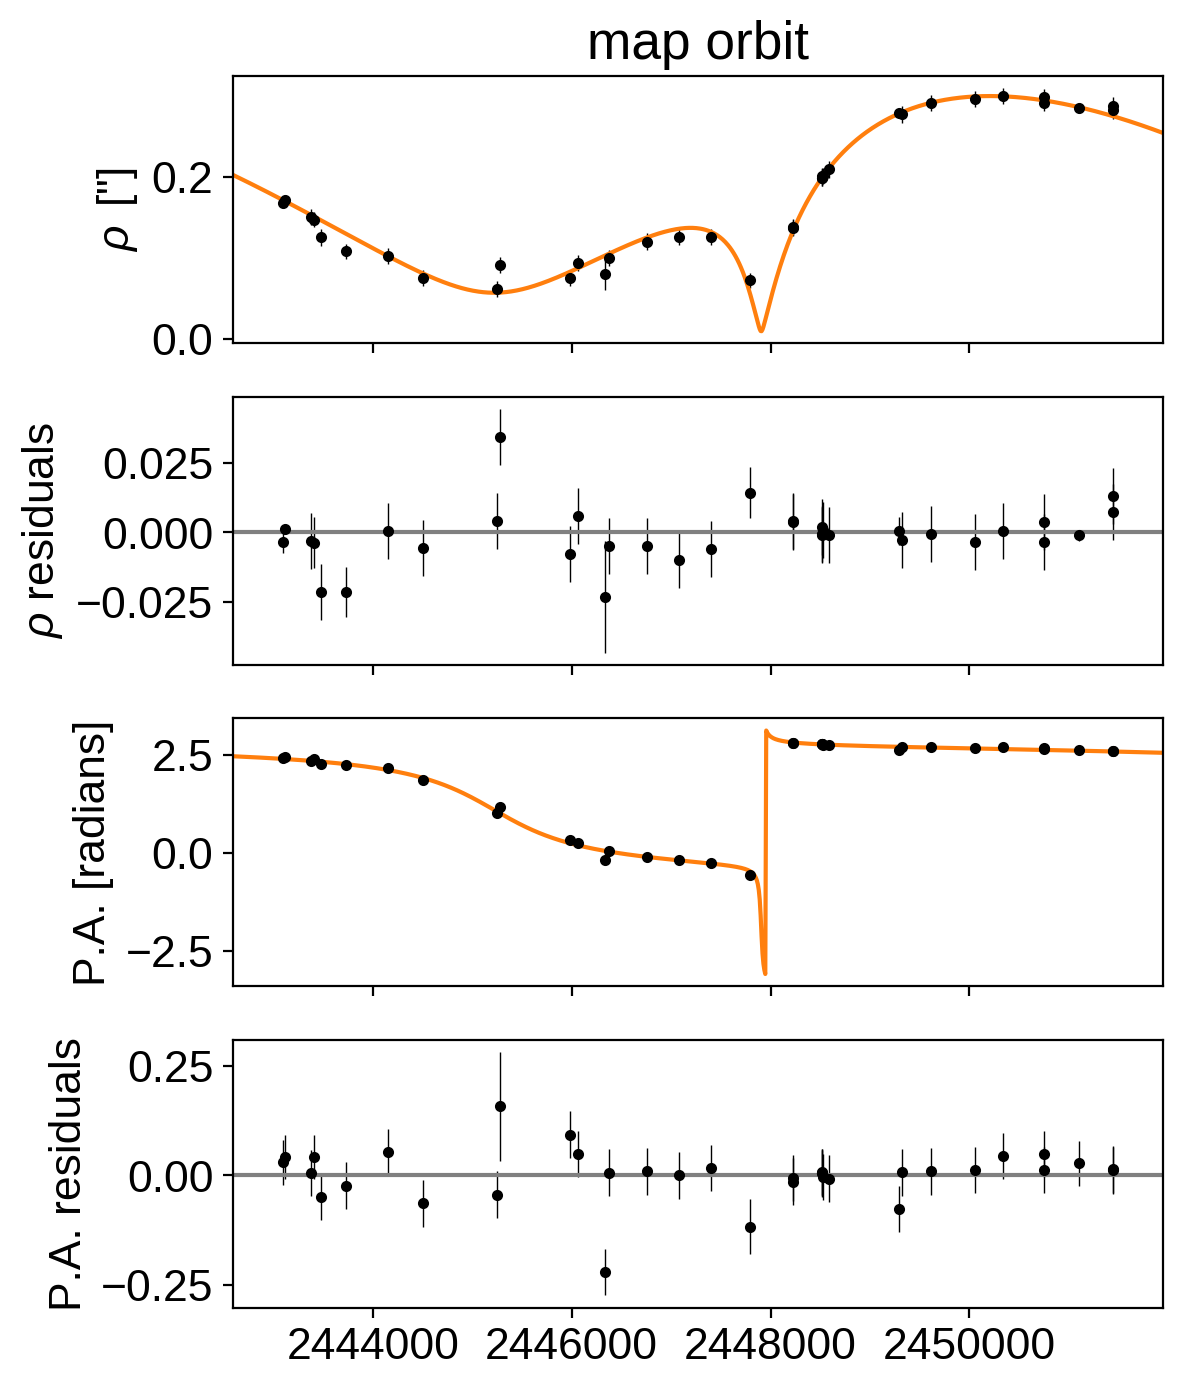

In [9]:
ekw = dict(fmt=".k", lw=0.5)

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(6,8))
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r'$\rho$ residuals')
ax[2].set_ylabel(r'P.A. [radians]')
ax[3].set_ylabel(r'P.A. residuals')

tot_rho_err = np.sqrt(rho_err**2 + np.exp(2 * map_soln["log_rho_s"]))
tot_theta_err = np.sqrt(theta_err**2 + np.exp(2 * map_soln["log_theta_s"]))

ax[0].errorbar(astro_jds, rho_data, yerr=tot_rho_err, **ekw)
ax[0].plot(t_fine, map_soln["rho_save"], "C1")

ax[1].axhline(0.0, color="0.5")
ax[1].errorbar(astro_jds, rho_data - map_soln["rho_model"], yerr=tot_rho_err, **ekw)


ax[2].plot(t_fine, map_soln["theta_save"], "C1")
ax[2].errorbar(astro_jds, theta_data, yerr=tot_theta_err, **ekw)

ax[3].axhline(0.0, color="0.5")
ax[3].errorbar(astro_jds, theta_data - map_soln["theta_model"], yerr=tot_theta_err, **ekw) 

ax[3].set_xlim(t_fine[0], t_fine[-1])
ax[0].set_title("map orbit");

Now let's sample the posterior.

In [10]:
np.random.seed(1234)
sampler = xo.PyMC3Sampler(start=200, window=100, finish=500)
with model:
    burnin = sampler.tune(tune=4500, start=map_soln,
                          step_kwargs=dict(target_accept=0.9))
    trace = sampler.sample(draws=4000)

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 14/808 [00:00<00:05, 133.54draws/s]

Sampling 4 chains:   3%|▎         | 21/808 [00:00<00:08, 89.14draws/s] 

Sampling 4 chains:   3%|▎         | 28/808 [00:00<00:09, 81.87draws/s]

Sampling 4 chains:   4%|▍         | 34/808 [00:00<00:11, 68.65draws/s]

Sampling 4 chains:   5%|▌         | 42/808 [00:00<00:11, 64.57draws/s]

Sampling 4 chains:   6%|▌         | 49/808 [00:00<00:11, 64.74draws/s]

Sampling 4 chains:   7%|▋         | 56/808 [00:00<00:12, 62.16draws/s]

Sampling 4 chains:   8%|▊         | 64/808 [00:00<00:11, 63.54draws/s]

Sampling 4 chains:   9%|▊         | 70/808 [00:01<00:12, 60.17draws/s]

Sampling 4 chains:  10%|▉         | 80/808 [00:01<00:11, 65.85draws/s]

Sampling 4 chains:  11%|█         | 87/808 [00:01<00:11, 64.50draws/s]

Sampling 4 chains:  12%|█▏        | 94/808 [00:01<00:11, 63.97draws/s]

Sampling 4 chains:  13%|█▎        | 102/808 [00:01<00:10, 67.14draws/s]

Sampling 4 chains:  13%|█▎        | 109/808 [00:01<00:11, 62.57draws/s]

Sampling 4 chains:  14%|█▍        | 116/808 [00:01<00:11, 60.19draws/s]

Sampling 4 chains:  15%|█▌        | 123/808 [00:01<00:11, 59.04draws/s]

Sampling 4 chains:  16%|█▌        | 130/808 [00:02<00:10, 61.67draws/s]

Sampling 4 chains:  17%|█▋        | 137/808 [00:02<00:10, 62.75draws/s]

Sampling 4 chains:  18%|█▊        | 144/808 [00:02<00:10, 63.69draws/s]

Sampling 4 chains:  19%|█▊        | 151/808 [00:02<00:10, 62.11draws/s]

Sampling 4 chains:  20%|█▉        | 158/808 [00:02<00:10, 61.23draws/s]

Sampling 4 chains:  20%|██        | 165/808 [00:02<00:10, 60.32draws/s]

Sampling 4 chains:  21%|██▏       | 172/808 [00:02<00:10, 58.02draws/s]

Sampling 4 chains:  22%|██▏       | 178/808 [00:02<00:10, 57.46draws/s]

Sampling 4 chains:  23%|██▎       | 185/808 [00:02<00:10, 59.89draws/s]

Sampling 4 chains:  24%|██▍       | 193/808 [00:03<00:10, 58.47draws/s]

Sampling 4 chains:  25%|██▌       | 202/808 [00:03<00:09, 63.54draws/s]

Sampling 4 chains:  26%|██▌       | 209/808 [00:03<00:09, 63.30draws/s]

Sampling 4 chains:  27%|██▋       | 217/808 [00:03<00:09, 64.56draws/s]

Sampling 4 chains:  28%|██▊       | 225/808 [00:03<00:09, 61.82draws/s]

Sampling 4 chains:  29%|██▊       | 232/808 [00:03<00:08, 64.06draws/s]

Sampling 4 chains:  30%|██▉       | 239/808 [00:03<00:09, 61.96draws/s]

Sampling 4 chains:  30%|███       | 246/808 [00:03<00:09, 61.97draws/s]

Sampling 4 chains:  31%|███▏      | 253/808 [00:03<00:08, 62.38draws/s]

Sampling 4 chains:  32%|███▏      | 260/808 [00:04<00:09, 57.91draws/s]

Sampling 4 chains:  33%|███▎      | 269/808 [00:04<00:08, 60.29draws/s]

Sampling 4 chains:  34%|███▍      | 277/808 [00:04<00:08, 59.59draws/s]

Sampling 4 chains:  35%|███▌      | 286/808 [00:04<00:08, 60.39draws/s]

Sampling 4 chains:  36%|███▋      | 294/808 [00:04<00:08, 61.85draws/s]

Sampling 4 chains:  38%|███▊      | 303/808 [00:04<00:07, 67.46draws/s]

Sampling 4 chains:  38%|███▊      | 311/808 [00:04<00:07, 66.32draws/s]

Sampling 4 chains:  39%|███▉      | 318/808 [00:05<00:07, 64.10draws/s]

Sampling 4 chains:  40%|████      | 326/808 [00:05<00:07, 63.03draws/s]

Sampling 4 chains:  41%|████▏     | 334/808 [00:05<00:07, 65.32draws/s]

Sampling 4 chains:  42%|████▏     | 341/808 [00:05<00:07, 62.88draws/s]

Sampling 4 chains:  43%|████▎     | 350/808 [00:05<00:07, 65.23draws/s]

Sampling 4 chains:  44%|████▍     | 357/808 [00:05<00:07, 63.44draws/s]

Sampling 4 chains:  45%|████▌     | 366/808 [00:05<00:06, 68.63draws/s]

Sampling 4 chains:  46%|████▋     | 374/808 [00:05<00:06, 64.43draws/s]

Sampling 4 chains:  47%|████▋     | 381/808 [00:06<00:06, 61.15draws/s]

Sampling 4 chains:  48%|████▊     | 391/808 [00:06<00:06, 62.62draws/s]

Sampling 4 chains:  49%|████▉     | 399/808 [00:06<00:06, 65.15draws/s]

Sampling 4 chains:  50%|█████     | 406/808 [00:06<00:06, 63.71draws/s]

Sampling 4 chains:  51%|█████     | 413/808 [00:06<00:06, 58.99draws/s]

Sampling 4 chains:  52%|█████▏    | 421/808 [00:06<00:06, 62.47draws/s]

Sampling 4 chains:  53%|█████▎    | 428/808 [00:06<00:06, 61.11draws/s]

Sampling 4 chains:  54%|█████▍    | 435/808 [00:06<00:06, 58.94draws/s]

Sampling 4 chains:  55%|█████▍    | 441/808 [00:06<00:06, 57.81draws/s]

Sampling 4 chains:  56%|█████▌    | 449/808 [00:07<00:06, 59.24draws/s]

Sampling 4 chains:  56%|█████▋    | 456/808 [00:07<00:05, 59.89draws/s]

Sampling 4 chains:  57%|█████▋    | 463/808 [00:07<00:05, 57.71draws/s]

Sampling 4 chains:  58%|█████▊    | 470/808 [00:07<00:05, 57.99draws/s]

Sampling 4 chains:  59%|█████▉    | 477/808 [00:07<00:05, 60.19draws/s]

Sampling 4 chains:  60%|█████▉    | 484/808 [00:07<00:05, 61.27draws/s]

Sampling 4 chains:  61%|██████    | 491/808 [00:07<00:05, 58.04draws/s]

Sampling 4 chains:  62%|██████▏   | 497/808 [00:07<00:05, 58.19draws/s]

Sampling 4 chains:  63%|██████▎   | 507/808 [00:08<00:04, 65.80draws/s]

Sampling 4 chains:  64%|██████▎   | 514/808 [00:08<00:04, 65.94draws/s]

Sampling 4 chains:  64%|██████▍   | 521/808 [00:08<00:04, 65.90draws/s]

Sampling 4 chains:  65%|██████▌   | 528/808 [00:08<00:04, 60.21draws/s]

Sampling 4 chains:  66%|██████▋   | 537/808 [00:08<00:04, 66.03draws/s]

Sampling 4 chains:  67%|██████▋   | 544/808 [00:08<00:04, 65.27draws/s]

Sampling 4 chains:  68%|██████▊   | 553/808 [00:08<00:03, 68.82draws/s]

Sampling 4 chains:  69%|██████▉   | 561/808 [00:08<00:03, 68.04draws/s]

Sampling 4 chains:  70%|███████   | 568/808 [00:08<00:03, 66.57draws/s]

Sampling 4 chains:  71%|███████   | 575/808 [00:09<00:03, 63.89draws/s]

Sampling 4 chains:  72%|███████▏  | 584/808 [00:09<00:03, 64.81draws/s]

Sampling 4 chains:  73%|███████▎  | 592/808 [00:09<00:03, 66.25draws/s]

Sampling 4 chains:  74%|███████▍  | 599/808 [00:09<00:03, 63.14draws/s]

Sampling 4 chains:  75%|███████▌  | 607/808 [00:09<00:03, 63.26draws/s]

Sampling 4 chains:  76%|███████▌  | 614/808 [00:09<00:02, 64.75draws/s]

Sampling 4 chains:  77%|███████▋  | 622/808 [00:09<00:02, 64.04draws/s]

Sampling 4 chains:  78%|███████▊  | 630/808 [00:09<00:02, 66.17draws/s]

Sampling 4 chains:  79%|███████▉  | 637/808 [00:10<00:02, 64.15draws/s]

Sampling 4 chains:  80%|███████▉  | 644/808 [00:10<00:02, 59.83draws/s]

Sampling 4 chains:  81%|████████  | 651/808 [00:10<00:02, 62.19draws/s]

Sampling 4 chains:  81%|████████▏ | 658/808 [00:10<00:02, 61.95draws/s]

Sampling 4 chains:  82%|████████▏ | 665/808 [00:10<00:02, 62.35draws/s]

Sampling 4 chains:  83%|████████▎ | 672/808 [00:10<00:02, 63.38draws/s]

Sampling 4 chains:  84%|████████▍ | 679/808 [00:10<00:02, 58.90draws/s]

Sampling 4 chains:  85%|████████▌ | 687/808 [00:10<00:02, 57.84draws/s]

Sampling 4 chains:  86%|████████▌ | 695/808 [00:11<00:01, 57.18draws/s]

Sampling 4 chains:  87%|████████▋ | 704/808 [00:11<00:01, 58.77draws/s]

Sampling 4 chains:  88%|████████▊ | 713/808 [00:11<00:01, 60.23draws/s]

Sampling 4 chains:  89%|████████▉ | 722/808 [00:11<00:01, 65.23draws/s]

Sampling 4 chains:  90%|█████████ | 729/808 [00:11<00:01, 63.17draws/s]

Sampling 4 chains:  91%|█████████ | 737/808 [00:11<00:01, 62.66draws/s]

Sampling 4 chains:  92%|█████████▏| 746/808 [00:11<00:00, 67.40draws/s]

Sampling 4 chains:  93%|█████████▎| 753/808 [00:11<00:00, 63.29draws/s]

Sampling 4 chains:  94%|█████████▍| 762/808 [00:12<00:00, 69.11draws/s]

Sampling 4 chains:  95%|█████████▌| 770/808 [00:12<00:00, 66.37draws/s]

Sampling 4 chains:  96%|█████████▋| 779/808 [00:12<00:00, 65.43draws/s]

Sampling 4 chains:  97%|█████████▋| 786/808 [00:12<00:00, 63.23draws/s]

Sampling 4 chains:  98%|█████████▊| 793/808 [00:12<00:00, 52.10draws/s]

Sampling 4 chains:  99%|█████████▉| 799/808 [00:12<00:00, 48.46draws/s]

Sampling 4 chains: 100%|█████████▉| 805/808 [00:12<00:00, 37.28draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:13<00:00, 60.97draws/s]

Sampling 4 chains:   0%|          | 0/408 [00:00<?, ?draws/s]

Sampling 4 chains:   3%|▎         | 14/408 [00:00<00:02, 139.52draws/s]

Sampling 4 chains:   5%|▌         | 22/408 [00:00<00:03, 98.29draws/s] 

Sampling 4 chains:   7%|▋         | 30/408 [00:00<00:04, 91.76draws/s]

Sampling 4 chains:   9%|▉         | 36/408 [00:00<00:04, 79.07draws/s]

Sampling 4 chains:  11%|█         | 45/408 [00:00<00:04, 77.69draws/s]

Sampling 4 chains:  13%|█▎        | 53/408 [00:00<00:04, 74.36draws/s]

Sampling 4 chains:  15%|█▍        | 61/408 [00:00<00:04, 75.26draws/s]

Sampling 4 chains:  17%|█▋        | 68/408 [00:00<00:04, 72.17draws/s]

Sampling 4 chains:  19%|█▉        | 78/408 [00:01<00:04, 70.86draws/s]

Sampling 4 chains:  21%|██▏       | 87/408 [00:01<00:04, 72.88draws/s]

Sampling 4 chains:  23%|██▎       | 95/408 [00:01<00:04, 68.69draws/s]

Sampling 4 chains:  26%|██▌       | 106/408 [00:01<00:04, 73.49draws/s]

Sampling 4 chains:  28%|██▊       | 115/408 [00:01<00:03, 75.70draws/s]

Sampling 4 chains:  30%|███       | 123/408 [00:01<00:04, 69.33draws/s]

Sampling 4 chains:  33%|███▎      | 133/408 [00:01<00:03, 75.64draws/s]

Sampling 4 chains:  35%|███▍      | 141/408 [00:01<00:03, 75.87draws/s]

Sampling 4 chains:  37%|███▋      | 151/408 [00:01<00:03, 80.09draws/s]

Sampling 4 chains:  39%|███▉      | 160/408 [00:02<00:03, 81.64draws/s]

Sampling 4 chains:  41%|████▏     | 169/408 [00:02<00:02, 81.52draws/s]

Sampling 4 chains:  44%|████▎     | 178/408 [00:02<00:02, 78.27draws/s]

Sampling 4 chains:  46%|████▌     | 186/408 [00:02<00:02, 77.00draws/s]

Sampling 4 chains:  48%|████▊     | 196/408 [00:02<00:02, 79.08draws/s]

Sampling 4 chains:  50%|█████     | 205/408 [00:02<00:02, 70.73draws/s]

Sampling 4 chains:  52%|█████▏    | 213/408 [00:02<00:02, 70.61draws/s]

Sampling 4 chains:  54%|█████▍    | 221/408 [00:02<00:02, 71.72draws/s]

Sampling 4 chains:  56%|█████▌    | 229/408 [00:03<00:02, 66.29draws/s]

Sampling 4 chains:  58%|█████▊    | 237/408 [00:03<00:02, 67.98draws/s]

Sampling 4 chains:  61%|██████    | 247/408 [00:03<00:02, 69.82draws/s]

Sampling 4 chains:  63%|██████▎   | 256/408 [00:03<00:02, 70.60draws/s]

Sampling 4 chains:  65%|██████▍   | 264/408 [00:03<00:02, 71.03draws/s]

Sampling 4 chains:  67%|██████▋   | 272/408 [00:03<00:01, 68.02draws/s]

Sampling 4 chains:  69%|██████▉   | 281/408 [00:03<00:01, 73.22draws/s]

Sampling 4 chains:  71%|███████▏  | 291/408 [00:03<00:01, 76.93draws/s]

Sampling 4 chains:  73%|███████▎  | 299/408 [00:04<00:01, 73.70draws/s]

Sampling 4 chains:  75%|███████▌  | 307/408 [00:04<00:01, 75.38draws/s]

Sampling 4 chains:  77%|███████▋  | 315/408 [00:04<00:01, 73.93draws/s]

Sampling 4 chains:  79%|███████▉  | 323/408 [00:04<00:01, 72.77draws/s]

Sampling 4 chains:  82%|████████▏ | 333/408 [00:04<00:00, 75.32draws/s]

Sampling 4 chains:  84%|████████▎ | 341/408 [00:04<00:00, 73.70draws/s]

Sampling 4 chains:  86%|████████▌ | 349/408 [00:04<00:00, 68.54draws/s]

Sampling 4 chains:  87%|████████▋ | 356/408 [00:04<00:00, 67.94draws/s]

Sampling 4 chains:  89%|████████▉ | 365/408 [00:04<00:00, 72.41draws/s]

Sampling 4 chains:  92%|█████████▏| 376/408 [00:05<00:00, 78.33draws/s]

Sampling 4 chains:  94%|█████████▍| 385/408 [00:05<00:00, 72.52draws/s]

Sampling 4 chains:  96%|█████████▋| 393/408 [00:05<00:00, 62.41draws/s]

Sampling 4 chains:  98%|█████████▊| 400/408 [00:05<00:00, 46.57draws/s]

Sampling 4 chains: 100%|█████████▉| 406/408 [00:05<00:00, 32.10draws/s]

Sampling 4 chains: 100%|██████████| 408/408 [00:06<00:00, 66.39draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   6%|▌         | 50/808 [00:00<00:01, 497.81draws/s]

Sampling 4 chains:  11%|█         | 90/808 [00:00<00:01, 462.47draws/s]

Sampling 4 chains:  16%|█▌        | 127/808 [00:00<00:01, 428.79draws/s]

Sampling 4 chains:  22%|██▏       | 178/808 [00:00<00:01, 448.72draws/s]

Sampling 4 chains:  29%|██▊       | 232/808 [00:00<00:01, 472.31draws/s]

Sampling 4 chains:  34%|███▍      | 274/808 [00:00<00:01, 453.66draws/s]

Sampling 4 chains:  40%|████      | 326/808 [00:00<00:01, 471.39draws/s]

Sampling 4 chains:  47%|████▋     | 381/808 [00:00<00:00, 487.31draws/s]

Sampling 4 chains:  54%|█████▍    | 437/808 [00:00<00:00, 505.57draws/s]

Sampling 4 chains:  62%|██████▏   | 498/808 [00:01<00:00, 532.60draws/s]

Sampling 4 chains:  69%|██████▊   | 554/808 [00:01<00:00, 538.96draws/s]

Sampling 4 chains:  76%|███████▌  | 611/808 [00:01<00:00, 545.60draws/s]

Sampling 4 chains:  83%|████████▎ | 674/808 [00:01<00:00, 566.85draws/s]

Sampling 4 chains:  91%|█████████ | 735/808 [00:01<00:00, 577.67draws/s]

Sampling 4 chains:  98%|█████████▊| 793/808 [00:01<00:00, 442.93draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:01<00:00, 466.27draws/s]

Sampling 4 chains:   0%|          | 0/1608 [00:00<?, ?draws/s]

Sampling 4 chains:   3%|▎         | 41/1608 [00:00<00:03, 408.92draws/s]

Sampling 4 chains:   4%|▍         | 70/1608 [00:00<00:04, 362.32draws/s]

Sampling 4 chains:   7%|▋         | 111/1608 [00:00<00:04, 374.03draws/s]

Sampling 4 chains:   9%|▉         | 151/1608 [00:00<00:03, 381.04draws/s]

Sampling 4 chains:  12%|█▏        | 197/1608 [00:00<00:03, 400.02draws/s]

Sampling 4 chains:  16%|█▌        | 254/1608 [00:00<00:03, 438.26draws/s]

Sampling 4 chains:  18%|█▊        | 295/1608 [00:00<00:03, 427.90draws/s]

Sampling 4 chains:  21%|██▏       | 343/1608 [00:00<00:02, 439.26draws/s]

Sampling 4 chains:  25%|██▌       | 402/1608 [00:00<00:02, 475.61draws/s]

Sampling 4 chains:  28%|██▊       | 454/1608 [00:01<00:02, 488.07draws/s]

Sampling 4 chains:  31%|███▏      | 506/1608 [00:01<00:02, 495.63draws/s]

Sampling 4 chains:  35%|███▍      | 556/1608 [00:01<00:02, 472.45draws/s]

Sampling 4 chains:  38%|███▊      | 608/1608 [00:01<00:02, 484.82draws/s]

Sampling 4 chains:  41%|████      | 660/1608 [00:01<00:01, 490.96draws/s]

Sampling 4 chains:  44%|████▍     | 715/1608 [00:01<00:01, 505.82draws/s]

Sampling 4 chains:  48%|████▊     | 772/1608 [00:01<00:01, 522.52draws/s]

Sampling 4 chains:  52%|█████▏    | 837/1608 [00:01<00:01, 551.02draws/s]

Sampling 4 chains:  56%|█████▌    | 893/1608 [00:01<00:01, 531.01draws/s]

Sampling 4 chains:  59%|█████▉    | 952/1608 [00:01<00:01, 546.43draws/s]

Sampling 4 chains:  63%|██████▎   | 1009/1608 [00:02<00:01, 551.32draws/s]

Sampling 4 chains:  67%|██████▋   | 1071/1608 [00:02<00:00, 568.92draws/s]

Sampling 4 chains:  70%|███████   | 1129/1608 [00:02<00:00, 542.30draws/s]

Sampling 4 chains:  74%|███████▎  | 1184/1608 [00:02<00:00, 534.84draws/s]

Sampling 4 chains:  77%|███████▋  | 1238/1608 [00:02<00:00, 527.71draws/s]

Sampling 4 chains:  80%|████████  | 1292/1608 [00:02<00:00, 518.40draws/s]

Sampling 4 chains:  84%|████████▎ | 1345/1608 [00:02<00:00, 475.73draws/s]

Sampling 4 chains:  87%|████████▋ | 1400/1608 [00:02<00:00, 477.58draws/s]

Sampling 4 chains:  90%|█████████ | 1449/1608 [00:02<00:00, 442.36draws/s]

Sampling 4 chains:  93%|█████████▎| 1498/1608 [00:03<00:00, 453.86draws/s]

Sampling 4 chains:  96%|█████████▌| 1545/1608 [00:03<00:00, 400.00draws/s]

Sampling 4 chains:  99%|█████████▊| 1587/1608 [00:03<00:00, 314.49draws/s]

Sampling 4 chains: 100%|██████████| 1608/1608 [00:03<00:00, 453.58draws/s]

Sampling 4 chains:   0%|          | 0/3208 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 36/3208 [00:00<00:09, 344.25draws/s]

Sampling 4 chains:   2%|▏         | 69/3208 [00:00<00:09, 336.47draws/s]

Sampling 4 chains:   3%|▎         | 86/3208 [00:00<00:12, 256.06draws/s]

Sampling 4 chains:   4%|▍         | 124/3208 [00:00<00:10, 281.55draws/s]

Sampling 4 chains:   5%|▌         | 162/3208 [00:00<00:10, 301.46draws/s]

Sampling 4 chains:   6%|▌         | 189/3208 [00:00<00:10, 288.56draws/s]

Sampling 4 chains:   7%|▋         | 225/3208 [00:00<00:09, 305.81draws/s]

Sampling 4 chains:   8%|▊         | 261/3208 [00:00<00:09, 318.99draws/s]

Sampling 4 chains:  10%|▉         | 307/3208 [00:00<00:08, 350.31draws/s]

Sampling 4 chains:  11%|█         | 358/3208 [00:01<00:07, 385.70draws/s]

Sampling 4 chains:  12%|█▏        | 398/3208 [00:01<00:07, 370.16draws/s]

Sampling 4 chains:  14%|█▎        | 439/3208 [00:01<00:07, 377.65draws/s]

Sampling 4 chains:  15%|█▍        | 478/3208 [00:01<00:07, 378.49draws/s]

Sampling 4 chains:  16%|█▋        | 527/3208 [00:01<00:06, 405.96draws/s]

Sampling 4 chains:  18%|█▊        | 576/3208 [00:01<00:06, 426.64draws/s]

Sampling 4 chains:  20%|█▉        | 639/3208 [00:01<00:05, 471.44draws/s]

Sampling 4 chains:  22%|██▏       | 692/3208 [00:01<00:05, 486.30draws/s]

Sampling 4 chains:  23%|██▎       | 750/3208 [00:01<00:04, 510.94draws/s]

Sampling 4 chains:  25%|██▌       | 803/3208 [00:01<00:04, 495.82draws/s]

Sampling 4 chains:  27%|██▋       | 854/3208 [00:02<00:04, 477.68draws/s]

Sampling 4 chains:  28%|██▊       | 903/3208 [00:02<00:04, 475.12draws/s]

Sampling 4 chains:  30%|██▉       | 952/3208 [00:02<00:04, 469.95draws/s]

Sampling 4 chains:  31%|███▏      | 1005/3208 [00:02<00:04, 482.07draws/s]

Sampling 4 chains:  33%|███▎      | 1055/3208 [00:02<00:04, 487.22draws/s]

Sampling 4 chains:  35%|███▍      | 1113/3208 [00:02<00:04, 511.25draws/s]

Sampling 4 chains:  36%|███▋      | 1165/3208 [00:02<00:04, 502.43draws/s]

Sampling 4 chains:  38%|███▊      | 1216/3208 [00:02<00:04, 491.50draws/s]

Sampling 4 chains:  39%|███▉      | 1266/3208 [00:02<00:04, 482.22draws/s]

Sampling 4 chains:  41%|████      | 1315/3208 [00:03<00:03, 481.23draws/s]

Sampling 4 chains:  43%|████▎     | 1364/3208 [00:03<00:04, 421.25draws/s]

Sampling 4 chains:  44%|████▍     | 1408/3208 [00:03<00:04, 420.95draws/s]

Sampling 4 chains:  45%|████▌     | 1457/3208 [00:03<00:03, 438.96draws/s]

Sampling 4 chains:  47%|████▋     | 1502/3208 [00:03<00:03, 440.56draws/s]

Sampling 4 chains:  48%|████▊     | 1549/3208 [00:03<00:03, 445.32draws/s]

Sampling 4 chains:  50%|████▉     | 1594/3208 [00:03<00:03, 438.56draws/s]

Sampling 4 chains:  51%|█████     | 1644/3208 [00:03<00:03, 453.94draws/s]

Sampling 4 chains:  53%|█████▎    | 1699/3208 [00:03<00:03, 478.17draws/s]

Sampling 4 chains:  54%|█████▍    | 1748/3208 [00:04<00:03, 447.97draws/s]

Sampling 4 chains:  56%|█████▌    | 1794/3208 [00:04<00:03, 447.53draws/s]

Sampling 4 chains:  57%|█████▋    | 1842/3208 [00:04<00:02, 455.61draws/s]

Sampling 4 chains:  59%|█████▉    | 1895/3208 [00:04<00:02, 475.46draws/s]

Sampling 4 chains:  61%|██████    | 1944/3208 [00:04<00:02, 478.92draws/s]

Sampling 4 chains:  63%|██████▎   | 2010/3208 [00:04<00:02, 520.08draws/s]

Sampling 4 chains:  64%|██████▍   | 2064/3208 [00:04<00:02, 505.10draws/s]

Sampling 4 chains:  66%|██████▌   | 2116/3208 [00:04<00:02, 492.89draws/s]

Sampling 4 chains:  68%|██████▊   | 2171/3208 [00:04<00:02, 508.38draws/s]

Sampling 4 chains:  69%|██████▉   | 2224/3208 [00:04<00:01, 511.77draws/s]

Sampling 4 chains:  71%|███████   | 2277/3208 [00:05<00:01, 516.18draws/s]

Sampling 4 chains:  73%|███████▎  | 2332/3208 [00:05<00:01, 524.41draws/s]

Sampling 4 chains:  74%|███████▍  | 2385/3208 [00:05<00:01, 502.02draws/s]

Sampling 4 chains:  76%|███████▌  | 2437/3208 [00:05<00:01, 504.56draws/s]

Sampling 4 chains:  78%|███████▊  | 2488/3208 [00:05<00:01, 503.41draws/s]

Sampling 4 chains:  79%|███████▉  | 2539/3208 [00:05<00:01, 482.85draws/s]

Sampling 4 chains:  81%|████████  | 2588/3208 [00:05<00:01, 474.42draws/s]

Sampling 4 chains:  82%|████████▏ | 2636/3208 [00:05<00:01, 471.05draws/s]

Sampling 4 chains:  84%|████████▍ | 2687/3208 [00:05<00:01, 481.77draws/s]

Sampling 4 chains:  85%|████████▌ | 2736/3208 [00:06<00:01, 466.30draws/s]

Sampling 4 chains:  87%|████████▋ | 2786/3208 [00:06<00:00, 474.20draws/s]

Sampling 4 chains:  89%|████████▊ | 2842/3208 [00:06<00:00, 495.69draws/s]

Sampling 4 chains:  90%|█████████ | 2892/3208 [00:06<00:00, 455.07draws/s]

Sampling 4 chains:  92%|█████████▏| 2945/3208 [00:06<00:00, 474.98draws/s]

Sampling 4 chains:  93%|█████████▎| 2994/3208 [00:06<00:00, 479.07draws/s]

Sampling 4 chains:  95%|█████████▍| 3046/3208 [00:06<00:00, 489.17draws/s]

Sampling 4 chains:  97%|█████████▋| 3096/3208 [00:06<00:00, 484.92draws/s]

Sampling 4 chains:  98%|█████████▊| 3145/3208 [00:06<00:00, 387.26draws/s]

Sampling 4 chains:  99%|█████████▉| 3188/3208 [00:07<00:00, 304.18draws/s]

Sampling 4 chains: 100%|██████████| 3208/3208 [00:07<00:00, 440.18draws/s]

Sampling 4 chains:   0%|          | 0/11208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 37/11208 [00:00<00:30, 367.09draws/s]

Sampling 4 chains:   1%|          | 74/11208 [00:00<00:30, 361.84draws/s]

Sampling 4 chains:   1%|          | 108/11208 [00:00<00:31, 354.68draws/s]

Sampling 4 chains:   1%|▏         | 150/11208 [00:00<00:29, 369.07draws/s]

Sampling 4 chains:   2%|▏         | 182/11208 [00:00<00:31, 348.13draws/s]

Sampling 4 chains:   2%|▏         | 233/11208 [00:00<00:28, 383.39draws/s]

Sampling 4 chains:   3%|▎         | 291/11208 [00:00<00:25, 426.13draws/s]

Sampling 4 chains:   3%|▎         | 338/11208 [00:00<00:24, 437.85draws/s]

Sampling 4 chains:   3%|▎         | 382/11208 [00:00<00:25, 428.52draws/s]

Sampling 4 chains:   4%|▍         | 425/11208 [00:01<00:26, 400.80draws/s]

Sampling 4 chains:   4%|▍         | 468/11208 [00:01<00:26, 409.10draws/s]

Sampling 4 chains:   5%|▍         | 527/11208 [00:01<00:23, 449.37draws/s]

Sampling 4 chains:   5%|▌         | 580/11208 [00:01<00:22, 468.09draws/s]

Sampling 4 chains:   6%|▌         | 628/11208 [00:01<00:22, 467.61draws/s]

Sampling 4 chains:   6%|▌         | 685/11208 [00:01<00:21, 492.19draws/s]

Sampling 4 chains:   7%|▋         | 739/11208 [00:01<00:20, 504.95draws/s]

Sampling 4 chains:   7%|▋         | 800/11208 [00:01<00:19, 529.64draws/s]

Sampling 4 chains:   8%|▊         | 857/11208 [00:01<00:19, 541.00draws/s]

Sampling 4 chains:   8%|▊         | 912/11208 [00:01<00:20, 498.01draws/s]

Sampling 4 chains:   9%|▊         | 970/11208 [00:02<00:19, 518.79draws/s]

Sampling 4 chains:   9%|▉         | 1030/11208 [00:02<00:18, 538.78draws/s]

Sampling 4 chains:  10%|▉         | 1085/11208 [00:02<00:19, 522.63draws/s]

Sampling 4 chains:  10%|█         | 1143/11208 [00:02<00:18, 537.21draws/s]

Sampling 4 chains:  11%|█         | 1205/11208 [00:02<00:17, 557.85draws/s]

Sampling 4 chains:  11%|█▏        | 1264/11208 [00:02<00:17, 565.35draws/s]

Sampling 4 chains:  12%|█▏        | 1322/11208 [00:02<00:18, 533.63draws/s]

Sampling 4 chains:  12%|█▏        | 1377/11208 [00:02<00:18, 526.04draws/s]

Sampling 4 chains:  13%|█▎        | 1431/11208 [00:02<00:18, 516.16draws/s]

Sampling 4 chains:  13%|█▎        | 1486/11208 [00:03<00:18, 524.19draws/s]

Sampling 4 chains:  14%|█▎        | 1539/11208 [00:03<00:18, 509.47draws/s]

Sampling 4 chains:  14%|█▍        | 1596/11208 [00:03<00:18, 524.05draws/s]

Sampling 4 chains:  15%|█▍        | 1650/11208 [00:03<00:18, 526.92draws/s]

Sampling 4 chains:  15%|█▌        | 1710/11208 [00:03<00:17, 546.12draws/s]

Sampling 4 chains:  16%|█▌        | 1765/11208 [00:03<00:17, 543.09draws/s]

Sampling 4 chains:  16%|█▌        | 1820/11208 [00:03<00:17, 524.35draws/s]

Sampling 4 chains:  17%|█▋        | 1873/11208 [00:03<00:17, 518.87draws/s]

Sampling 4 chains:  17%|█▋        | 1933/11208 [00:03<00:17, 539.85draws/s]

Sampling 4 chains:  18%|█▊        | 1992/11208 [00:03<00:16, 551.90draws/s]

Sampling 4 chains:  18%|█▊        | 2052/11208 [00:04<00:16, 564.77draws/s]

Sampling 4 chains:  19%|█▉        | 2109/11208 [00:04<00:16, 550.17draws/s]

Sampling 4 chains:  19%|█▉        | 2165/11208 [00:04<00:16, 538.04draws/s]

Sampling 4 chains:  20%|█▉        | 2220/11208 [00:04<00:17, 513.23draws/s]

Sampling 4 chains:  20%|██        | 2283/11208 [00:04<00:16, 543.04draws/s]

Sampling 4 chains:  21%|██        | 2339/11208 [00:04<00:16, 544.12draws/s]

Sampling 4 chains:  21%|██▏       | 2405/11208 [00:04<00:15, 573.64draws/s]

Sampling 4 chains:  22%|██▏       | 2467/11208 [00:04<00:14, 585.10draws/s]

Sampling 4 chains:  23%|██▎       | 2527/11208 [00:04<00:15, 572.93draws/s]

Sampling 4 chains:  23%|██▎       | 2585/11208 [00:05<00:15, 562.25draws/s]

Sampling 4 chains:  24%|██▎       | 2644/11208 [00:05<00:15, 569.17draws/s]

Sampling 4 chains:  24%|██▍       | 2702/11208 [00:05<00:15, 552.60draws/s]

Sampling 4 chains:  25%|██▍       | 2760/11208 [00:05<00:15, 559.13draws/s]

Sampling 4 chains:  25%|██▌       | 2820/11208 [00:05<00:14, 567.17draws/s]

Sampling 4 chains:  26%|██▌       | 2877/11208 [00:05<00:15, 545.82draws/s]

Sampling 4 chains:  26%|██▌       | 2932/11208 [00:05<00:16, 510.07draws/s]

Sampling 4 chains:  27%|██▋       | 2994/11208 [00:05<00:15, 536.82draws/s]

Sampling 4 chains:  27%|██▋       | 3052/11208 [00:05<00:14, 549.01draws/s]

Sampling 4 chains:  28%|██▊       | 3112/11208 [00:06<00:14, 560.66draws/s]

Sampling 4 chains:  28%|██▊       | 3169/11208 [00:06<00:14, 550.11draws/s]

Sampling 4 chains:  29%|██▉       | 3225/11208 [00:06<00:14, 535.43draws/s]

Sampling 4 chains:  29%|██▉       | 3279/11208 [00:06<00:15, 512.55draws/s]

Sampling 4 chains:  30%|██▉       | 3341/11208 [00:06<00:14, 539.49draws/s]

Sampling 4 chains:  30%|███       | 3404/11208 [00:06<00:13, 560.50draws/s]

Sampling 4 chains:  31%|███       | 3461/11208 [00:06<00:13, 557.69draws/s]

Sampling 4 chains:  32%|███▏      | 3531/11208 [00:06<00:12, 592.35draws/s]

Sampling 4 chains:  32%|███▏      | 3592/11208 [00:06<00:12, 587.06draws/s]

Sampling 4 chains:  33%|███▎      | 3657/11208 [00:06<00:12, 603.08draws/s]

Sampling 4 chains:  33%|███▎      | 3718/11208 [00:07<00:12, 578.35draws/s]

Sampling 4 chains:  34%|███▎      | 3781/11208 [00:07<00:12, 592.52draws/s]

Sampling 4 chains:  34%|███▍      | 3841/11208 [00:07<00:12, 582.98draws/s]

Sampling 4 chains:  35%|███▍      | 3900/11208 [00:07<00:12, 573.20draws/s]

Sampling 4 chains:  35%|███▌      | 3958/11208 [00:07<00:13, 549.83draws/s]

Sampling 4 chains:  36%|███▌      | 4015/11208 [00:07<00:12, 555.39draws/s]

Sampling 4 chains:  36%|███▋      | 4071/11208 [00:07<00:12, 550.31draws/s]

Sampling 4 chains:  37%|███▋      | 4128/11208 [00:07<00:12, 555.34draws/s]

Sampling 4 chains:  37%|███▋      | 4189/11208 [00:07<00:12, 570.48draws/s]

Sampling 4 chains:  38%|███▊      | 4247/11208 [00:08<00:12, 539.97draws/s]

Sampling 4 chains:  38%|███▊      | 4302/11208 [00:08<00:13, 530.95draws/s]

Sampling 4 chains:  39%|███▉      | 4356/11208 [00:08<00:13, 509.67draws/s]

Sampling 4 chains:  39%|███▉      | 4409/11208 [00:08<00:13, 514.44draws/s]

Sampling 4 chains:  40%|███▉      | 4466/11208 [00:08<00:12, 528.99draws/s]

Sampling 4 chains:  40%|████      | 4533/11208 [00:08<00:11, 563.97draws/s]

Sampling 4 chains:  41%|████      | 4591/11208 [00:08<00:12, 542.36draws/s]

Sampling 4 chains:  41%|████▏     | 4649/11208 [00:08<00:11, 551.85draws/s]

Sampling 4 chains:  42%|████▏     | 4716/11208 [00:08<00:11, 581.67draws/s]

Sampling 4 chains:  43%|████▎     | 4776/11208 [00:08<00:11, 561.94draws/s]

Sampling 4 chains:  43%|████▎     | 4836/11208 [00:09<00:11, 570.48draws/s]

Sampling 4 chains:  44%|████▎     | 4894/11208 [00:09<00:11, 562.45draws/s]

Sampling 4 chains:  44%|████▍     | 4951/11208 [00:09<00:11, 559.06draws/s]

Sampling 4 chains:  45%|████▍     | 5016/11208 [00:09<00:10, 580.52draws/s]

Sampling 4 chains:  45%|████▌     | 5076/11208 [00:09<00:10, 582.74draws/s]

Sampling 4 chains:  46%|████▌     | 5135/11208 [00:09<00:10, 555.73draws/s]

Sampling 4 chains:  46%|████▋     | 5192/11208 [00:09<00:11, 540.28draws/s]

Sampling 4 chains:  47%|████▋     | 5249/11208 [00:09<00:10, 548.73draws/s]

Sampling 4 chains:  47%|████▋     | 5319/11208 [00:09<00:10, 586.58draws/s]

Sampling 4 chains:  48%|████▊     | 5385/11208 [00:10<00:09, 605.72draws/s]

Sampling 4 chains:  49%|████▊     | 5447/11208 [00:10<00:09, 601.80draws/s]

Sampling 4 chains:  49%|████▉     | 5508/11208 [00:10<00:09, 586.18draws/s]

Sampling 4 chains:  50%|████▉     | 5568/11208 [00:10<00:10, 552.30draws/s]

Sampling 4 chains:  50%|█████     | 5628/11208 [00:10<00:09, 565.01draws/s]

Sampling 4 chains:  51%|█████     | 5686/11208 [00:10<00:09, 561.14draws/s]

Sampling 4 chains:  51%|█████     | 5743/11208 [00:10<00:10, 536.54draws/s]

Sampling 4 chains:  52%|█████▏    | 5798/11208 [00:10<00:10, 537.00draws/s]

Sampling 4 chains:  52%|█████▏    | 5858/11208 [00:10<00:09, 554.37draws/s]

Sampling 4 chains:  53%|█████▎    | 5916/11208 [00:10<00:09, 553.98draws/s]

Sampling 4 chains:  53%|█████▎    | 5976/11208 [00:11<00:09, 564.79draws/s]

Sampling 4 chains:  54%|█████▍    | 6037/11208 [00:11<00:08, 575.74draws/s]

Sampling 4 chains:  54%|█████▍    | 6096/11208 [00:11<00:08, 578.91draws/s]

Sampling 4 chains:  55%|█████▍    | 6155/11208 [00:11<00:09, 553.03draws/s]

Sampling 4 chains:  55%|█████▌    | 6212/11208 [00:11<00:08, 556.66draws/s]

Sampling 4 chains:  56%|█████▌    | 6268/11208 [00:11<00:09, 536.02draws/s]

Sampling 4 chains:  56%|█████▋    | 6329/11208 [00:11<00:08, 554.64draws/s]

Sampling 4 chains:  57%|█████▋    | 6385/11208 [00:11<00:08, 556.16draws/s]

Sampling 4 chains:  58%|█████▊    | 6449/11208 [00:11<00:08, 578.03draws/s]

Sampling 4 chains:  58%|█████▊    | 6510/11208 [00:12<00:08, 586.21draws/s]

Sampling 4 chains:  59%|█████▊    | 6569/11208 [00:12<00:08, 557.41draws/s]

Sampling 4 chains:  59%|█████▉    | 6630/11208 [00:12<00:08, 570.76draws/s]

Sampling 4 chains:  60%|█████▉    | 6688/11208 [00:12<00:07, 566.93draws/s]

Sampling 4 chains:  60%|██████    | 6747/11208 [00:12<00:07, 571.55draws/s]

Sampling 4 chains:  61%|██████    | 6805/11208 [00:12<00:07, 569.92draws/s]

Sampling 4 chains:  61%|██████▏   | 6867/11208 [00:12<00:07, 582.24draws/s]

Sampling 4 chains:  62%|██████▏   | 6938/11208 [00:12<00:06, 611.59draws/s]

Sampling 4 chains:  62%|██████▏   | 7001/11208 [00:12<00:06, 616.76draws/s]

Sampling 4 chains:  63%|██████▎   | 7064/11208 [00:12<00:06, 612.79draws/s]

Sampling 4 chains:  64%|██████▎   | 7126/11208 [00:13<00:06, 604.41draws/s]

Sampling 4 chains:  64%|██████▍   | 7193/11208 [00:13<00:06, 621.18draws/s]

Sampling 4 chains:  65%|██████▍   | 7256/11208 [00:13<00:06, 565.03draws/s]

Sampling 4 chains:  65%|██████▌   | 7314/11208 [00:13<00:07, 547.61draws/s]

Sampling 4 chains:  66%|██████▌   | 7370/11208 [00:13<00:07, 540.54draws/s]

Sampling 4 chains:  66%|██████▌   | 7425/11208 [00:13<00:07, 535.72draws/s]

Sampling 4 chains:  67%|██████▋   | 7485/11208 [00:13<00:06, 551.78draws/s]

Sampling 4 chains:  67%|██████▋   | 7543/11208 [00:13<00:06, 557.78draws/s]

Sampling 4 chains:  68%|██████▊   | 7600/11208 [00:13<00:06, 534.59draws/s]

Sampling 4 chains:  68%|██████▊   | 7654/11208 [00:14<00:06, 534.45draws/s]

Sampling 4 chains:  69%|██████▉   | 7712/11208 [00:14<00:06, 545.71draws/s]

Sampling 4 chains:  69%|██████▉   | 7767/11208 [00:14<00:06, 538.06draws/s]

Sampling 4 chains:  70%|██████▉   | 7822/11208 [00:14<00:06, 526.86draws/s]

Sampling 4 chains:  70%|███████   | 7880/11208 [00:14<00:06, 541.04draws/s]

Sampling 4 chains:  71%|███████   | 7945/11208 [00:14<00:05, 568.00draws/s]

Sampling 4 chains:  72%|███████▏  | 8014/11208 [00:14<00:05, 597.34draws/s]

Sampling 4 chains:  72%|███████▏  | 8076/11208 [00:14<00:05, 595.99draws/s]

Sampling 4 chains:  73%|███████▎  | 8137/11208 [00:14<00:05, 592.74draws/s]

Sampling 4 chains:  73%|███████▎  | 8197/11208 [00:14<00:05, 588.26draws/s]

Sampling 4 chains:  74%|███████▎  | 8258/11208 [00:15<00:04, 592.14draws/s]

Sampling 4 chains:  74%|███████▍  | 8318/11208 [00:15<00:04, 578.36draws/s]

Sampling 4 chains:  75%|███████▍  | 8377/11208 [00:15<00:05, 540.60draws/s]

Sampling 4 chains:  75%|███████▌  | 8440/11208 [00:15<00:04, 560.05draws/s]

Sampling 4 chains:  76%|███████▌  | 8504/11208 [00:15<00:04, 580.38draws/s]

Sampling 4 chains:  76%|███████▋  | 8573/11208 [00:15<00:04, 607.61draws/s]

Sampling 4 chains:  77%|███████▋  | 8635/11208 [00:15<00:04, 582.44draws/s]

Sampling 4 chains:  78%|███████▊  | 8695/11208 [00:15<00:04, 566.92draws/s]

Sampling 4 chains:  78%|███████▊  | 8753/11208 [00:15<00:04, 567.73draws/s]

Sampling 4 chains:  79%|███████▊  | 8818/11208 [00:16<00:04, 589.63draws/s]

Sampling 4 chains:  79%|███████▉  | 8883/11208 [00:16<00:03, 604.79draws/s]

Sampling 4 chains:  80%|███████▉  | 8944/11208 [00:16<00:03, 578.93draws/s]

Sampling 4 chains:  80%|████████  | 9003/11208 [00:16<00:03, 572.23draws/s]

Sampling 4 chains:  81%|████████  | 9071/11208 [00:16<00:03, 598.73draws/s]

Sampling 4 chains:  81%|████████▏ | 9132/11208 [00:16<00:03, 588.00draws/s]

Sampling 4 chains:  82%|████████▏ | 9192/11208 [00:16<00:03, 588.93draws/s]

Sampling 4 chains:  83%|████████▎ | 9254/11208 [00:16<00:03, 595.70draws/s]

Sampling 4 chains:  83%|████████▎ | 9314/11208 [00:16<00:03, 577.55draws/s]

Sampling 4 chains:  84%|████████▎ | 9377/11208 [00:17<00:03, 591.93draws/s]

Sampling 4 chains:  84%|████████▍ | 9437/11208 [00:17<00:02, 593.45draws/s]

Sampling 4 chains:  85%|████████▍ | 9497/11208 [00:17<00:02, 590.44draws/s]

Sampling 4 chains:  85%|████████▌ | 9558/11208 [00:17<00:02, 595.87draws/s]

Sampling 4 chains:  86%|████████▌ | 9625/11208 [00:17<00:02, 614.88draws/s]

Sampling 4 chains:  87%|████████▋ | 9700/11208 [00:17<00:02, 648.41draws/s]

Sampling 4 chains:  87%|████████▋ | 9766/11208 [00:17<00:02, 633.02draws/s]

Sampling 4 chains:  88%|████████▊ | 9830/11208 [00:17<00:02, 581.41draws/s]

Sampling 4 chains:  88%|████████▊ | 9890/11208 [00:17<00:02, 567.73draws/s]

Sampling 4 chains:  89%|████████▉ | 9953/11208 [00:17<00:02, 578.83draws/s]

Sampling 4 chains:  89%|████████▉ | 10016/11208 [00:18<00:02, 591.64draws/s]

Sampling 4 chains:  90%|████████▉ | 10076/11208 [00:18<00:01, 590.67draws/s]

Sampling 4 chains:  90%|█████████ | 10139/11208 [00:18<00:01, 601.88draws/s]

Sampling 4 chains:  91%|█████████ | 10200/11208 [00:18<00:01, 574.88draws/s]

Sampling 4 chains:  92%|█████████▏| 10258/11208 [00:18<00:01, 529.38draws/s]

Sampling 4 chains:  92%|█████████▏| 10312/11208 [00:18<00:01, 506.15draws/s]

Sampling 4 chains:  93%|█████████▎| 10369/11208 [00:18<00:01, 523.35draws/s]

Sampling 4 chains:  93%|█████████▎| 10435/11208 [00:18<00:01, 556.67draws/s]

Sampling 4 chains:  94%|█████████▎| 10492/11208 [00:18<00:01, 559.78draws/s]

Sampling 4 chains:  94%|█████████▍| 10549/11208 [00:19<00:01, 561.01draws/s]

Sampling 4 chains:  95%|█████████▍| 10606/11208 [00:19<00:01, 561.40draws/s]

Sampling 4 chains:  95%|█████████▌| 10669/11208 [00:19<00:00, 579.01draws/s]

Sampling 4 chains:  96%|█████████▌| 10737/11208 [00:19<00:00, 604.38draws/s]

Sampling 4 chains:  96%|█████████▋| 10811/11208 [00:19<00:00, 639.14draws/s]

Sampling 4 chains:  97%|█████████▋| 10876/11208 [00:19<00:00, 637.95draws/s]

Sampling 4 chains:  98%|█████████▊| 10941/11208 [00:19<00:00, 629.06draws/s]

Sampling 4 chains:  98%|█████████▊| 11005/11208 [00:19<00:00, 541.14draws/s]

Sampling 4 chains:  99%|█████████▊| 11062/11208 [00:19<00:00, 515.80draws/s]

Sampling 4 chains:  99%|█████████▉| 11116/11208 [00:20<00:00, 405.33draws/s]

Sampling 4 chains: 100%|█████████▉| 11162/11208 [00:20<00:00, 368.11draws/s]

Sampling 4 chains: 100%|█████████▉| 11204/11208 [00:20<00:00, 286.12draws/s]

Sampling 4 chains: 100%|██████████| 11208/11208 [00:20<00:00, 545.52draws/s]

Sampling 4 chains:   0%|          | 0/2008 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 36/2008 [00:00<00:05, 353.54draws/s]

Sampling 4 chains:   3%|▎         | 68/2008 [00:00<00:05, 340.98draws/s]

Sampling 4 chains:   5%|▍         | 97/2008 [00:00<00:05, 322.44draws/s]

Sampling 4 chains:   6%|▌         | 123/2008 [00:00<00:06, 297.80draws/s]

Sampling 4 chains:   8%|▊         | 162/2008 [00:00<00:05, 320.46draws/s]

Sampling 4 chains:  10%|█         | 208/2008 [00:00<00:05, 351.01draws/s]

Sampling 4 chains:  12%|█▏        | 241/2008 [00:00<00:05, 343.75draws/s]

Sampling 4 chains:  15%|█▍        | 297/2008 [00:00<00:04, 387.18draws/s]

Sampling 4 chains:  18%|█▊        | 358/2008 [00:00<00:03, 433.85draws/s]

Sampling 4 chains:  20%|██        | 410/2008 [00:01<00:03, 449.20draws/s]

Sampling 4 chains:  23%|██▎       | 457/2008 [00:01<00:03, 447.88draws/s]

Sampling 4 chains:  25%|██▌       | 506/2008 [00:01<00:03, 455.64draws/s]

Sampling 4 chains:  28%|██▊       | 553/2008 [00:01<00:03, 456.59draws/s]

Sampling 4 chains:  30%|███       | 608/2008 [00:01<00:02, 477.88draws/s]

Sampling 4 chains:  33%|███▎      | 657/2008 [00:01<00:02, 472.32draws/s]

Sampling 4 chains:  35%|███▌      | 711/2008 [00:01<00:02, 489.70draws/s]

Sampling 4 chains:  38%|███▊      | 770/2008 [00:01<00:02, 514.97draws/s]

Sampling 4 chains:  41%|████      | 828/2008 [00:01<00:02, 530.73draws/s]

Sampling 4 chains:  44%|████▍     | 887/2008 [00:01<00:02, 546.74draws/s]

Sampling 4 chains:  47%|████▋     | 945/2008 [00:02<00:01, 552.95draws/s]

Sampling 4 chains:  50%|████▉     | 1001/2008 [00:02<00:01, 514.59draws/s]

Sampling 4 chains:  53%|█████▎    | 1055/2008 [00:02<00:01, 519.89draws/s]

Sampling 4 chains:  55%|█████▌    | 1108/2008 [00:02<00:01, 517.58draws/s]

Sampling 4 chains:  58%|█████▊    | 1161/2008 [00:02<00:01, 509.49draws/s]

Sampling 4 chains:  61%|██████    | 1222/2008 [00:02<00:01, 535.10draws/s]

Sampling 4 chains:  64%|██████▎   | 1277/2008 [00:02<00:01, 534.57draws/s]

Sampling 4 chains:  66%|██████▋   | 1334/2008 [00:02<00:01, 544.47draws/s]

Sampling 4 chains:  69%|██████▉   | 1389/2008 [00:02<00:01, 504.42draws/s]

Sampling 4 chains:  72%|███████▏  | 1441/2008 [00:03<00:01, 490.67draws/s]

Sampling 4 chains:  74%|███████▍  | 1491/2008 [00:03<00:01, 462.62draws/s]

Sampling 4 chains:  77%|███████▋  | 1539/2008 [00:03<00:01, 449.83draws/s]

Sampling 4 chains:  79%|███████▉  | 1591/2008 [00:03<00:00, 465.97draws/s]

Sampling 4 chains:  83%|████████▎ | 1658/2008 [00:03<00:00, 511.99draws/s]

Sampling 4 chains:  86%|████████▌ | 1721/2008 [00:03<00:00, 542.46draws/s]

Sampling 4 chains:  89%|████████▉ | 1786/2008 [00:03<00:00, 570.42draws/s]

Sampling 4 chains:  92%|█████████▏| 1845/2008 [00:03<00:00, 553.34draws/s]

Sampling 4 chains:  95%|█████████▍| 1902/2008 [00:03<00:00, 471.44draws/s]

Sampling 4 chains:  97%|█████████▋| 1953/2008 [00:04<00:00, 354.93draws/s]

Sampling 4 chains:  99%|█████████▉| 1995/2008 [00:04<00:00, 326.57draws/s]

Sampling 4 chains: 100%|██████████| 2008/2008 [00:04<00:00, 449.36draws/s]

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang]


Sampling 4 chains:   0%|          | 0/16000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 34/16000 [00:00<00:47, 338.33draws/s]

Sampling 4 chains:   0%|          | 78/16000 [00:00<00:44, 360.55draws/s]

Sampling 4 chains:   1%|          | 124/16000 [00:00<00:41, 385.27draws/s]

Sampling 4 chains:   1%|          | 169/16000 [00:00<00:39, 402.45draws/s]

Sampling 4 chains:   1%|▏         | 212/16000 [00:00<00:38, 406.87draws/s]

Sampling 4 chains:   2%|▏         | 259/16000 [00:00<00:37, 422.63draws/s]

Sampling 4 chains:   2%|▏         | 303/16000 [00:00<00:36, 426.49draws/s]

Sampling 4 chains:   2%|▏         | 349/16000 [00:00<00:35, 435.37draws/s]

Sampling 4 chains:   2%|▏         | 394/16000 [00:00<00:35, 438.77draws/s]

Sampling 4 chains:   3%|▎         | 441/16000 [00:01<00:34, 445.88draws/s]

Sampling 4 chains:   3%|▎         | 490/16000 [00:01<00:33, 457.33draws/s]

Sampling 4 chains:   3%|▎         | 536/16000 [00:01<00:34, 454.10draws/s]

Sampling 4 chains:   4%|▎         | 582/16000 [00:01<00:33, 453.58draws/s]

Sampling 4 chains:   4%|▍         | 628/16000 [00:01<00:34, 445.85draws/s]

Sampling 4 chains:   4%|▍         | 673/16000 [00:01<00:34, 442.63draws/s]

Sampling 4 chains:   4%|▍         | 718/16000 [00:01<00:34, 444.49draws/s]

Sampling 4 chains:   5%|▍         | 763/16000 [00:01<00:34, 440.87draws/s]

Sampling 4 chains:   5%|▌         | 809/16000 [00:01<00:34, 445.82draws/s]

Sampling 4 chains:   5%|▌         | 855/16000 [00:01<00:33, 448.06draws/s]

Sampling 4 chains:   6%|▌         | 902/16000 [00:02<00:33, 450.70draws/s]

Sampling 4 chains:   6%|▌         | 948/16000 [00:02<00:33, 447.17draws/s]

Sampling 4 chains:   6%|▌         | 993/16000 [00:02<00:33, 447.96draws/s]

Sampling 4 chains:   6%|▋         | 1038/16000 [00:02<00:33, 445.06draws/s]

Sampling 4 chains:   7%|▋         | 1084/16000 [00:02<00:33, 447.11draws/s]

Sampling 4 chains:   7%|▋         | 1129/16000 [00:02<00:33, 446.06draws/s]

Sampling 4 chains:   7%|▋         | 1175/16000 [00:02<00:32, 449.95draws/s]

Sampling 4 chains:   8%|▊         | 1221/16000 [00:02<00:32, 449.45draws/s]

Sampling 4 chains:   8%|▊         | 1266/16000 [00:02<00:33, 435.17draws/s]

Sampling 4 chains:   8%|▊         | 1311/16000 [00:02<00:33, 438.98draws/s]

Sampling 4 chains:   8%|▊         | 1356/16000 [00:03<00:33, 439.78draws/s]

Sampling 4 chains:   9%|▉         | 1401/16000 [00:03<00:33, 435.55draws/s]

Sampling 4 chains:   9%|▉         | 1446/16000 [00:03<00:33, 437.99draws/s]

Sampling 4 chains:   9%|▉         | 1490/16000 [00:03<00:33, 435.47draws/s]

Sampling 4 chains:  10%|▉         | 1535/16000 [00:03<00:33, 436.07draws/s]

Sampling 4 chains:  10%|▉         | 1584/16000 [00:03<00:32, 446.74draws/s]

Sampling 4 chains:  10%|█         | 1631/16000 [00:03<00:31, 450.61draws/s]

Sampling 4 chains:  10%|█         | 1679/16000 [00:03<00:31, 457.38draws/s]

Sampling 4 chains:  11%|█         | 1727/16000 [00:03<00:30, 461.35draws/s]

Sampling 4 chains:  11%|█         | 1774/16000 [00:03<00:31, 452.48draws/s]

Sampling 4 chains:  11%|█▏        | 1820/16000 [00:04<00:31, 449.37draws/s]

Sampling 4 chains:  12%|█▏        | 1868/16000 [00:04<00:31, 452.48draws/s]

Sampling 4 chains:  12%|█▏        | 1914/16000 [00:04<00:31, 449.80draws/s]

Sampling 4 chains:  12%|█▏        | 1960/16000 [00:04<00:31, 452.69draws/s]

Sampling 4 chains:  13%|█▎        | 2008/16000 [00:04<00:30, 456.95draws/s]

Sampling 4 chains:  13%|█▎        | 2055/16000 [00:04<00:30, 457.87draws/s]

Sampling 4 chains:  13%|█▎        | 2101/16000 [00:04<00:30, 451.59draws/s]

Sampling 4 chains:  13%|█▎        | 2147/16000 [00:04<00:30, 448.92draws/s]

Sampling 4 chains:  14%|█▎        | 2192/16000 [00:04<00:30, 446.99draws/s]

Sampling 4 chains:  14%|█▍        | 2237/16000 [00:05<00:31, 439.38draws/s]

Sampling 4 chains:  14%|█▍        | 2281/16000 [00:05<00:31, 431.25draws/s]

Sampling 4 chains:  15%|█▍        | 2328/16000 [00:05<00:31, 437.61draws/s]

Sampling 4 chains:  15%|█▍        | 2372/16000 [00:05<00:31, 436.29draws/s]

Sampling 4 chains:  15%|█▌        | 2419/16000 [00:05<00:30, 443.35draws/s]

Sampling 4 chains:  15%|█▌        | 2464/16000 [00:05<00:30, 440.06draws/s]

Sampling 4 chains:  16%|█▌        | 2509/16000 [00:05<00:30, 441.82draws/s]

Sampling 4 chains:  16%|█▌        | 2554/16000 [00:05<00:31, 429.54draws/s]

Sampling 4 chains:  16%|█▌        | 2598/16000 [00:05<00:30, 432.34draws/s]

Sampling 4 chains:  17%|█▋        | 2643/16000 [00:05<00:30, 434.55draws/s]

Sampling 4 chains:  17%|█▋        | 2689/16000 [00:06<00:30, 441.44draws/s]

Sampling 4 chains:  17%|█▋        | 2734/16000 [00:06<00:29, 443.27draws/s]

Sampling 4 chains:  17%|█▋        | 2781/16000 [00:06<00:29, 447.28draws/s]

Sampling 4 chains:  18%|█▊        | 2826/16000 [00:06<00:29, 447.19draws/s]

Sampling 4 chains:  18%|█▊        | 2871/16000 [00:06<00:29, 447.10draws/s]

Sampling 4 chains:  18%|█▊        | 2918/16000 [00:06<00:28, 452.72draws/s]

Sampling 4 chains:  19%|█▊        | 2965/16000 [00:06<00:28, 456.45draws/s]

Sampling 4 chains:  19%|█▉        | 3016/16000 [00:06<00:27, 469.59draws/s]

Sampling 4 chains:  19%|█▉        | 3064/16000 [00:06<00:28, 457.19draws/s]

Sampling 4 chains:  19%|█▉        | 3114/16000 [00:06<00:27, 462.53draws/s]

Sampling 4 chains:  20%|█▉        | 3161/16000 [00:07<00:28, 458.11draws/s]

Sampling 4 chains:  20%|██        | 3209/16000 [00:07<00:27, 459.42draws/s]

Sampling 4 chains:  20%|██        | 3256/16000 [00:07<00:28, 453.12draws/s]

Sampling 4 chains:  21%|██        | 3304/16000 [00:07<00:27, 459.68draws/s]

Sampling 4 chains:  21%|██        | 3351/16000 [00:07<00:28, 445.63draws/s]

Sampling 4 chains:  21%|██        | 3396/16000 [00:07<00:28, 443.36draws/s]

Sampling 4 chains:  22%|██▏       | 3441/16000 [00:07<00:28, 442.50draws/s]

Sampling 4 chains:  22%|██▏       | 3487/16000 [00:07<00:28, 446.47draws/s]

Sampling 4 chains:  22%|██▏       | 3532/16000 [00:07<00:27, 446.71draws/s]

Sampling 4 chains:  22%|██▏       | 3578/16000 [00:08<00:27, 445.31draws/s]

Sampling 4 chains:  23%|██▎       | 3623/16000 [00:08<00:27, 444.59draws/s]

Sampling 4 chains:  23%|██▎       | 3672/16000 [00:08<00:27, 454.64draws/s]

Sampling 4 chains:  23%|██▎       | 3718/16000 [00:08<00:27, 448.23draws/s]

Sampling 4 chains:  24%|██▎       | 3763/16000 [00:08<00:27, 442.69draws/s]

Sampling 4 chains:  24%|██▍       | 3811/16000 [00:08<00:26, 452.01draws/s]

Sampling 4 chains:  24%|██▍       | 3857/16000 [00:08<00:26, 452.28draws/s]

Sampling 4 chains:  24%|██▍       | 3904/16000 [00:08<00:26, 456.11draws/s]

Sampling 4 chains:  25%|██▍       | 3950/16000 [00:08<00:26, 453.37draws/s]

Sampling 4 chains:  25%|██▍       | 3997/16000 [00:08<00:26, 455.10draws/s]

Sampling 4 chains:  25%|██▌       | 4043/16000 [00:09<00:26, 452.34draws/s]

Sampling 4 chains:  26%|██▌       | 4089/16000 [00:09<00:27, 440.87draws/s]

Sampling 4 chains:  26%|██▌       | 4136/16000 [00:09<00:26, 443.80draws/s]

Sampling 4 chains:  26%|██▌       | 4181/16000 [00:09<00:26, 443.15draws/s]

Sampling 4 chains:  26%|██▋       | 4227/16000 [00:09<00:26, 446.99draws/s]

Sampling 4 chains:  27%|██▋       | 4274/16000 [00:09<00:25, 452.83draws/s]

Sampling 4 chains:  27%|██▋       | 4320/16000 [00:09<00:25, 451.76draws/s]

Sampling 4 chains:  27%|██▋       | 4367/16000 [00:09<00:25, 454.52draws/s]

Sampling 4 chains:  28%|██▊       | 4413/16000 [00:09<00:25, 448.78draws/s]

Sampling 4 chains:  28%|██▊       | 4458/16000 [00:09<00:25, 444.05draws/s]

Sampling 4 chains:  28%|██▊       | 4503/16000 [00:10<00:25, 445.37draws/s]

Sampling 4 chains:  28%|██▊       | 4549/16000 [00:10<00:25, 449.53draws/s]

Sampling 4 chains:  29%|██▊       | 4598/16000 [00:10<00:24, 460.41draws/s]

Sampling 4 chains:  29%|██▉       | 4645/16000 [00:10<00:24, 458.08draws/s]

Sampling 4 chains:  29%|██▉       | 4694/16000 [00:10<00:24, 466.35draws/s]

Sampling 4 chains:  30%|██▉       | 4742/16000 [00:10<00:23, 470.16draws/s]

Sampling 4 chains:  30%|██▉       | 4790/16000 [00:10<00:24, 464.60draws/s]

Sampling 4 chains:  30%|███       | 4837/16000 [00:10<00:23, 465.88draws/s]

Sampling 4 chains:  31%|███       | 4884/16000 [00:10<00:24, 459.77draws/s]

Sampling 4 chains:  31%|███       | 4931/16000 [00:11<00:24, 459.05draws/s]

Sampling 4 chains:  31%|███       | 4978/16000 [00:11<00:24, 458.34draws/s]

Sampling 4 chains:  31%|███▏      | 5028/16000 [00:11<00:23, 468.27draws/s]

Sampling 4 chains:  32%|███▏      | 5075/16000 [00:11<00:23, 460.46draws/s]

Sampling 4 chains:  32%|███▏      | 5122/16000 [00:11<00:23, 458.75draws/s]

Sampling 4 chains:  32%|███▏      | 5170/16000 [00:11<00:23, 463.31draws/s]

Sampling 4 chains:  33%|███▎      | 5217/16000 [00:11<00:23, 463.87draws/s]

Sampling 4 chains:  33%|███▎      | 5264/16000 [00:11<00:23, 462.26draws/s]

Sampling 4 chains:  33%|███▎      | 5314/16000 [00:11<00:22, 472.09draws/s]

Sampling 4 chains:  34%|███▎      | 5362/16000 [00:11<00:22, 465.04draws/s]

Sampling 4 chains:  34%|███▍      | 5409/16000 [00:12<00:22, 463.15draws/s]

Sampling 4 chains:  34%|███▍      | 5458/16000 [00:12<00:22, 470.48draws/s]

Sampling 4 chains:  34%|███▍      | 5506/16000 [00:12<00:22, 470.45draws/s]

Sampling 4 chains:  35%|███▍      | 5554/16000 [00:12<00:22, 459.41draws/s]

Sampling 4 chains:  35%|███▌      | 5603/16000 [00:12<00:22, 463.99draws/s]

Sampling 4 chains:  35%|███▌      | 5652/16000 [00:12<00:21, 470.38draws/s]

Sampling 4 chains:  36%|███▌      | 5700/16000 [00:12<00:22, 466.25draws/s]

Sampling 4 chains:  36%|███▌      | 5747/16000 [00:12<00:22, 460.43draws/s]

Sampling 4 chains:  36%|███▌      | 5794/16000 [00:12<00:22, 463.12draws/s]

Sampling 4 chains:  37%|███▋      | 5843/16000 [00:12<00:21, 468.10draws/s]

Sampling 4 chains:  37%|███▋      | 5890/16000 [00:13<00:21, 466.87draws/s]

Sampling 4 chains:  37%|███▋      | 5937/16000 [00:13<00:21, 461.89draws/s]

Sampling 4 chains:  37%|███▋      | 5987/16000 [00:13<00:21, 471.66draws/s]

Sampling 4 chains:  38%|███▊      | 6035/16000 [00:13<00:21, 460.83draws/s]

Sampling 4 chains:  38%|███▊      | 6083/16000 [00:13<00:21, 460.94draws/s]

Sampling 4 chains:  38%|███▊      | 6131/16000 [00:13<00:21, 464.33draws/s]

Sampling 4 chains:  39%|███▊      | 6178/16000 [00:13<00:21, 453.15draws/s]

Sampling 4 chains:  39%|███▉      | 6224/16000 [00:13<00:21, 451.10draws/s]

Sampling 4 chains:  39%|███▉      | 6271/16000 [00:13<00:21, 456.46draws/s]

Sampling 4 chains:  39%|███▉      | 6317/16000 [00:13<00:21, 453.29draws/s]

Sampling 4 chains:  40%|███▉      | 6363/16000 [00:14<00:21, 449.48draws/s]

Sampling 4 chains:  40%|████      | 6412/16000 [00:14<00:21, 455.85draws/s]

Sampling 4 chains:  40%|████      | 6458/16000 [00:14<00:20, 456.66draws/s]

Sampling 4 chains:  41%|████      | 6504/16000 [00:14<00:20, 454.31draws/s]

Sampling 4 chains:  41%|████      | 6550/16000 [00:14<00:20, 450.36draws/s]

Sampling 4 chains:  41%|████      | 6596/16000 [00:14<00:20, 452.30draws/s]

Sampling 4 chains:  42%|████▏     | 6647/16000 [00:14<00:19, 467.82draws/s]

Sampling 4 chains:  42%|████▏     | 6694/16000 [00:14<00:20, 459.51draws/s]

Sampling 4 chains:  42%|████▏     | 6741/16000 [00:14<00:20, 453.57draws/s]

Sampling 4 chains:  42%|████▏     | 6788/16000 [00:15<00:20, 456.29draws/s]

Sampling 4 chains:  43%|████▎     | 6834/16000 [00:15<00:20, 455.99draws/s]

Sampling 4 chains:  43%|████▎     | 6880/16000 [00:15<00:20, 450.22draws/s]

Sampling 4 chains:  43%|████▎     | 6927/16000 [00:15<00:20, 453.49draws/s]

Sampling 4 chains:  44%|████▎     | 6973/16000 [00:15<00:20, 437.80draws/s]

Sampling 4 chains:  44%|████▍     | 7017/16000 [00:15<00:20, 437.98draws/s]

Sampling 4 chains:  44%|████▍     | 7063/16000 [00:15<00:20, 443.73draws/s]

Sampling 4 chains:  44%|████▍     | 7108/16000 [00:15<00:19, 445.41draws/s]

Sampling 4 chains:  45%|████▍     | 7154/16000 [00:15<00:19, 448.69draws/s]

Sampling 4 chains:  45%|████▌     | 7200/16000 [00:15<00:19, 449.65draws/s]

Sampling 4 chains:  45%|████▌     | 7249/16000 [00:16<00:18, 460.98draws/s]

Sampling 4 chains:  46%|████▌     | 7296/16000 [00:16<00:18, 462.11draws/s]

Sampling 4 chains:  46%|████▌     | 7343/16000 [00:16<00:18, 456.71draws/s]

Sampling 4 chains:  46%|████▌     | 7389/16000 [00:16<00:18, 455.23draws/s]

Sampling 4 chains:  46%|████▋     | 7435/16000 [00:16<00:18, 451.20draws/s]

Sampling 4 chains:  47%|████▋     | 7483/16000 [00:16<00:18, 456.15draws/s]

Sampling 4 chains:  47%|████▋     | 7530/16000 [00:16<00:18, 458.59draws/s]

Sampling 4 chains:  47%|████▋     | 7578/16000 [00:16<00:18, 464.18draws/s]

Sampling 4 chains:  48%|████▊     | 7626/16000 [00:16<00:17, 467.18draws/s]

Sampling 4 chains:  48%|████▊     | 7677/16000 [00:16<00:17, 478.15draws/s]

Sampling 4 chains:  48%|████▊     | 7725/16000 [00:17<00:17, 471.33draws/s]

Sampling 4 chains:  49%|████▊     | 7773/16000 [00:17<00:17, 464.13draws/s]

Sampling 4 chains:  49%|████▉     | 7820/16000 [00:17<00:18, 451.25draws/s]

Sampling 4 chains:  49%|████▉     | 7866/16000 [00:17<00:18, 451.00draws/s]

Sampling 4 chains:  49%|████▉     | 7912/16000 [00:17<00:18, 443.38draws/s]

Sampling 4 chains:  50%|████▉     | 7960/16000 [00:17<00:17, 452.47draws/s]

Sampling 4 chains:  50%|█████     | 8006/16000 [00:17<00:17, 454.13draws/s]

Sampling 4 chains:  50%|█████     | 8053/16000 [00:17<00:17, 456.32draws/s]

Sampling 4 chains:  51%|█████     | 8099/16000 [00:17<00:17, 457.18draws/s]

Sampling 4 chains:  51%|█████     | 8146/16000 [00:18<00:17, 459.27draws/s]

Sampling 4 chains:  51%|█████     | 8192/16000 [00:18<00:17, 458.54draws/s]

Sampling 4 chains:  51%|█████▏    | 8238/16000 [00:18<00:17, 451.46draws/s]

Sampling 4 chains:  52%|█████▏    | 8285/16000 [00:18<00:17, 452.19draws/s]

Sampling 4 chains:  52%|█████▏    | 8332/16000 [00:18<00:16, 455.20draws/s]

Sampling 4 chains:  52%|█████▏    | 8378/16000 [00:18<00:16, 454.07draws/s]

Sampling 4 chains:  53%|█████▎    | 8425/16000 [00:18<00:16, 455.71draws/s]

Sampling 4 chains:  53%|█████▎    | 8473/16000 [00:18<00:16, 462.08draws/s]

Sampling 4 chains:  53%|█████▎    | 8520/16000 [00:18<00:16, 456.73draws/s]

Sampling 4 chains:  54%|█████▎    | 8568/16000 [00:18<00:16, 462.07draws/s]

Sampling 4 chains:  54%|█████▍    | 8615/16000 [00:19<00:16, 453.61draws/s]

Sampling 4 chains:  54%|█████▍    | 8662/16000 [00:19<00:16, 456.76draws/s]

Sampling 4 chains:  54%|█████▍    | 8708/16000 [00:19<00:15, 457.70draws/s]

Sampling 4 chains:  55%|█████▍    | 8755/16000 [00:19<00:15, 460.81draws/s]

Sampling 4 chains:  55%|█████▌    | 8802/16000 [00:19<00:15, 463.05draws/s]

Sampling 4 chains:  55%|█████▌    | 8850/16000 [00:19<00:15, 466.80draws/s]

Sampling 4 chains:  56%|█████▌    | 8898/16000 [00:19<00:15, 470.58draws/s]

Sampling 4 chains:  56%|█████▌    | 8946/16000 [00:19<00:15, 452.94draws/s]

Sampling 4 chains:  56%|█████▌    | 8992/16000 [00:19<00:15, 450.93draws/s]

Sampling 4 chains:  56%|█████▋    | 9038/16000 [00:19<00:15, 450.87draws/s]

Sampling 4 chains:  57%|█████▋    | 9086/16000 [00:20<00:15, 458.02draws/s]

Sampling 4 chains:  57%|█████▋    | 9133/16000 [00:20<00:14, 459.16draws/s]

Sampling 4 chains:  57%|█████▋    | 9179/16000 [00:20<00:14, 454.75draws/s]

Sampling 4 chains:  58%|█████▊    | 9225/16000 [00:20<00:15, 444.26draws/s]

Sampling 4 chains:  58%|█████▊    | 9271/16000 [00:20<00:15, 448.02draws/s]

Sampling 4 chains:  58%|█████▊    | 9316/16000 [00:20<00:14, 447.23draws/s]

Sampling 4 chains:  59%|█████▊    | 9362/16000 [00:20<00:14, 447.86draws/s]

Sampling 4 chains:  59%|█████▉    | 9407/16000 [00:20<00:14, 447.52draws/s]

Sampling 4 chains:  59%|█████▉    | 9455/16000 [00:20<00:14, 456.45draws/s]

Sampling 4 chains:  59%|█████▉    | 9502/16000 [00:20<00:14, 454.30draws/s]

Sampling 4 chains:  60%|█████▉    | 9550/16000 [00:21<00:14, 457.45draws/s]

Sampling 4 chains:  60%|█████▉    | 9596/16000 [00:21<00:14, 453.16draws/s]

Sampling 4 chains:  60%|██████    | 9642/16000 [00:21<00:13, 454.56draws/s]

Sampling 4 chains:  61%|██████    | 9689/16000 [00:21<00:13, 456.89draws/s]

Sampling 4 chains:  61%|██████    | 9735/16000 [00:21<00:13, 449.10draws/s]

Sampling 4 chains:  61%|██████    | 9780/16000 [00:21<00:13, 445.89draws/s]

Sampling 4 chains:  61%|██████▏   | 9826/16000 [00:21<00:13, 449.24draws/s]

Sampling 4 chains:  62%|██████▏   | 9871/16000 [00:21<00:13, 449.34draws/s]

Sampling 4 chains:  62%|██████▏   | 9916/16000 [00:21<00:13, 448.91draws/s]

Sampling 4 chains:  62%|██████▏   | 9963/16000 [00:22<00:13, 451.65draws/s]

Sampling 4 chains:  63%|██████▎   | 10010/16000 [00:22<00:13, 454.33draws/s]

Sampling 4 chains:  63%|██████▎   | 10060/16000 [00:22<00:12, 465.21draws/s]

Sampling 4 chains:  63%|██████▎   | 10107/16000 [00:22<00:12, 466.55draws/s]

Sampling 4 chains:  63%|██████▎   | 10154/16000 [00:22<00:12, 459.41draws/s]

Sampling 4 chains:  64%|██████▍   | 10201/16000 [00:22<00:12, 459.55draws/s]

Sampling 4 chains:  64%|██████▍   | 10247/16000 [00:22<00:12, 447.98draws/s]

Sampling 4 chains:  64%|██████▍   | 10292/16000 [00:22<00:12, 444.10draws/s]

Sampling 4 chains:  65%|██████▍   | 10341/16000 [00:22<00:12, 455.88draws/s]

Sampling 4 chains:  65%|██████▍   | 10387/16000 [00:22<00:12, 447.85draws/s]

Sampling 4 chains:  65%|██████▌   | 10432/16000 [00:23<00:12, 438.52draws/s]

Sampling 4 chains:  66%|██████▌   | 10482/16000 [00:23<00:12, 453.85draws/s]

Sampling 4 chains:  66%|██████▌   | 10528/16000 [00:23<00:12, 450.26draws/s]

Sampling 4 chains:  66%|██████▌   | 10574/16000 [00:23<00:11, 452.81draws/s]

Sampling 4 chains:  66%|██████▋   | 10621/16000 [00:23<00:11, 457.28draws/s]

Sampling 4 chains:  67%|██████▋   | 10667/16000 [00:23<00:11, 453.30draws/s]

Sampling 4 chains:  67%|██████▋   | 10715/16000 [00:23<00:11, 459.73draws/s]

Sampling 4 chains:  67%|██████▋   | 10762/16000 [00:23<00:11, 448.78draws/s]

Sampling 4 chains:  68%|██████▊   | 10811/16000 [00:23<00:11, 458.93draws/s]

Sampling 4 chains:  68%|██████▊   | 10858/16000 [00:23<00:11, 455.97draws/s]

Sampling 4 chains:  68%|██████▊   | 10905/16000 [00:24<00:11, 457.07draws/s]

Sampling 4 chains:  68%|██████▊   | 10951/16000 [00:24<00:11, 450.42draws/s]

Sampling 4 chains:  69%|██████▊   | 10997/16000 [00:24<00:11, 445.92draws/s]

Sampling 4 chains:  69%|██████▉   | 11043/16000 [00:24<00:11, 448.27draws/s]

Sampling 4 chains:  69%|██████▉   | 11089/16000 [00:24<00:10, 449.10draws/s]

Sampling 4 chains:  70%|██████▉   | 11136/16000 [00:24<00:10, 454.69draws/s]

Sampling 4 chains:  70%|██████▉   | 11182/16000 [00:24<00:10, 452.30draws/s]

Sampling 4 chains:  70%|███████   | 11228/16000 [00:24<00:10, 449.53draws/s]

Sampling 4 chains:  70%|███████   | 11275/16000 [00:24<00:10, 452.23draws/s]

Sampling 4 chains:  71%|███████   | 11322/16000 [00:25<00:10, 451.89draws/s]

Sampling 4 chains:  71%|███████   | 11371/16000 [00:25<00:10, 461.87draws/s]

Sampling 4 chains:  71%|███████▏  | 11418/16000 [00:25<00:10, 457.53draws/s]

Sampling 4 chains:  72%|███████▏  | 11464/16000 [00:25<00:09, 454.07draws/s]

Sampling 4 chains:  72%|███████▏  | 11513/16000 [00:25<00:09, 461.58draws/s]

Sampling 4 chains:  72%|███████▏  | 11562/16000 [00:25<00:09, 466.02draws/s]

Sampling 4 chains:  73%|███████▎  | 11609/16000 [00:25<00:09, 461.84draws/s]

Sampling 4 chains:  73%|███████▎  | 11657/16000 [00:25<00:09, 464.45draws/s]

Sampling 4 chains:  73%|███████▎  | 11705/16000 [00:25<00:09, 466.27draws/s]

Sampling 4 chains:  73%|███████▎  | 11752/16000 [00:25<00:09, 465.82draws/s]

Sampling 4 chains:  74%|███████▎  | 11799/16000 [00:26<00:09, 456.60draws/s]

Sampling 4 chains:  74%|███████▍  | 11845/16000 [00:26<00:09, 455.84draws/s]

Sampling 4 chains:  74%|███████▍  | 11891/16000 [00:26<00:09, 453.89draws/s]

Sampling 4 chains:  75%|███████▍  | 11937/16000 [00:26<00:08, 451.79draws/s]

Sampling 4 chains:  75%|███████▍  | 11983/16000 [00:26<00:08, 446.48draws/s]

Sampling 4 chains:  75%|███████▌  | 12028/16000 [00:26<00:08, 446.48draws/s]

Sampling 4 chains:  75%|███████▌  | 12074/16000 [00:26<00:08, 449.04draws/s]

Sampling 4 chains:  76%|███████▌  | 12123/16000 [00:26<00:08, 459.71draws/s]

Sampling 4 chains:  76%|███████▌  | 12170/16000 [00:26<00:08, 458.21draws/s]

Sampling 4 chains:  76%|███████▋  | 12216/16000 [00:26<00:08, 458.65draws/s]

Sampling 4 chains:  77%|███████▋  | 12262/16000 [00:27<00:08, 457.89draws/s]

Sampling 4 chains:  77%|███████▋  | 12315/16000 [00:27<00:07, 476.95draws/s]

Sampling 4 chains:  77%|███████▋  | 12363/16000 [00:27<00:07, 463.38draws/s]

Sampling 4 chains:  78%|███████▊  | 12410/16000 [00:27<00:07, 456.18draws/s]

Sampling 4 chains:  78%|███████▊  | 12456/16000 [00:27<00:07, 449.59draws/s]

Sampling 4 chains:  78%|███████▊  | 12502/16000 [00:27<00:07, 449.26draws/s]

Sampling 4 chains:  78%|███████▊  | 12548/16000 [00:27<00:07, 446.25draws/s]

Sampling 4 chains:  79%|███████▊  | 12593/16000 [00:27<00:07, 443.17draws/s]

Sampling 4 chains:  79%|███████▉  | 12641/16000 [00:27<00:07, 449.66draws/s]

Sampling 4 chains:  79%|███████▉  | 12688/16000 [00:27<00:07, 455.47draws/s]

Sampling 4 chains:  80%|███████▉  | 12735/16000 [00:28<00:07, 458.04draws/s]

Sampling 4 chains:  80%|███████▉  | 12781/16000 [00:28<00:07, 455.41draws/s]

Sampling 4 chains:  80%|████████  | 12827/16000 [00:28<00:07, 451.67draws/s]

Sampling 4 chains:  80%|████████  | 12873/16000 [00:28<00:06, 453.67draws/s]

Sampling 4 chains:  81%|████████  | 12919/16000 [00:28<00:06, 449.65draws/s]

Sampling 4 chains:  81%|████████  | 12967/16000 [00:28<00:06, 457.37draws/s]

Sampling 4 chains:  81%|████████▏ | 13014/16000 [00:28<00:06, 458.23draws/s]

Sampling 4 chains:  82%|████████▏ | 13062/16000 [00:28<00:06, 464.19draws/s]

Sampling 4 chains:  82%|████████▏ | 13111/16000 [00:28<00:06, 469.21draws/s]

Sampling 4 chains:  82%|████████▏ | 13158/16000 [00:29<00:06, 464.18draws/s]

Sampling 4 chains:  83%|████████▎ | 13205/16000 [00:29<00:06, 458.21draws/s]

Sampling 4 chains:  83%|████████▎ | 13252/16000 [00:29<00:05, 459.46draws/s]

Sampling 4 chains:  83%|████████▎ | 13298/16000 [00:29<00:06, 447.03draws/s]

Sampling 4 chains:  83%|████████▎ | 13344/16000 [00:29<00:05, 450.66draws/s]

Sampling 4 chains:  84%|████████▎ | 13390/16000 [00:29<00:05, 448.74draws/s]

Sampling 4 chains:  84%|████████▍ | 13437/16000 [00:29<00:05, 450.27draws/s]

Sampling 4 chains:  84%|████████▍ | 13483/16000 [00:29<00:05, 449.52draws/s]

Sampling 4 chains:  85%|████████▍ | 13530/16000 [00:29<00:05, 449.58draws/s]

Sampling 4 chains:  85%|████████▍ | 13576/16000 [00:29<00:05, 450.89draws/s]

Sampling 4 chains:  85%|████████▌ | 13622/16000 [00:30<00:05, 447.00draws/s]

Sampling 4 chains:  85%|████████▌ | 13668/16000 [00:30<00:05, 449.89draws/s]

Sampling 4 chains:  86%|████████▌ | 13714/16000 [00:30<00:05, 452.44draws/s]

Sampling 4 chains:  86%|████████▌ | 13760/16000 [00:30<00:04, 453.47draws/s]

Sampling 4 chains:  86%|████████▋ | 13807/16000 [00:30<00:04, 457.43draws/s]

Sampling 4 chains:  87%|████████▋ | 13853/16000 [00:30<00:04, 455.24draws/s]

Sampling 4 chains:  87%|████████▋ | 13903/16000 [00:30<00:04, 466.55draws/s]

Sampling 4 chains:  87%|████████▋ | 13950/16000 [00:30<00:04, 458.76draws/s]

Sampling 4 chains:  87%|████████▋ | 13999/16000 [00:30<00:04, 466.99draws/s]

Sampling 4 chains:  88%|████████▊ | 14046/16000 [00:30<00:04, 462.87draws/s]

Sampling 4 chains:  88%|████████▊ | 14093/16000 [00:31<00:04, 456.95draws/s]

Sampling 4 chains:  88%|████████▊ | 14139/16000 [00:31<00:04, 454.11draws/s]

Sampling 4 chains:  89%|████████▊ | 14185/16000 [00:31<00:03, 454.51draws/s]

Sampling 4 chains:  89%|████████▉ | 14233/16000 [00:31<00:03, 461.43draws/s]

Sampling 4 chains:  89%|████████▉ | 14280/16000 [00:31<00:03, 456.69draws/s]

Sampling 4 chains:  90%|████████▉ | 14326/16000 [00:31<00:03, 449.21draws/s]

Sampling 4 chains:  90%|████████▉ | 14373/16000 [00:31<00:03, 452.57draws/s]

Sampling 4 chains:  90%|█████████ | 14420/16000 [00:31<00:03, 457.42draws/s]

Sampling 4 chains:  90%|█████████ | 14467/16000 [00:31<00:03, 460.51draws/s]

Sampling 4 chains:  91%|█████████ | 14514/16000 [00:31<00:03, 460.79draws/s]

Sampling 4 chains:  91%|█████████ | 14562/16000 [00:32<00:03, 465.52draws/s]

Sampling 4 chains:  91%|█████████▏| 14609/16000 [00:32<00:03, 458.90draws/s]

Sampling 4 chains:  92%|█████████▏| 14656/16000 [00:32<00:02, 461.65draws/s]

Sampling 4 chains:  92%|█████████▏| 14703/16000 [00:32<00:02, 461.13draws/s]

Sampling 4 chains:  92%|█████████▏| 14751/16000 [00:32<00:02, 466.10draws/s]

Sampling 4 chains:  92%|█████████▏| 14798/16000 [00:32<00:02, 454.67draws/s]

Sampling 4 chains:  93%|█████████▎| 14844/16000 [00:32<00:02, 451.55draws/s]

Sampling 4 chains:  93%|█████████▎| 14890/16000 [00:32<00:02, 448.37draws/s]

Sampling 4 chains:  93%|█████████▎| 14935/16000 [00:32<00:02, 447.43draws/s]

Sampling 4 chains:  94%|█████████▎| 14983/16000 [00:33<00:02, 455.91draws/s]

Sampling 4 chains:  94%|█████████▍| 15029/16000 [00:33<00:02, 454.00draws/s]

Sampling 4 chains:  94%|█████████▍| 15075/16000 [00:33<00:02, 452.82draws/s]

Sampling 4 chains:  95%|█████████▍| 15123/16000 [00:33<00:01, 459.16draws/s]

Sampling 4 chains:  95%|█████████▍| 15169/16000 [00:33<00:01, 457.45draws/s]

Sampling 4 chains:  95%|█████████▌| 15215/16000 [00:33<00:01, 457.26draws/s]

Sampling 4 chains:  95%|█████████▌| 15261/16000 [00:33<00:01, 454.98draws/s]

Sampling 4 chains:  96%|█████████▌| 15310/16000 [00:33<00:01, 463.62draws/s]

Sampling 4 chains:  96%|█████████▌| 15358/16000 [00:33<00:01, 467.15draws/s]

Sampling 4 chains:  96%|█████████▋| 15405/16000 [00:33<00:01, 466.45draws/s]

Sampling 4 chains:  97%|█████████▋| 15452/16000 [00:34<00:01, 464.57draws/s]

Sampling 4 chains:  97%|█████████▋| 15499/16000 [00:34<00:01, 462.54draws/s]

Sampling 4 chains:  97%|█████████▋| 15547/16000 [00:34<00:00, 462.66draws/s]

Sampling 4 chains:  97%|█████████▋| 15595/16000 [00:34<00:00, 465.18draws/s]

Sampling 4 chains:  98%|█████████▊| 15642/16000 [00:34<00:00, 455.69draws/s]

Sampling 4 chains:  98%|█████████▊| 15692/16000 [00:34<00:00, 461.59draws/s]

Sampling 4 chains:  98%|█████████▊| 15739/16000 [00:34<00:00, 462.00draws/s]

Sampling 4 chains:  99%|█████████▊| 15786/16000 [00:34<00:00, 461.21draws/s]

Sampling 4 chains:  99%|█████████▉| 15833/16000 [00:34<00:00, 455.22draws/s]

Sampling 4 chains:  99%|█████████▉| 15879/16000 [00:34<00:00, 427.15draws/s]

Sampling 4 chains: 100%|█████████▉| 15923/16000 [00:35<00:00, 342.24draws/s]

Sampling 4 chains: 100%|█████████▉| 15961/16000 [00:35<00:00, 217.09draws/s]

Sampling 4 chains: 100%|█████████▉| 15991/16000 [00:35<00:00, 167.15draws/s]

Sampling 4 chains: 100%|██████████| 16000/16000 [00:35<00:00, 445.84draws/s]

First we can check the convergence for some of the key parameters.

In [11]:
pm.summary(trace, varnames=["P", "tperi", "a_ang", "omega", "Omega", "incl", "ecc"])

mean          sd  mc_error       hpd_2.5      hpd_97.5  \
P      1.038139e+04  125.454669  1.524711  1.016575e+04  1.064485e+04   
tperi  2.447861e+06   19.874139  0.190265  2.447822e+06  2.447900e+06   
a_ang  3.175685e-01    0.007688  0.000078  3.022189e-01  3.324257e-01   
omega  1.234761e+00    0.013727  0.000140  1.207501e+00  1.261446e+00   
Omega  2.786711e+00    0.011560  0.000097  2.763080e+00  2.808752e+00   
incl   1.691464e+00    0.006114  0.000060  1.679906e+00  1.704025e+00   
ecc    7.754319e-01    0.012072  0.000126  7.510370e-01  7.986477e-01   

              n_eff      Rhat  
P       5998.763902  1.000197  
tperi  12016.079038  1.000027  
a_ang  11178.042873  1.000057  
omega  11106.177915  0.999940  
Omega  13989.722981  1.000011  
incl   11536.705333  1.000148  
ecc    10759.933455  1.000121

That looks pretty good.
Now here's a corner plot showing the covariances between parameters.

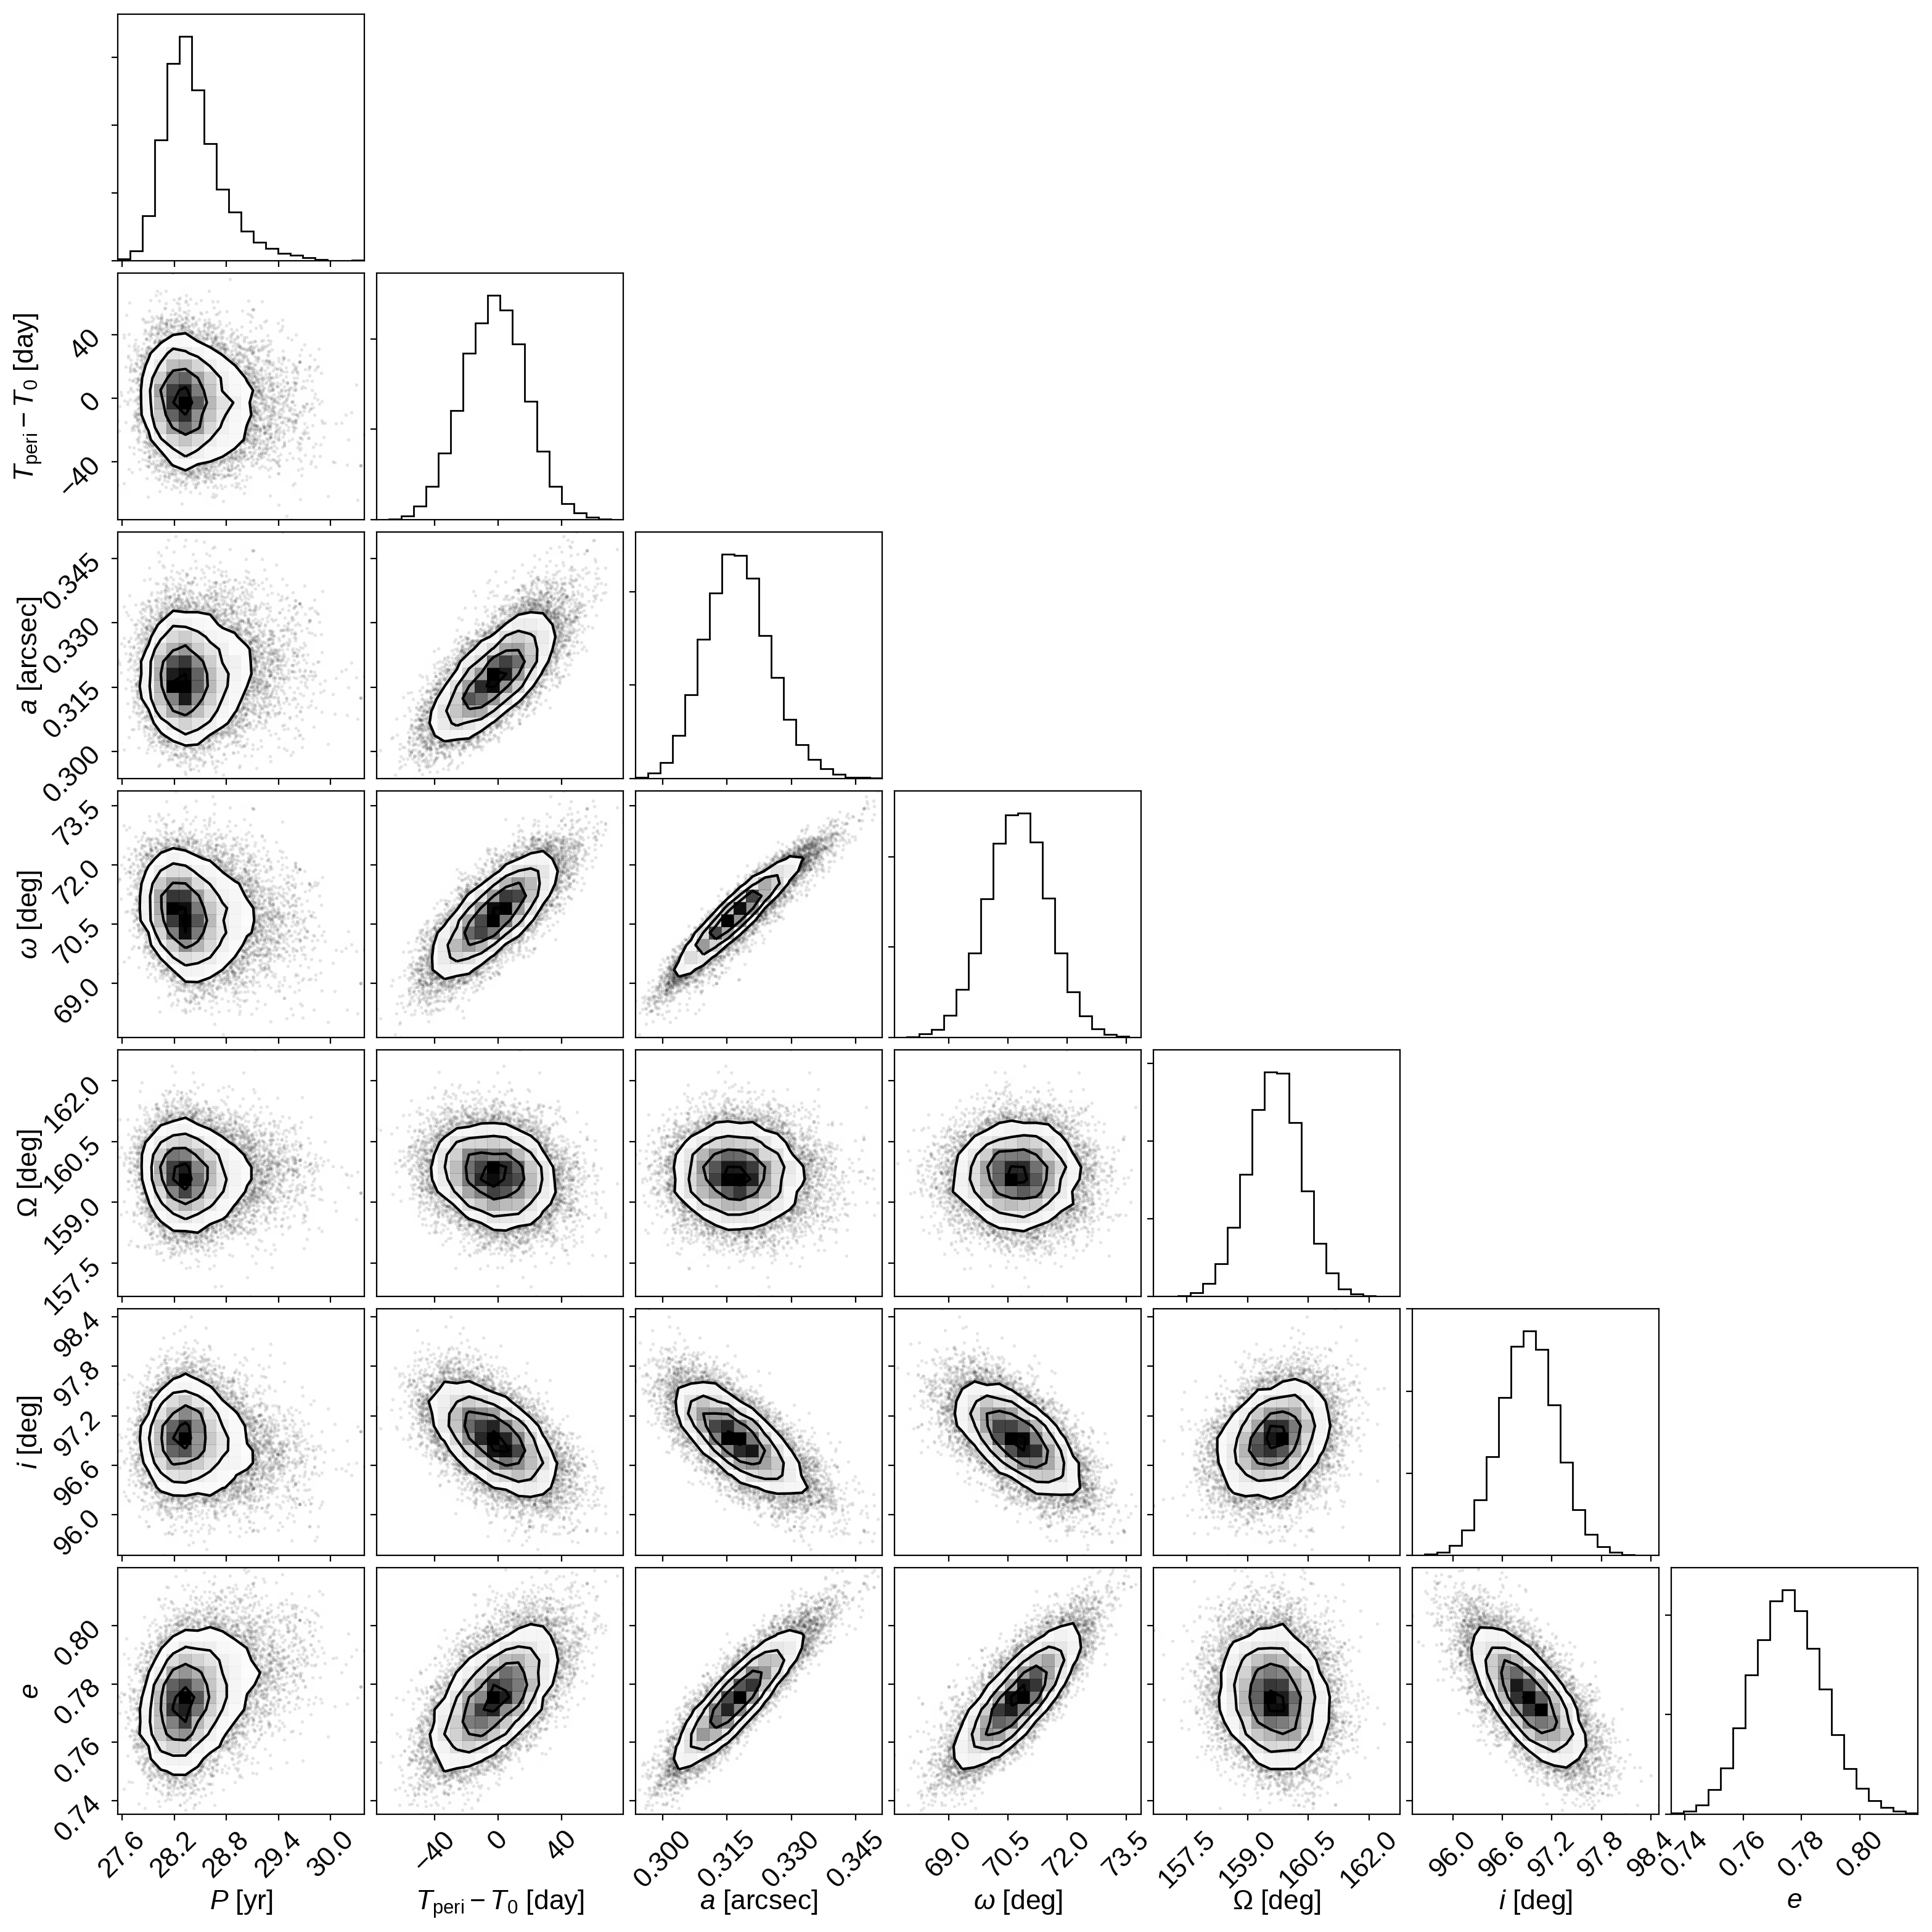

In [12]:
import corner
samples = pm.trace_to_dataframe(trace, varnames=["ecc"])
samples["$P$ [yr]"] = trace["P"] / yr
samples["$T_\mathrm{peri} - T_0$ [day]"] = trace["tperi"] - T0
samples["$a$ [arcsec]"] = trace["a_ang"]
samples["$\omega$ [deg]"] = (trace["omega"] / deg) % 360
samples["$\Omega$ [deg]"] = (trace["Omega"] / deg) % 360
samples["$i$ [deg]"] = (trace["incl"] / deg) % 360
samples["$e$"] = samples["ecc"]
del samples["ecc"]
corner.corner(samples);

Finally, we can plot the posterior constraints on $\rho$ and $\theta$.
This figure is much like the one for the MAP solution above, but this time the orange is a contour (not a line) showing the 68% credible region for the model.

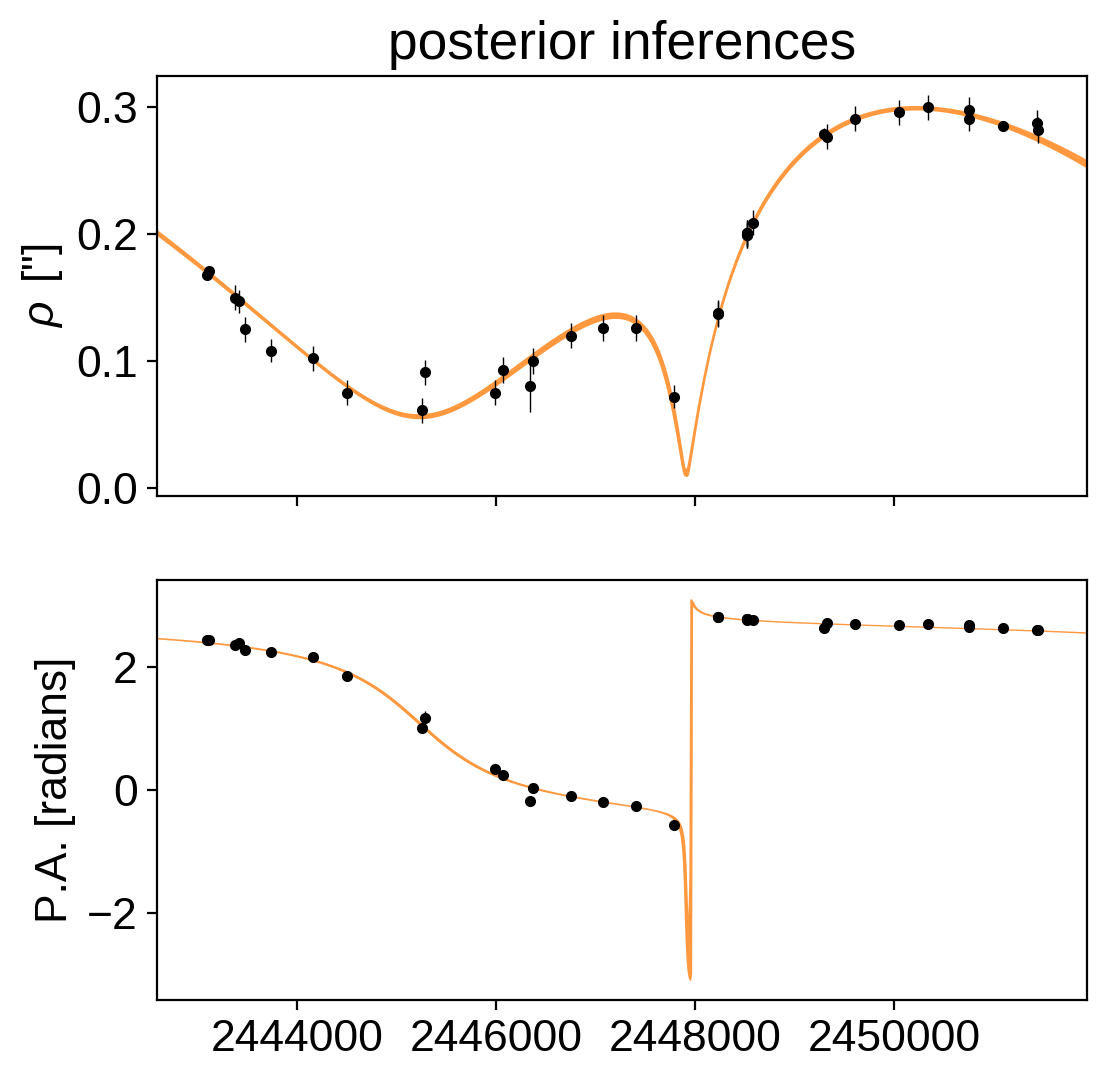

In [13]:
ekw = dict(fmt=".k", lw=0.5)

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r'P.A. [radians]')

tot_rho_err = np.sqrt(rho_err**2 + np.exp(2 * np.median(trace["log_rho_s"], axis=0)))
tot_theta_err = np.sqrt(theta_err**2 + np.exp(2 * np.median(trace["log_theta_s"], axis=0)))

ax[0].errorbar(astro_jds, rho_data, yerr=tot_rho_err, **ekw)
q = np.percentile(trace["rho_save"], [16, 84], axis=0)
ax[0].fill_between(t_fine, q[0], q[1], color="C1", alpha=0.8, lw=0)

ax[1].errorbar(astro_jds, theta_data, yerr=tot_theta_err, **ekw)
q = np.percentile(trace["theta_save"], [16, 84], axis=0)
ax[1].fill_between(t_fine, q[0], q[1], color="C1", alpha=0.8, lw=0)

ax[-1].set_xlim(t_fine[0], t_fine[-1])
ax[0].set_title("posterior inferences");

As we can see from the narrow range of orbits (the orange swath appears like a thin line), the orbit is actually highly constrained by the astrometry.
We also see two outlier epochs in the vicinity of 2445000 - 2447000, since adjacent epochs seem to be right on the orbit.
It's likely the uncertainties were not estimated correctly for these, and the simlplistic jitter model we implemented isn't sophisticated to apply more weight to only these discrepant points.

## Including parallax

While this is encouraging that we fit an astrometric orbit, a simple astrometric fit to just $\rho$ and $\theta$ isn't actually that physically satisfying, since many of the orbital parameters simply have to do with the orientation relative to us ($i$, $\omega$, and $\Omega$). The only truely intrinsic parameters are $P$ and $e$. To learn more about some of the physical parameters, such as the total mass of the system, we'd like to incorporate distance information to put a physical scale to the problem. 

The *Gaia* DR2 parallax is $\varpi = 24.05 \pm 0.45$ mas.

We can use exactly the same model as above with only an added parallax constraint:

In [14]:
plx_model, plx_map_soln = get_model(parallax=[24.05, 0.45])

optimizing logp for variables: ['log_theta_s', 'log_rho_s']


message: Optimization terminated successfully.
logp: 107.6401502957619 -> 149.92860106268094


optimizing logp for variables: ['phase_angle__']


message: Optimization terminated successfully.
logp: 149.92860106268094 -> 170.426815184602


optimizing logp for variables: ['ecc_interval__', 'm_angle__', 'p_angle__']


message: Optimization terminated successfully.
logp: 170.426815184602 -> 212.84801588560703


optimizing logp for variables: ['phase_angle__', 'a_ang_interval__', 'logP']


message: Optimization terminated successfully.
logp: 212.84801588560703 -> 213.28597909410678


optimizing logp for variables: ['log_theta_s', 'log_rho_s', 'ecc_interval__', 'cos_incl_interval__', 'phase_angle__', 'm_angle__', 'p_angle__', 'logP', 'a_ang_interval__', 'm_plx_interval__']


message: Optimization terminated successfully.
logp: 213.28597909410678 -> 217.80586833502502


In [15]:
np.random.seed(5432)
plx_sampler = xo.PyMC3Sampler(start=200, window=100, finish=500)
with plx_model:
    burnin = plx_sampler.tune(tune=4500, start=plx_map_soln,
                          step_kwargs=dict(target_accept=0.9))
    plx_trace = plx_sampler.sample(draws=4000)

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 14/808 [00:00<00:07, 111.82draws/s]

Sampling 4 chains:   3%|▎         | 21/808 [00:00<00:09, 85.22draws/s] 

Sampling 4 chains:   3%|▎         | 27/808 [00:00<00:10, 71.75draws/s]

Sampling 4 chains:   4%|▍         | 34/808 [00:00<00:11, 65.70draws/s]

Sampling 4 chains:   5%|▍         | 40/808 [00:00<00:12, 62.43draws/s]

Sampling 4 chains:   6%|▌         | 47/808 [00:00<00:12, 60.49draws/s]

Sampling 4 chains:   7%|▋         | 53/808 [00:00<00:13, 57.56draws/s]

Sampling 4 chains:   8%|▊         | 61/808 [00:00<00:12, 62.11draws/s]

Sampling 4 chains:   8%|▊         | 67/808 [00:01<00:13, 56.76draws/s]

Sampling 4 chains:   9%|▉         | 76/808 [00:01<00:12, 59.65draws/s]

Sampling 4 chains:  10%|█         | 82/808 [00:01<00:12, 57.79draws/s]

Sampling 4 chains:  11%|█         | 89/808 [00:01<00:12, 56.80draws/s]

Sampling 4 chains:  12%|█▏        | 95/808 [00:01<00:12, 56.40draws/s]

Sampling 4 chains:  12%|█▎        | 101/808 [00:01<00:12, 54.60draws/s]

Sampling 4 chains:  13%|█▎        | 108/808 [00:01<00:12, 56.04draws/s]

Sampling 4 chains:  14%|█▍        | 115/808 [00:01<00:12, 57.59draws/s]

Sampling 4 chains:  15%|█▍        | 121/808 [00:02<00:12, 55.48draws/s]

Sampling 4 chains:  16%|█▌        | 128/808 [00:02<00:11, 57.12draws/s]

Sampling 4 chains:  17%|█▋        | 134/808 [00:02<00:12, 53.63draws/s]

Sampling 4 chains:  17%|█▋        | 140/808 [00:02<00:12, 54.90draws/s]

Sampling 4 chains:  18%|█▊        | 146/808 [00:02<00:11, 56.22draws/s]

Sampling 4 chains:  19%|█▉        | 152/808 [00:02<00:11, 56.01draws/s]

Sampling 4 chains:  20%|█▉        | 158/808 [00:02<00:11, 56.75draws/s]

Sampling 4 chains:  21%|██        | 166/808 [00:02<00:10, 61.38draws/s]

Sampling 4 chains:  21%|██▏       | 173/808 [00:02<00:10, 63.06draws/s]

Sampling 4 chains:  22%|██▏       | 181/808 [00:03<00:10, 61.36draws/s]

Sampling 4 chains:  23%|██▎       | 188/808 [00:03<00:10, 61.15draws/s]

Sampling 4 chains:  24%|██▍       | 195/808 [00:03<00:10, 57.49draws/s]

Sampling 4 chains:  25%|██▍       | 201/808 [00:03<00:10, 55.76draws/s]

Sampling 4 chains:  26%|██▌       | 208/808 [00:03<00:10, 56.26draws/s]

Sampling 4 chains:  27%|██▋       | 216/808 [00:03<00:10, 57.40draws/s]

Sampling 4 chains:  27%|██▋       | 222/808 [00:03<00:10, 56.93draws/s]

Sampling 4 chains:  28%|██▊       | 230/808 [00:03<00:09, 62.07draws/s]

Sampling 4 chains:  29%|██▉       | 237/808 [00:04<00:09, 57.23draws/s]

Sampling 4 chains:  30%|███       | 243/808 [00:04<00:09, 57.61draws/s]

Sampling 4 chains:  31%|███       | 250/808 [00:04<00:09, 57.82draws/s]

Sampling 4 chains:  32%|███▏      | 257/808 [00:04<00:09, 55.54draws/s]

Sampling 4 chains:  33%|███▎      | 263/808 [00:04<00:09, 56.06draws/s]

Sampling 4 chains:  33%|███▎      | 270/808 [00:04<00:09, 56.00draws/s]

Sampling 4 chains:  34%|███▍      | 276/808 [00:04<00:09, 54.62draws/s]

Sampling 4 chains:  35%|███▌      | 283/808 [00:04<00:09, 54.89draws/s]

Sampling 4 chains:  36%|███▌      | 289/808 [00:04<00:09, 55.28draws/s]

Sampling 4 chains:  37%|███▋      | 296/808 [00:05<00:08, 57.41draws/s]

Sampling 4 chains:  37%|███▋      | 302/808 [00:05<00:09, 55.91draws/s]

Sampling 4 chains:  38%|███▊      | 308/808 [00:05<00:09, 55.33draws/s]

Sampling 4 chains:  39%|███▉      | 316/808 [00:05<00:08, 59.54draws/s]

Sampling 4 chains:  40%|███▉      | 323/808 [00:05<00:08, 57.73draws/s]

Sampling 4 chains:  41%|████      | 329/808 [00:05<00:08, 55.15draws/s]

Sampling 4 chains:  41%|████▏     | 335/808 [00:05<00:08, 56.33draws/s]

Sampling 4 chains:  42%|████▏     | 342/808 [00:05<00:07, 59.80draws/s]

Sampling 4 chains:  43%|████▎     | 349/808 [00:05<00:07, 60.42draws/s]

Sampling 4 chains:  44%|████▍     | 356/808 [00:06<00:07, 58.90draws/s]

Sampling 4 chains:  45%|████▌     | 365/808 [00:06<00:06, 63.80draws/s]

Sampling 4 chains:  46%|████▌     | 372/808 [00:06<00:06, 63.94draws/s]

Sampling 4 chains:  47%|████▋     | 379/808 [00:06<00:07, 60.17draws/s]

Sampling 4 chains:  48%|████▊     | 386/808 [00:06<00:07, 58.24draws/s]

Sampling 4 chains:  49%|████▊     | 392/808 [00:06<00:07, 56.92draws/s]

Sampling 4 chains:  49%|████▉     | 398/808 [00:06<00:07, 54.38draws/s]

Sampling 4 chains:  50%|█████     | 406/808 [00:06<00:06, 59.12draws/s]

Sampling 4 chains:  51%|█████     | 413/808 [00:07<00:07, 54.08draws/s]

Sampling 4 chains:  52%|█████▏    | 421/808 [00:07<00:06, 57.62draws/s]

Sampling 4 chains:  53%|█████▎    | 428/808 [00:07<00:06, 60.77draws/s]

Sampling 4 chains:  54%|█████▍    | 436/808 [00:07<00:05, 64.77draws/s]

Sampling 4 chains:  55%|█████▍    | 443/808 [00:07<00:06, 58.81draws/s]

Sampling 4 chains:  56%|█████▌    | 452/808 [00:07<00:05, 61.71draws/s]

Sampling 4 chains:  57%|█████▋    | 459/808 [00:07<00:05, 60.25draws/s]

Sampling 4 chains:  58%|█████▊    | 466/808 [00:07<00:06, 55.35draws/s]

Sampling 4 chains:  58%|█████▊    | 472/808 [00:08<00:06, 53.69draws/s]

Sampling 4 chains:  59%|█████▉    | 479/808 [00:08<00:05, 57.08draws/s]

Sampling 4 chains:  60%|██████    | 487/808 [00:08<00:05, 56.79draws/s]

Sampling 4 chains:  61%|██████    | 493/808 [00:08<00:05, 57.44draws/s]

Sampling 4 chains:  62%|██████▏   | 501/808 [00:08<00:05, 59.31draws/s]

Sampling 4 chains:  63%|██████▎   | 508/808 [00:08<00:05, 58.22draws/s]

Sampling 4 chains:  64%|██████▎   | 514/808 [00:08<00:05, 58.18draws/s]

Sampling 4 chains:  64%|██████▍   | 521/808 [00:08<00:04, 61.01draws/s]

Sampling 4 chains:  65%|██████▌   | 528/808 [00:09<00:05, 55.01draws/s]

Sampling 4 chains:  66%|██████▌   | 535/808 [00:09<00:04, 57.49draws/s]

Sampling 4 chains:  67%|██████▋   | 541/808 [00:09<00:04, 54.14draws/s]

Sampling 4 chains:  68%|██████▊   | 547/808 [00:09<00:04, 55.26draws/s]

Sampling 4 chains:  68%|██████▊   | 553/808 [00:09<00:04, 52.82draws/s]

Sampling 4 chains:  69%|██████▉   | 560/808 [00:09<00:04, 55.22draws/s]

Sampling 4 chains:  70%|███████   | 566/808 [00:09<00:04, 53.20draws/s]

Sampling 4 chains:  71%|███████   | 572/808 [00:09<00:04, 53.51draws/s]

Sampling 4 chains:  72%|███████▏  | 578/808 [00:09<00:04, 52.34draws/s]

Sampling 4 chains:  72%|███████▏  | 585/808 [00:10<00:03, 56.26draws/s]

Sampling 4 chains:  73%|███████▎  | 591/808 [00:10<00:04, 50.12draws/s]

Sampling 4 chains:  74%|███████▍  | 597/808 [00:10<00:04, 51.92draws/s]

Sampling 4 chains:  75%|███████▍  | 603/808 [00:10<00:03, 51.97draws/s]

Sampling 4 chains:  75%|███████▌  | 609/808 [00:10<00:03, 53.53draws/s]

Sampling 4 chains:  76%|███████▌  | 616/808 [00:10<00:03, 55.13draws/s]

Sampling 4 chains:  77%|███████▋  | 622/808 [00:10<00:03, 54.24draws/s]

Sampling 4 chains:  78%|███████▊  | 630/808 [00:10<00:03, 58.03draws/s]

Sampling 4 chains:  79%|███████▊  | 636/808 [00:10<00:03, 53.39draws/s]

Sampling 4 chains:  79%|███████▉  | 642/808 [00:11<00:03, 54.40draws/s]

Sampling 4 chains:  80%|████████  | 648/808 [00:11<00:02, 53.65draws/s]

Sampling 4 chains:  81%|████████  | 655/808 [00:11<00:02, 56.91draws/s]

Sampling 4 chains:  82%|████████▏ | 661/808 [00:11<00:02, 55.80draws/s]

Sampling 4 chains:  83%|████████▎ | 669/808 [00:11<00:02, 60.48draws/s]

Sampling 4 chains:  84%|████████▎ | 676/808 [00:11<00:02, 57.32draws/s]

Sampling 4 chains:  85%|████████▍ | 683/808 [00:11<00:02, 57.65draws/s]

Sampling 4 chains:  85%|████████▌ | 689/808 [00:11<00:02, 55.74draws/s]

Sampling 4 chains:  86%|████████▋ | 697/808 [00:12<00:01, 59.21draws/s]

Sampling 4 chains:  87%|████████▋ | 704/808 [00:12<00:01, 59.23draws/s]

Sampling 4 chains:  88%|████████▊ | 711/808 [00:12<00:01, 61.35draws/s]

Sampling 4 chains:  89%|████████▉ | 718/808 [00:12<00:01, 62.53draws/s]

Sampling 4 chains:  90%|████████▉ | 725/808 [00:12<00:01, 60.02draws/s]

Sampling 4 chains:  91%|█████████ | 733/808 [00:12<00:01, 56.95draws/s]

Sampling 4 chains:  92%|█████████▏| 742/808 [00:12<00:01, 56.87draws/s]

Sampling 4 chains:  93%|█████████▎| 751/808 [00:12<00:00, 61.91draws/s]

Sampling 4 chains:  94%|█████████▍| 758/808 [00:13<00:00, 59.08draws/s]

Sampling 4 chains:  95%|█████████▍| 765/808 [00:13<00:00, 55.99draws/s]

Sampling 4 chains:  96%|█████████▌| 772/808 [00:13<00:00, 53.66draws/s]

Sampling 4 chains:  96%|█████████▋| 779/808 [00:13<00:00, 57.03draws/s]

Sampling 4 chains:  97%|█████████▋| 785/808 [00:13<00:00, 57.72draws/s]

Sampling 4 chains:  98%|█████████▊| 791/808 [00:13<00:00, 55.45draws/s]

Sampling 4 chains:  99%|█████████▊| 797/808 [00:13<00:00, 47.43draws/s]

Sampling 4 chains:  99%|█████████▉| 803/808 [00:13<00:00, 46.77draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:14<00:00, 30.35draws/s]

Sampling 4 chains:   0%|          | 0/408 [00:00<?, ?draws/s]

Sampling 4 chains:   3%|▎         | 13/408 [00:00<00:04, 95.02draws/s]

Sampling 4 chains:   5%|▌         | 21/408 [00:00<00:05, 74.96draws/s]

Sampling 4 chains:   7%|▋         | 29/408 [00:00<00:04, 76.27draws/s]

Sampling 4 chains:   9%|▉         | 36/408 [00:00<00:05, 69.43draws/s]

Sampling 4 chains:  11%|█         | 43/408 [00:00<00:05, 63.02draws/s]

Sampling 4 chains:  12%|█▎        | 51/408 [00:00<00:05, 67.26draws/s]

Sampling 4 chains:  14%|█▍        | 58/408 [00:00<00:05, 67.70draws/s]

Sampling 4 chains:  16%|█▌        | 65/408 [00:00<00:05, 61.56draws/s]

Sampling 4 chains:  18%|█▊        | 73/408 [00:01<00:05, 59.50draws/s]

Sampling 4 chains:  20%|█▉        | 81/408 [00:01<00:05, 64.21draws/s]

Sampling 4 chains:  22%|██▏       | 88/408 [00:01<00:05, 57.88draws/s]

Sampling 4 chains:  24%|██▍       | 98/408 [00:01<00:04, 63.84draws/s]

Sampling 4 chains:  26%|██▌       | 106/408 [00:01<00:04, 62.97draws/s]

Sampling 4 chains:  28%|██▊       | 113/408 [00:01<00:04, 62.94draws/s]

Sampling 4 chains:  30%|██▉       | 121/408 [00:01<00:04, 66.29draws/s]

Sampling 4 chains:  31%|███▏      | 128/408 [00:01<00:04, 63.64draws/s]

Sampling 4 chains:  33%|███▎      | 136/408 [00:02<00:04, 65.37draws/s]

Sampling 4 chains:  35%|███▌      | 143/408 [00:02<00:04, 63.81draws/s]

Sampling 4 chains:  37%|███▋      | 151/408 [00:02<00:04, 63.88draws/s]

Sampling 4 chains:  39%|███▉      | 159/408 [00:02<00:03, 65.78draws/s]

Sampling 4 chains:  41%|████      | 167/408 [00:02<00:03, 66.48draws/s]

Sampling 4 chains:  43%|████▎     | 175/408 [00:02<00:03, 67.58draws/s]

Sampling 4 chains:  45%|████▌     | 184/408 [00:02<00:03, 69.85draws/s]

Sampling 4 chains:  47%|████▋     | 193/408 [00:02<00:02, 74.55draws/s]

Sampling 4 chains:  49%|████▉     | 201/408 [00:03<00:03, 68.53draws/s]

Sampling 4 chains:  51%|█████     | 209/408 [00:03<00:02, 68.08draws/s]

Sampling 4 chains:  54%|█████▎    | 219/408 [00:03<00:02, 72.47draws/s]

Sampling 4 chains:  56%|█████▌    | 227/408 [00:03<00:02, 70.87draws/s]

Sampling 4 chains:  58%|█████▊    | 235/408 [00:03<00:02, 68.28draws/s]

Sampling 4 chains:  60%|██████    | 245/408 [00:03<00:02, 72.97draws/s]

Sampling 4 chains:  62%|██████▏   | 253/408 [00:03<00:02, 66.49draws/s]

Sampling 4 chains:  64%|██████▍   | 262/408 [00:03<00:02, 71.34draws/s]

Sampling 4 chains:  66%|██████▌   | 270/408 [00:04<00:02, 68.23draws/s]

Sampling 4 chains:  69%|██████▊   | 280/408 [00:04<00:01, 70.05draws/s]

Sampling 4 chains:  71%|███████   | 288/408 [00:04<00:01, 72.44draws/s]

Sampling 4 chains:  73%|███████▎  | 296/408 [00:04<00:01, 71.56draws/s]

Sampling 4 chains:  75%|███████▍  | 304/408 [00:04<00:01, 69.86draws/s]

Sampling 4 chains:  76%|███████▋  | 312/408 [00:04<00:01, 66.05draws/s]

Sampling 4 chains:  79%|███████▊  | 321/408 [00:04<00:01, 69.80draws/s]

Sampling 4 chains:  81%|████████  | 329/408 [00:04<00:01, 68.49draws/s]

Sampling 4 chains:  83%|████████▎ | 337/408 [00:04<00:01, 70.11draws/s]

Sampling 4 chains:  85%|████████▍ | 346/408 [00:05<00:00, 73.76draws/s]

Sampling 4 chains:  87%|████████▋ | 354/408 [00:05<00:00, 74.40draws/s]

Sampling 4 chains:  89%|████████▉ | 364/408 [00:05<00:00, 77.18draws/s]

Sampling 4 chains:  92%|█████████▏| 375/408 [00:05<00:00, 84.01draws/s]

Sampling 4 chains:  94%|█████████▍| 384/408 [00:05<00:00, 78.61draws/s]

Sampling 4 chains:  96%|█████████▋| 393/408 [00:05<00:00, 64.89draws/s]

Sampling 4 chains:  98%|█████████▊| 401/408 [00:05<00:00, 56.40draws/s]

Sampling 4 chains: 100%|██████████| 408/408 [00:06<00:00, 40.55draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   5%|▍         | 40/808 [00:00<00:01, 397.23draws/s]

Sampling 4 chains:  13%|█▎        | 102/808 [00:00<00:01, 442.48draws/s]

Sampling 4 chains:  20%|█▉        | 158/808 [00:00<00:01, 470.28draws/s]

Sampling 4 chains:  26%|██▌       | 209/808 [00:00<00:01, 479.89draws/s]

Sampling 4 chains:  34%|███▎      | 271/808 [00:00<00:01, 514.58draws/s]

Sampling 4 chains:  41%|████▏     | 335/808 [00:00<00:00, 544.74draws/s]

Sampling 4 chains:  49%|████▉     | 394/808 [00:00<00:00, 557.28draws/s]

Sampling 4 chains:  57%|█████▋    | 457/808 [00:00<00:00, 577.11draws/s]

Sampling 4 chains:  64%|██████▍   | 518/808 [00:00<00:00, 584.34draws/s]

Sampling 4 chains:  72%|███████▏  | 585/808 [00:01<00:00, 605.73draws/s]

Sampling 4 chains:  80%|████████  | 648/808 [00:01<00:00, 612.72draws/s]

Sampling 4 chains:  88%|████████▊ | 709/808 [00:01<00:00, 611.64draws/s]

Sampling 4 chains:  96%|█████████▌| 773/808 [00:01<00:00, 587.90draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:01<00:00, 529.95draws/s]

Sampling 4 chains:   0%|          | 0/1608 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 36/1608 [00:00<00:04, 347.30draws/s]

Sampling 4 chains:   4%|▍         | 63/1608 [00:00<00:04, 315.62draws/s]

Sampling 4 chains:   6%|▌         | 94/1608 [00:00<00:04, 310.03draws/s]

Sampling 4 chains:   7%|▋         | 114/1608 [00:00<00:05, 257.43draws/s]

Sampling 4 chains:  10%|▉         | 153/1608 [00:00<00:05, 285.16draws/s]

Sampling 4 chains:  12%|█▏        | 196/1608 [00:00<00:04, 315.35draws/s]

Sampling 4 chains:  14%|█▍        | 229/1608 [00:00<00:04, 319.43draws/s]

Sampling 4 chains:  16%|█▋        | 264/1608 [00:00<00:04, 325.31draws/s]

Sampling 4 chains:  19%|█▉        | 305/1608 [00:00<00:03, 345.25draws/s]

Sampling 4 chains:  22%|██▏       | 358/1608 [00:01<00:03, 382.73draws/s]

Sampling 4 chains:  25%|██▍       | 398/1608 [00:01<00:03, 381.98draws/s]

Sampling 4 chains:  28%|██▊       | 447/1608 [00:01<00:02, 407.23draws/s]

Sampling 4 chains:  31%|███       | 500/1608 [00:01<00:02, 436.46draws/s]

Sampling 4 chains:  35%|███▍      | 559/1608 [00:01<00:02, 472.17draws/s]

Sampling 4 chains:  38%|███▊      | 612/1608 [00:01<00:02, 487.72draws/s]

Sampling 4 chains:  41%|████      | 663/1608 [00:01<00:01, 492.38draws/s]

Sampling 4 chains:  44%|████▍     | 714/1608 [00:01<00:01, 478.31draws/s]

Sampling 4 chains:  48%|████▊     | 770/1608 [00:01<00:01, 498.99draws/s]

Sampling 4 chains:  51%|█████     | 821/1608 [00:01<00:01, 493.64draws/s]

Sampling 4 chains:  55%|█████▍    | 879/1608 [00:02<00:01, 515.74draws/s]

Sampling 4 chains:  58%|█████▊    | 938/1608 [00:02<00:01, 534.18draws/s]

Sampling 4 chains:  62%|██████▏   | 994/1608 [00:02<00:01, 539.29draws/s]

Sampling 4 chains:  65%|██████▌   | 1049/1608 [00:02<00:01, 524.00draws/s]

Sampling 4 chains:  69%|██████▉   | 1110/1608 [00:02<00:00, 547.06draws/s]

Sampling 4 chains:  73%|███████▎  | 1172/1608 [00:02<00:00, 565.59draws/s]

Sampling 4 chains:  76%|███████▋  | 1230/1608 [00:02<00:00, 561.69draws/s]

Sampling 4 chains:  80%|████████  | 1287/1608 [00:02<00:00, 537.75draws/s]

Sampling 4 chains:  83%|████████▎ | 1342/1608 [00:02<00:00, 515.57draws/s]

Sampling 4 chains:  87%|████████▋ | 1395/1608 [00:03<00:00, 493.38draws/s]

Sampling 4 chains:  90%|████████▉ | 1445/1608 [00:03<00:00, 488.87draws/s]

Sampling 4 chains:  94%|█████████▎| 1506/1608 [00:03<00:00, 517.85draws/s]

Sampling 4 chains:  97%|█████████▋| 1559/1608 [00:03<00:00, 443.38draws/s]

Sampling 4 chains: 100%|█████████▉| 1606/1608 [00:03<00:00, 304.96draws/s]

Sampling 4 chains: 100%|██████████| 1608/1608 [00:03<00:00, 433.82draws/s]

Sampling 4 chains:   0%|          | 0/3208 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 30/3208 [00:00<00:10, 299.51draws/s]

Sampling 4 chains:   2%|▏         | 59/3208 [00:00<00:10, 293.80draws/s]

Sampling 4 chains:   3%|▎         | 89/3208 [00:00<00:10, 292.73draws/s]

Sampling 4 chains:   4%|▎         | 115/3208 [00:00<00:11, 278.45draws/s]

Sampling 4 chains:   5%|▍         | 147/3208 [00:00<00:10, 286.93draws/s]

Sampling 4 chains:   5%|▌         | 171/3208 [00:00<00:11, 271.01draws/s]

Sampling 4 chains:   7%|▋         | 212/3208 [00:00<00:09, 301.46draws/s]

Sampling 4 chains:   8%|▊         | 245/3208 [00:00<00:09, 305.49draws/s]

Sampling 4 chains:   9%|▊         | 280/3208 [00:00<00:09, 315.63draws/s]

Sampling 4 chains:  10%|█         | 324/3208 [00:01<00:08, 344.03draws/s]

Sampling 4 chains:  12%|█▏        | 370/3208 [00:01<00:07, 371.55draws/s]

Sampling 4 chains:  13%|█▎        | 426/3208 [00:01<00:06, 412.51draws/s]

Sampling 4 chains:  15%|█▍        | 478/3208 [00:01<00:06, 438.44draws/s]

Sampling 4 chains:  16%|█▋        | 527/3208 [00:01<00:05, 452.45draws/s]

Sampling 4 chains:  18%|█▊        | 574/3208 [00:01<00:06, 436.90draws/s]

Sampling 4 chains:  19%|█▉        | 619/3208 [00:01<00:05, 435.48draws/s]

Sampling 4 chains:  21%|██        | 664/3208 [00:01<00:05, 430.09draws/s]

Sampling 4 chains:  22%|██▏       | 712/3208 [00:01<00:05, 443.32draws/s]

Sampling 4 chains:  24%|██▍       | 762/3208 [00:01<00:05, 458.90draws/s]

Sampling 4 chains:  25%|██▌       | 815/3208 [00:02<00:05, 477.14draws/s]

Sampling 4 chains:  27%|██▋       | 864/3208 [00:02<00:05, 462.86draws/s]

Sampling 4 chains:  29%|██▊       | 916/3208 [00:02<00:04, 478.26draws/s]

Sampling 4 chains:  30%|███       | 965/3208 [00:02<00:04, 449.84draws/s]

Sampling 4 chains:  32%|███▏      | 1012/3208 [00:02<00:04, 452.64draws/s]

Sampling 4 chains:  33%|███▎      | 1070/3208 [00:02<00:04, 483.91draws/s]

Sampling 4 chains:  35%|███▍      | 1121/3208 [00:02<00:04, 491.15draws/s]

Sampling 4 chains:  37%|███▋      | 1172/3208 [00:02<00:04, 494.46draws/s]

Sampling 4 chains:  38%|███▊      | 1222/3208 [00:02<00:04, 474.04draws/s]

Sampling 4 chains:  40%|███▉      | 1270/3208 [00:03<00:04, 474.91draws/s]

Sampling 4 chains:  41%|████▏     | 1330/3208 [00:03<00:03, 505.71draws/s]

Sampling 4 chains:  43%|████▎     | 1382/3208 [00:03<00:03, 502.35draws/s]

Sampling 4 chains:  45%|████▍     | 1433/3208 [00:03<00:03, 488.17draws/s]

Sampling 4 chains:  46%|████▋     | 1485/3208 [00:03<00:03, 493.51draws/s]

Sampling 4 chains:  48%|████▊     | 1536/3208 [00:03<00:03, 497.42draws/s]

Sampling 4 chains:  49%|████▉     | 1587/3208 [00:03<00:03, 494.13draws/s]

Sampling 4 chains:  51%|█████     | 1637/3208 [00:03<00:03, 490.04draws/s]

Sampling 4 chains:  53%|█████▎    | 1687/3208 [00:03<00:03, 473.27draws/s]

Sampling 4 chains:  54%|█████▍    | 1735/3208 [00:03<00:03, 469.15draws/s]

Sampling 4 chains:  56%|█████▌    | 1783/3208 [00:04<00:03, 445.52draws/s]

Sampling 4 chains:  57%|█████▋    | 1832/3208 [00:04<00:03, 456.66draws/s]

Sampling 4 chains:  59%|█████▉    | 1890/3208 [00:04<00:02, 486.02draws/s]

Sampling 4 chains:  61%|██████    | 1948/3208 [00:04<00:02, 510.42draws/s]

Sampling 4 chains:  62%|██████▏   | 2002/3208 [00:04<00:02, 516.11draws/s]

Sampling 4 chains:  64%|██████▍   | 2056/3208 [00:04<00:02, 522.84draws/s]

Sampling 4 chains:  66%|██████▌   | 2109/3208 [00:04<00:02, 513.54draws/s]

Sampling 4 chains:  67%|██████▋   | 2161/3208 [00:04<00:02, 473.57draws/s]

Sampling 4 chains:  69%|██████▉   | 2211/3208 [00:04<00:02, 479.79draws/s]

Sampling 4 chains:  71%|███████   | 2263/3208 [00:05<00:01, 490.39draws/s]

Sampling 4 chains:  72%|███████▏  | 2314/3208 [00:05<00:01, 494.30draws/s]

Sampling 4 chains:  74%|███████▍  | 2368/3208 [00:05<00:01, 503.41draws/s]

Sampling 4 chains:  75%|███████▌  | 2419/3208 [00:05<00:01, 501.41draws/s]

Sampling 4 chains:  77%|███████▋  | 2472/3208 [00:05<00:01, 506.26draws/s]

Sampling 4 chains:  79%|███████▊  | 2523/3208 [00:05<00:01, 485.24draws/s]

Sampling 4 chains:  80%|████████  | 2572/3208 [00:05<00:01, 480.68draws/s]

Sampling 4 chains:  82%|████████▏ | 2622/3208 [00:05<00:01, 485.39draws/s]

Sampling 4 chains:  83%|████████▎ | 2675/3208 [00:05<00:01, 496.59draws/s]

Sampling 4 chains:  85%|████████▌ | 2731/3208 [00:05<00:00, 513.72draws/s]

Sampling 4 chains:  87%|████████▋ | 2791/3208 [00:06<00:00, 536.54draws/s]

Sampling 4 chains:  89%|████████▊ | 2846/3208 [00:06<00:00, 479.67draws/s]

Sampling 4 chains:  90%|█████████ | 2896/3208 [00:06<00:00, 477.92draws/s]

Sampling 4 chains:  92%|█████████▏| 2950/3208 [00:06<00:00, 494.68draws/s]

Sampling 4 chains:  94%|█████████▎| 3002/3208 [00:06<00:00, 500.58draws/s]

Sampling 4 chains:  95%|█████████▌| 3053/3208 [00:06<00:00, 430.89draws/s]

Sampling 4 chains:  97%|█████████▋| 3099/3208 [00:06<00:00, 404.13draws/s]

Sampling 4 chains:  98%|█████████▊| 3142/3208 [00:06<00:00, 374.35draws/s]

Sampling 4 chains:  99%|█████████▉| 3182/3208 [00:07<00:00, 319.39draws/s]

Sampling 4 chains: 100%|██████████| 3208/3208 [00:07<00:00, 440.45draws/s]

Sampling 4 chains:   0%|          | 0/11208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 35/11208 [00:00<00:33, 336.19draws/s]

Sampling 4 chains:   1%|          | 75/11208 [00:00<00:31, 352.43draws/s]

Sampling 4 chains:   1%|          | 98/11208 [00:00<00:36, 301.46draws/s]

Sampling 4 chains:   1%|          | 131/11208 [00:00<00:35, 309.11draws/s]

Sampling 4 chains:   2%|▏         | 169/11208 [00:00<00:33, 326.54draws/s]

Sampling 4 chains:   2%|▏         | 214/11208 [00:00<00:30, 354.87draws/s]

Sampling 4 chains:   2%|▏         | 253/11208 [00:00<00:30, 363.54draws/s]

Sampling 4 chains:   3%|▎         | 297/11208 [00:00<00:28, 383.41draws/s]

Sampling 4 chains:   3%|▎         | 348/11208 [00:00<00:26, 410.27draws/s]

Sampling 4 chains:   3%|▎         | 389/11208 [00:01<00:27, 400.27draws/s]

Sampling 4 chains:   4%|▍         | 433/11208 [00:01<00:26, 411.33draws/s]

Sampling 4 chains:   4%|▍         | 477/11208 [00:01<00:25, 416.03draws/s]

Sampling 4 chains:   5%|▍         | 526/11208 [00:01<00:24, 433.68draws/s]

Sampling 4 chains:   5%|▌         | 570/11208 [00:01<00:24, 435.38draws/s]

Sampling 4 chains:   6%|▌         | 621/11208 [00:01<00:23, 453.61draws/s]

Sampling 4 chains:   6%|▌         | 667/11208 [00:01<00:24, 437.83draws/s]

Sampling 4 chains:   6%|▋         | 712/11208 [00:01<00:24, 433.79draws/s]

Sampling 4 chains:   7%|▋         | 756/11208 [00:01<00:25, 407.60draws/s]

Sampling 4 chains:   7%|▋         | 812/11208 [00:01<00:23, 443.19draws/s]

Sampling 4 chains:   8%|▊         | 865/11208 [00:02<00:22, 465.42draws/s]

Sampling 4 chains:   8%|▊         | 913/11208 [00:02<00:23, 443.84draws/s]

Sampling 4 chains:   9%|▊         | 959/11208 [00:02<00:23, 445.36draws/s]

Sampling 4 chains:   9%|▉         | 1007/11208 [00:02<00:22, 453.52draws/s]

Sampling 4 chains:   9%|▉         | 1055/11208 [00:02<00:22, 459.17draws/s]

Sampling 4 chains:  10%|▉         | 1104/11208 [00:02<00:21, 466.42draws/s]

Sampling 4 chains:  10%|█         | 1156/11208 [00:02<00:20, 480.67draws/s]

Sampling 4 chains:  11%|█         | 1205/11208 [00:02<00:21, 474.93draws/s]

Sampling 4 chains:  11%|█         | 1253/11208 [00:02<00:21, 463.01draws/s]

Sampling 4 chains:  12%|█▏        | 1305/11208 [00:03<00:20, 477.13draws/s]

Sampling 4 chains:  12%|█▏        | 1353/11208 [00:03<00:20, 476.53draws/s]

Sampling 4 chains:  12%|█▎        | 1401/11208 [00:03<00:20, 468.55draws/s]

Sampling 4 chains:  13%|█▎        | 1456/11208 [00:03<00:20, 487.16draws/s]

Sampling 4 chains:  13%|█▎        | 1511/11208 [00:03<00:19, 500.47draws/s]

Sampling 4 chains:  14%|█▍        | 1562/11208 [00:03<00:19, 491.52draws/s]

Sampling 4 chains:  14%|█▍        | 1612/11208 [00:03<00:19, 487.12draws/s]

Sampling 4 chains:  15%|█▍        | 1663/11208 [00:03<00:19, 493.36draws/s]

Sampling 4 chains:  15%|█▌        | 1716/11208 [00:03<00:18, 502.63draws/s]

Sampling 4 chains:  16%|█▌        | 1768/11208 [00:03<00:18, 506.02draws/s]

Sampling 4 chains:  16%|█▌        | 1819/11208 [00:04<00:19, 493.51draws/s]

Sampling 4 chains:  17%|█▋        | 1870/11208 [00:04<00:18, 497.33draws/s]

Sampling 4 chains:  17%|█▋        | 1920/11208 [00:04<00:19, 478.24draws/s]

Sampling 4 chains:  18%|█▊        | 1969/11208 [00:04<00:19, 465.72draws/s]

Sampling 4 chains:  18%|█▊        | 2022/11208 [00:04<00:19, 481.44draws/s]

Sampling 4 chains:  19%|█▊        | 2075/11208 [00:04<00:18, 492.17draws/s]

Sampling 4 chains:  19%|█▉        | 2125/11208 [00:04<00:19, 477.38draws/s]

Sampling 4 chains:  20%|█▉        | 2187/11208 [00:04<00:17, 507.76draws/s]

Sampling 4 chains:  20%|██        | 2244/11208 [00:04<00:17, 524.93draws/s]

Sampling 4 chains:  21%|██        | 2298/11208 [00:05<00:17, 520.97draws/s]

Sampling 4 chains:  21%|██        | 2351/11208 [00:05<00:17, 507.54draws/s]

Sampling 4 chains:  21%|██▏       | 2403/11208 [00:05<00:17, 505.91draws/s]

Sampling 4 chains:  22%|██▏       | 2456/11208 [00:05<00:17, 511.08draws/s]

Sampling 4 chains:  22%|██▏       | 2519/11208 [00:05<00:16, 536.88draws/s]

Sampling 4 chains:  23%|██▎       | 2575/11208 [00:05<00:15, 541.62draws/s]

Sampling 4 chains:  24%|██▎       | 2636/11208 [00:05<00:15, 555.86draws/s]

Sampling 4 chains:  24%|██▍       | 2692/11208 [00:05<00:15, 555.54draws/s]

Sampling 4 chains:  25%|██▍       | 2748/11208 [00:05<00:15, 531.22draws/s]

Sampling 4 chains:  25%|██▌       | 2802/11208 [00:05<00:16, 521.19draws/s]

Sampling 4 chains:  25%|██▌       | 2855/11208 [00:06<00:16, 503.71draws/s]

Sampling 4 chains:  26%|██▌       | 2906/11208 [00:06<00:16, 499.30draws/s]

Sampling 4 chains:  26%|██▋       | 2959/11208 [00:06<00:16, 502.76draws/s]

Sampling 4 chains:  27%|██▋       | 3010/11208 [00:06<00:16, 485.79draws/s]

Sampling 4 chains:  27%|██▋       | 3062/11208 [00:06<00:16, 494.62draws/s]

Sampling 4 chains:  28%|██▊       | 3115/11208 [00:06<00:16, 503.52draws/s]

Sampling 4 chains:  28%|██▊       | 3175/11208 [00:06<00:15, 528.61draws/s]

Sampling 4 chains:  29%|██▉       | 3229/11208 [00:06<00:15, 503.52draws/s]

Sampling 4 chains:  29%|██▉       | 3280/11208 [00:06<00:16, 494.86draws/s]

Sampling 4 chains:  30%|██▉       | 3333/11208 [00:07<00:15, 504.51draws/s]

Sampling 4 chains:  30%|███       | 3385/11208 [00:07<00:15, 506.99draws/s]

Sampling 4 chains:  31%|███       | 3437/11208 [00:07<00:15, 508.65draws/s]

Sampling 4 chains:  31%|███       | 3489/11208 [00:07<00:15, 485.13draws/s]

Sampling 4 chains:  32%|███▏      | 3544/11208 [00:07<00:15, 498.37draws/s]

Sampling 4 chains:  32%|███▏      | 3598/11208 [00:07<00:15, 506.45draws/s]

Sampling 4 chains:  33%|███▎      | 3653/11208 [00:07<00:14, 518.07draws/s]

Sampling 4 chains:  33%|███▎      | 3706/11208 [00:07<00:15, 482.56draws/s]

Sampling 4 chains:  34%|███▎      | 3755/11208 [00:07<00:16, 462.83draws/s]

Sampling 4 chains:  34%|███▍      | 3809/11208 [00:07<00:15, 481.73draws/s]

Sampling 4 chains:  34%|███▍      | 3861/11208 [00:08<00:15, 486.16draws/s]

Sampling 4 chains:  35%|███▍      | 3916/11208 [00:08<00:14, 503.18draws/s]

Sampling 4 chains:  35%|███▌      | 3967/11208 [00:08<00:14, 505.17draws/s]

Sampling 4 chains:  36%|███▌      | 4018/11208 [00:08<00:14, 489.60draws/s]

Sampling 4 chains:  36%|███▋      | 4068/11208 [00:08<00:14, 483.60draws/s]

Sampling 4 chains:  37%|███▋      | 4117/11208 [00:08<00:15, 467.00draws/s]

Sampling 4 chains:  37%|███▋      | 4167/11208 [00:08<00:14, 472.85draws/s]

Sampling 4 chains:  38%|███▊      | 4216/11208 [00:08<00:14, 476.20draws/s]

Sampling 4 chains:  38%|███▊      | 4264/11208 [00:08<00:14, 470.77draws/s]

Sampling 4 chains:  38%|███▊      | 4312/11208 [00:09<00:14, 469.64draws/s]

Sampling 4 chains:  39%|███▉      | 4360/11208 [00:09<00:14, 461.55draws/s]

Sampling 4 chains:  39%|███▉      | 4407/11208 [00:09<00:14, 458.34draws/s]

Sampling 4 chains:  40%|███▉      | 4460/11208 [00:09<00:14, 477.43draws/s]

Sampling 4 chains:  40%|████      | 4508/11208 [00:09<00:14, 471.68draws/s]

Sampling 4 chains:  41%|████      | 4562/11208 [00:09<00:13, 488.87draws/s]

Sampling 4 chains:  41%|████      | 4613/11208 [00:09<00:13, 493.56draws/s]

Sampling 4 chains:  42%|████▏     | 4663/11208 [00:09<00:13, 491.57draws/s]

Sampling 4 chains:  42%|████▏     | 4715/11208 [00:09<00:13, 496.52draws/s]

Sampling 4 chains:  43%|████▎     | 4772/11208 [00:09<00:12, 510.91draws/s]

Sampling 4 chains:  43%|████▎     | 4824/11208 [00:10<00:13, 486.04draws/s]

Sampling 4 chains:  44%|████▎     | 4878/11208 [00:10<00:12, 499.92draws/s]

Sampling 4 chains:  44%|████▍     | 4937/11208 [00:10<00:12, 521.75draws/s]

Sampling 4 chains:  45%|████▍     | 4991/11208 [00:10<00:11, 525.94draws/s]

Sampling 4 chains:  45%|████▌     | 5052/11208 [00:10<00:11, 545.30draws/s]

Sampling 4 chains:  46%|████▌     | 5107/11208 [00:10<00:11, 528.29draws/s]

Sampling 4 chains:  46%|████▌     | 5161/11208 [00:10<00:11, 527.70draws/s]

Sampling 4 chains:  47%|████▋     | 5215/11208 [00:10<00:11, 514.01draws/s]

Sampling 4 chains:  47%|████▋     | 5269/11208 [00:10<00:11, 521.28draws/s]

Sampling 4 chains:  47%|████▋     | 5323/11208 [00:11<00:11, 525.41draws/s]

Sampling 4 chains:  48%|████▊     | 5376/11208 [00:11<00:11, 514.07draws/s]

Sampling 4 chains:  48%|████▊     | 5428/11208 [00:11<00:11, 512.52draws/s]

Sampling 4 chains:  49%|████▉     | 5480/11208 [00:11<00:11, 504.15draws/s]

Sampling 4 chains:  49%|████▉     | 5531/11208 [00:11<00:11, 497.64draws/s]

Sampling 4 chains:  50%|████▉     | 5582/11208 [00:11<00:11, 500.40draws/s]

Sampling 4 chains:  50%|█████     | 5640/11208 [00:11<00:10, 521.72draws/s]

Sampling 4 chains:  51%|█████     | 5698/11208 [00:11<00:10, 534.53draws/s]

Sampling 4 chains:  51%|█████▏    | 5752/11208 [00:11<00:10, 520.78draws/s]

Sampling 4 chains:  52%|█████▏    | 5806/11208 [00:11<00:10, 525.15draws/s]

Sampling 4 chains:  52%|█████▏    | 5859/11208 [00:12<00:10, 515.47draws/s]

Sampling 4 chains:  53%|█████▎    | 5911/11208 [00:12<00:10, 507.80draws/s]

Sampling 4 chains:  53%|█████▎    | 5969/11208 [00:12<00:09, 526.56draws/s]

Sampling 4 chains:  54%|█████▎    | 6022/11208 [00:12<00:09, 519.40draws/s]

Sampling 4 chains:  54%|█████▍    | 6075/11208 [00:12<00:10, 506.99draws/s]

Sampling 4 chains:  55%|█████▍    | 6131/11208 [00:12<00:09, 520.89draws/s]

Sampling 4 chains:  55%|█████▌    | 6184/11208 [00:12<00:09, 513.09draws/s]

Sampling 4 chains:  56%|█████▌    | 6236/11208 [00:12<00:10, 491.84draws/s]

Sampling 4 chains:  56%|█████▌    | 6294/11208 [00:12<00:09, 514.09draws/s]

Sampling 4 chains:  57%|█████▋    | 6357/11208 [00:13<00:08, 540.19draws/s]

Sampling 4 chains:  57%|█████▋    | 6412/11208 [00:13<00:08, 539.89draws/s]

Sampling 4 chains:  58%|█████▊    | 6467/11208 [00:13<00:09, 507.97draws/s]

Sampling 4 chains:  58%|█████▊    | 6524/11208 [00:13<00:08, 523.75draws/s]

Sampling 4 chains:  59%|█████▊    | 6578/11208 [00:13<00:09, 504.87draws/s]

Sampling 4 chains:  59%|█████▉    | 6630/11208 [00:13<00:09, 507.46draws/s]

Sampling 4 chains:  60%|█████▉    | 6682/11208 [00:13<00:08, 503.26draws/s]

Sampling 4 chains:  60%|██████    | 6733/11208 [00:13<00:08, 501.95draws/s]

Sampling 4 chains:  61%|██████    | 6785/11208 [00:13<00:08, 506.14draws/s]

Sampling 4 chains:  61%|██████    | 6836/11208 [00:13<00:08, 506.22draws/s]

Sampling 4 chains:  61%|██████▏   | 6887/11208 [00:14<00:08, 503.10draws/s]

Sampling 4 chains:  62%|██████▏   | 6938/11208 [00:14<00:08, 499.18draws/s]

Sampling 4 chains:  62%|██████▏   | 6995/11208 [00:14<00:08, 516.73draws/s]

Sampling 4 chains:  63%|██████▎   | 7049/11208 [00:14<00:07, 521.70draws/s]

Sampling 4 chains:  63%|██████▎   | 7111/11208 [00:14<00:07, 546.36draws/s]

Sampling 4 chains:  64%|██████▍   | 7170/11208 [00:14<00:07, 558.18draws/s]

Sampling 4 chains:  65%|██████▍   | 7234/11208 [00:14<00:06, 580.14draws/s]

Sampling 4 chains:  65%|██████▌   | 7299/11208 [00:14<00:06, 597.31draws/s]

Sampling 4 chains:  66%|██████▌   | 7360/11208 [00:14<00:06, 591.97draws/s]

Sampling 4 chains:  66%|██████▌   | 7420/11208 [00:14<00:06, 575.51draws/s]

Sampling 4 chains:  67%|██████▋   | 7478/11208 [00:15<00:06, 557.71draws/s]

Sampling 4 chains:  67%|██████▋   | 7535/11208 [00:15<00:06, 555.40draws/s]

Sampling 4 chains:  68%|██████▊   | 7591/11208 [00:15<00:06, 551.69draws/s]

Sampling 4 chains:  68%|██████▊   | 7647/11208 [00:15<00:06, 527.02draws/s]

Sampling 4 chains:  69%|██████▊   | 7701/11208 [00:15<00:06, 505.64draws/s]

Sampling 4 chains:  69%|██████▉   | 7753/11208 [00:15<00:06, 508.83draws/s]

Sampling 4 chains:  70%|██████▉   | 7805/11208 [00:15<00:07, 480.36draws/s]

Sampling 4 chains:  70%|███████   | 7854/11208 [00:15<00:07, 462.48draws/s]

Sampling 4 chains:  71%|███████   | 7907/11208 [00:15<00:06, 475.96draws/s]

Sampling 4 chains:  71%|███████   | 7956/11208 [00:16<00:06, 464.79draws/s]

Sampling 4 chains:  71%|███████▏  | 8003/11208 [00:16<00:06, 466.11draws/s]

Sampling 4 chains:  72%|███████▏  | 8052/11208 [00:16<00:06, 467.70draws/s]

Sampling 4 chains:  72%|███████▏  | 8099/11208 [00:16<00:06, 465.92draws/s]

Sampling 4 chains:  73%|███████▎  | 8149/11208 [00:16<00:06, 475.42draws/s]

Sampling 4 chains:  73%|███████▎  | 8209/11208 [00:16<00:05, 503.70draws/s]

Sampling 4 chains:  74%|███████▍  | 8274/11208 [00:16<00:05, 535.67draws/s]

Sampling 4 chains:  74%|███████▍  | 8330/11208 [00:16<00:05, 542.55draws/s]

Sampling 4 chains:  75%|███████▍  | 8394/11208 [00:16<00:04, 567.28draws/s]

Sampling 4 chains:  75%|███████▌  | 8452/11208 [00:17<00:04, 555.45draws/s]

Sampling 4 chains:  76%|███████▌  | 8509/11208 [00:17<00:05, 527.49draws/s]

Sampling 4 chains:  76%|███████▋  | 8563/11208 [00:17<00:05, 516.08draws/s]

Sampling 4 chains:  77%|███████▋  | 8616/11208 [00:17<00:05, 495.75draws/s]

Sampling 4 chains:  77%|███████▋  | 8673/11208 [00:17<00:04, 512.44draws/s]

Sampling 4 chains:  78%|███████▊  | 8725/11208 [00:17<00:05, 492.45draws/s]

Sampling 4 chains:  78%|███████▊  | 8777/11208 [00:17<00:04, 499.07draws/s]

Sampling 4 chains:  79%|███████▉  | 8829/11208 [00:17<00:04, 502.90draws/s]

Sampling 4 chains:  79%|███████▉  | 8880/11208 [00:17<00:04, 492.78draws/s]

Sampling 4 chains:  80%|███████▉  | 8934/11208 [00:17<00:04, 506.04draws/s]

Sampling 4 chains:  80%|████████  | 8985/11208 [00:18<00:04, 486.65draws/s]

Sampling 4 chains:  81%|████████  | 9035/11208 [00:18<00:04, 468.14draws/s]

Sampling 4 chains:  81%|████████  | 9088/11208 [00:18<00:04, 483.24draws/s]

Sampling 4 chains:  82%|████████▏ | 9144/11208 [00:18<00:04, 499.77draws/s]

Sampling 4 chains:  82%|████████▏ | 9197/11208 [00:18<00:03, 507.77draws/s]

Sampling 4 chains:  83%|████████▎ | 9251/11208 [00:18<00:03, 516.05draws/s]

Sampling 4 chains:  83%|████████▎ | 9303/11208 [00:18<00:03, 514.74draws/s]

Sampling 4 chains:  83%|████████▎ | 9358/11208 [00:18<00:03, 523.94draws/s]

Sampling 4 chains:  84%|████████▍ | 9411/11208 [00:18<00:03, 499.10draws/s]

Sampling 4 chains:  84%|████████▍ | 9462/11208 [00:19<00:03, 489.91draws/s]

Sampling 4 chains:  85%|████████▍ | 9515/11208 [00:19<00:03, 500.72draws/s]

Sampling 4 chains:  85%|████████▌ | 9566/11208 [00:19<00:03, 493.85draws/s]

Sampling 4 chains:  86%|████████▌ | 9616/11208 [00:19<00:03, 486.63draws/s]

Sampling 4 chains:  86%|████████▌ | 9666/11208 [00:19<00:03, 486.30draws/s]

Sampling 4 chains:  87%|████████▋ | 9715/11208 [00:19<00:03, 478.25draws/s]

Sampling 4 chains:  87%|████████▋ | 9766/11208 [00:19<00:02, 485.14draws/s]

Sampling 4 chains:  88%|████████▊ | 9828/11208 [00:19<00:02, 518.51draws/s]

Sampling 4 chains:  88%|████████▊ | 9888/11208 [00:19<00:02, 540.29draws/s]

Sampling 4 chains:  89%|████████▊ | 9947/11208 [00:19<00:02, 554.28draws/s]

Sampling 4 chains:  89%|████████▉ | 10004/11208 [00:20<00:02, 551.98draws/s]

Sampling 4 chains:  90%|████████▉ | 10060/11208 [00:20<00:02, 554.00draws/s]

Sampling 4 chains:  90%|█████████ | 10116/11208 [00:20<00:01, 548.64draws/s]

Sampling 4 chains:  91%|█████████ | 10172/11208 [00:20<00:01, 535.69draws/s]

Sampling 4 chains:  91%|█████████ | 10226/11208 [00:20<00:01, 517.77draws/s]

Sampling 4 chains:  92%|█████████▏| 10283/11208 [00:20<00:01, 531.66draws/s]

Sampling 4 chains:  92%|█████████▏| 10338/11208 [00:20<00:01, 536.83draws/s]

Sampling 4 chains:  93%|█████████▎| 10392/11208 [00:20<00:01, 534.41draws/s]

Sampling 4 chains:  93%|█████████▎| 10447/11208 [00:20<00:01, 536.74draws/s]

Sampling 4 chains:  94%|█████████▎| 10505/11208 [00:21<00:01, 547.14draws/s]

Sampling 4 chains:  94%|█████████▍| 10560/11208 [00:21<00:01, 533.81draws/s]

Sampling 4 chains:  95%|█████████▍| 10614/11208 [00:21<00:01, 531.30draws/s]

Sampling 4 chains:  95%|█████████▌| 10672/11208 [00:21<00:00, 544.94draws/s]

Sampling 4 chains:  96%|█████████▌| 10727/11208 [00:21<00:00, 532.10draws/s]

Sampling 4 chains:  96%|█████████▌| 10781/11208 [00:21<00:00, 524.66draws/s]

Sampling 4 chains:  97%|█████████▋| 10834/11208 [00:21<00:00, 525.45draws/s]

Sampling 4 chains:  97%|█████████▋| 10887/11208 [00:21<00:00, 452.09draws/s]

Sampling 4 chains:  98%|█████████▊| 10935/11208 [00:21<00:00, 414.99draws/s]

Sampling 4 chains:  98%|█████████▊| 10987/11208 [00:22<00:00, 440.96draws/s]

Sampling 4 chains:  98%|█████████▊| 11033/11208 [00:22<00:00, 435.33draws/s]

Sampling 4 chains:  99%|█████████▉| 11078/11208 [00:22<00:00, 427.93draws/s]

Sampling 4 chains:  99%|█████████▉| 11122/11208 [00:22<00:00, 361.45draws/s]

Sampling 4 chains: 100%|█████████▉| 11161/11208 [00:22<00:00, 305.65draws/s]

Sampling 4 chains: 100%|█████████▉| 11195/11208 [00:22<00:00, 271.87draws/s]

Sampling 4 chains: 100%|██████████| 11208/11208 [00:22<00:00, 490.66draws/s]

Sampling 4 chains:   0%|          | 0/2008 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|▏         | 28/2008 [00:00<00:07, 276.39draws/s]

Sampling 4 chains:   3%|▎         | 52/2008 [00:00<00:07, 263.72draws/s]

Sampling 4 chains:   3%|▎         | 65/2008 [00:00<00:11, 170.35draws/s]

Sampling 4 chains:   5%|▍         | 100/2008 [00:00<00:09, 200.91draws/s]

Sampling 4 chains:   7%|▋         | 140/2008 [00:00<00:07, 235.80draws/s]

Sampling 4 chains:   9%|▉         | 184/2008 [00:00<00:06, 272.30draws/s]

Sampling 4 chains:  11%|█         | 222/2008 [00:00<00:06, 296.31draws/s]

Sampling 4 chains:  13%|█▎        | 264/2008 [00:00<00:05, 323.75draws/s]

Sampling 4 chains:  15%|█▍        | 300/2008 [00:00<00:05, 316.56draws/s]

Sampling 4 chains:  17%|█▋        | 334/2008 [00:01<00:05, 308.50draws/s]

Sampling 4 chains:  18%|█▊        | 368/2008 [00:01<00:05, 317.04draws/s]

Sampling 4 chains:  20%|██        | 408/2008 [00:01<00:04, 337.58draws/s]

Sampling 4 chains:  22%|██▏       | 447/2008 [00:01<00:04, 351.54draws/s]

Sampling 4 chains:  24%|██▍       | 488/2008 [00:01<00:04, 364.61draws/s]

Sampling 4 chains:  27%|██▋       | 536/2008 [00:01<00:03, 391.66draws/s]

Sampling 4 chains:  29%|██▉       | 586/2008 [00:01<00:03, 415.36draws/s]

Sampling 4 chains:  31%|███▏      | 629/2008 [00:01<00:03, 415.28draws/s]

Sampling 4 chains:  33%|███▎      | 672/2008 [00:01<00:03, 415.44draws/s]

Sampling 4 chains:  36%|███▌      | 716/2008 [00:02<00:03, 421.97draws/s]

Sampling 4 chains:  38%|███▊      | 759/2008 [00:02<00:02, 421.21draws/s]

Sampling 4 chains:  40%|████      | 808/2008 [00:02<00:02, 439.06draws/s]

Sampling 4 chains:  42%|████▏     | 853/2008 [00:02<00:02, 425.02draws/s]

Sampling 4 chains:  45%|████▍     | 900/2008 [00:02<00:02, 433.07draws/s]

Sampling 4 chains:  47%|████▋     | 948/2008 [00:02<00:02, 444.31draws/s]

Sampling 4 chains:  50%|█████     | 1007/2008 [00:02<00:02, 478.06draws/s]

Sampling 4 chains:  53%|█████▎    | 1063/2008 [00:02<00:01, 499.07draws/s]

Sampling 4 chains:  55%|█████▌    | 1114/2008 [00:02<00:01, 467.12draws/s]

Sampling 4 chains:  58%|█████▊    | 1162/2008 [00:02<00:01, 446.05draws/s]

Sampling 4 chains:  60%|██████    | 1208/2008 [00:03<00:01, 450.12draws/s]

Sampling 4 chains:  63%|██████▎   | 1263/2008 [00:03<00:01, 474.65draws/s]

Sampling 4 chains:  65%|██████▌   | 1312/2008 [00:03<00:01, 473.52draws/s]

Sampling 4 chains:  68%|██████▊   | 1361/2008 [00:03<00:01, 475.42draws/s]

Sampling 4 chains:  70%|███████   | 1409/2008 [00:03<00:01, 456.93draws/s]

Sampling 4 chains:  73%|███████▎  | 1459/2008 [00:03<00:01, 467.21draws/s]

Sampling 4 chains:  75%|███████▌  | 1507/2008 [00:03<00:01, 459.40draws/s]

Sampling 4 chains:  77%|███████▋  | 1555/2008 [00:03<00:00, 462.65draws/s]

Sampling 4 chains:  80%|███████▉  | 1604/2008 [00:03<00:00, 469.07draws/s]

Sampling 4 chains:  82%|████████▏ | 1655/2008 [00:04<00:00, 476.71draws/s]

Sampling 4 chains:  85%|████████▌ | 1709/2008 [00:04<00:00, 492.91draws/s]

Sampling 4 chains:  88%|████████▊ | 1761/2008 [00:04<00:00, 499.83draws/s]

Sampling 4 chains:  90%|█████████ | 1812/2008 [00:04<00:00, 487.42draws/s]

Sampling 4 chains:  93%|█████████▎| 1864/2008 [00:04<00:00, 493.32draws/s]

Sampling 4 chains:  95%|█████████▌| 1914/2008 [00:04<00:00, 424.18draws/s]

Sampling 4 chains:  98%|█████████▊| 1959/2008 [00:04<00:00, 351.79draws/s]

Sampling 4 chains: 100%|█████████▉| 1998/2008 [00:04<00:00, 269.52draws/s]

Sampling 4 chains: 100%|██████████| 2008/2008 [00:05<00:00, 393.48draws/s]

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang, m_plx]


Sampling 4 chains:   0%|          | 0/16000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 35/16000 [00:00<00:46, 345.96draws/s]

Sampling 4 chains:   1%|          | 87/16000 [00:00<00:41, 383.70draws/s]

Sampling 4 chains:   1%|          | 138/16000 [00:00<00:38, 414.17draws/s]

Sampling 4 chains:   1%|          | 188/16000 [00:00<00:36, 433.66draws/s]

Sampling 4 chains:   1%|▏         | 239/16000 [00:00<00:34, 452.87draws/s]

Sampling 4 chains:   2%|▏         | 290/16000 [00:00<00:33, 467.35draws/s]

Sampling 4 chains:   2%|▏         | 344/16000 [00:00<00:32, 486.90draws/s]

Sampling 4 chains:   3%|▎         | 404/16000 [00:00<00:30, 513.13draws/s]

Sampling 4 chains:   3%|▎         | 455/16000 [00:00<00:31, 498.29draws/s]

Sampling 4 chains:   3%|▎         | 508/16000 [00:01<00:30, 505.19draws/s]

Sampling 4 chains:   4%|▎         | 561/16000 [00:01<00:30, 510.83draws/s]

Sampling 4 chains:   4%|▍         | 613/16000 [00:01<00:30, 512.72draws/s]

Sampling 4 chains:   4%|▍         | 665/16000 [00:01<00:30, 508.30draws/s]

Sampling 4 chains:   4%|▍         | 716/16000 [00:01<00:30, 507.15draws/s]

Sampling 4 chains:   5%|▍         | 771/16000 [00:01<00:29, 513.78draws/s]

Sampling 4 chains:   5%|▌         | 827/16000 [00:01<00:28, 526.44draws/s]

Sampling 4 chains:   6%|▌         | 883/16000 [00:01<00:28, 533.99draws/s]

Sampling 4 chains:   6%|▌         | 937/16000 [00:01<00:28, 532.13draws/s]

Sampling 4 chains:   6%|▌         | 994/16000 [00:01<00:27, 542.88draws/s]

Sampling 4 chains:   7%|▋         | 1050/16000 [00:02<00:27, 545.34draws/s]

Sampling 4 chains:   7%|▋         | 1106/16000 [00:02<00:27, 547.87draws/s]

Sampling 4 chains:   7%|▋         | 1161/16000 [00:02<00:27, 534.21draws/s]

Sampling 4 chains:   8%|▊         | 1215/16000 [00:02<00:28, 518.84draws/s]

Sampling 4 chains:   8%|▊         | 1268/16000 [00:02<00:29, 504.65draws/s]

Sampling 4 chains:   8%|▊         | 1320/16000 [00:02<00:28, 507.91draws/s]

Sampling 4 chains:   9%|▊         | 1374/16000 [00:02<00:28, 515.79draws/s]

Sampling 4 chains:   9%|▉         | 1427/16000 [00:02<00:28, 518.70draws/s]

Sampling 4 chains:   9%|▉         | 1486/16000 [00:02<00:27, 536.50draws/s]

Sampling 4 chains:  10%|▉         | 1540/16000 [00:02<00:27, 521.35draws/s]

Sampling 4 chains:  10%|▉         | 1593/16000 [00:03<00:27, 518.42draws/s]

Sampling 4 chains:  10%|█         | 1646/16000 [00:03<00:28, 508.31draws/s]

Sampling 4 chains:  11%|█         | 1698/16000 [00:03<00:28, 508.44draws/s]

Sampling 4 chains:  11%|█         | 1749/16000 [00:03<00:28, 501.86draws/s]

Sampling 4 chains:  11%|█▏        | 1804/16000 [00:03<00:27, 513.82draws/s]

Sampling 4 chains:  12%|█▏        | 1856/16000 [00:03<00:27, 511.77draws/s]

Sampling 4 chains:  12%|█▏        | 1917/16000 [00:03<00:26, 536.14draws/s]

Sampling 4 chains:  12%|█▏        | 1971/16000 [00:03<00:26, 532.21draws/s]

Sampling 4 chains:  13%|█▎        | 2028/16000 [00:03<00:25, 541.71draws/s]

Sampling 4 chains:  13%|█▎        | 2083/16000 [00:04<00:25, 537.57draws/s]

Sampling 4 chains:  13%|█▎        | 2140/16000 [00:04<00:25, 546.63draws/s]

Sampling 4 chains:  14%|█▎        | 2195/16000 [00:04<00:25, 532.74draws/s]

Sampling 4 chains:  14%|█▍        | 2249/16000 [00:04<00:26, 524.99draws/s]

Sampling 4 chains:  14%|█▍        | 2305/16000 [00:04<00:25, 529.74draws/s]

Sampling 4 chains:  15%|█▍        | 2359/16000 [00:04<00:26, 513.41draws/s]

Sampling 4 chains:  15%|█▌        | 2413/16000 [00:04<00:26, 519.10draws/s]

Sampling 4 chains:  15%|█▌        | 2466/16000 [00:04<00:26, 510.67draws/s]

Sampling 4 chains:  16%|█▌        | 2520/16000 [00:04<00:26, 517.43draws/s]

Sampling 4 chains:  16%|█▌        | 2572/16000 [00:04<00:26, 509.44draws/s]

Sampling 4 chains:  16%|█▋        | 2624/16000 [00:05<00:26, 500.80draws/s]

Sampling 4 chains:  17%|█▋        | 2680/16000 [00:05<00:25, 516.93draws/s]

Sampling 4 chains:  17%|█▋        | 2735/16000 [00:05<00:25, 526.18draws/s]

Sampling 4 chains:  17%|█▋        | 2788/16000 [00:05<00:25, 517.98draws/s]

Sampling 4 chains:  18%|█▊        | 2841/16000 [00:05<00:25, 515.64draws/s]

Sampling 4 chains:  18%|█▊        | 2893/16000 [00:05<00:25, 514.29draws/s]

Sampling 4 chains:  18%|█▊        | 2947/16000 [00:05<00:25, 519.01draws/s]

Sampling 4 chains:  19%|█▊        | 2999/16000 [00:05<00:25, 516.20draws/s]

Sampling 4 chains:  19%|█▉        | 3056/16000 [00:05<00:24, 530.71draws/s]

Sampling 4 chains:  19%|█▉        | 3110/16000 [00:05<00:24, 530.10draws/s]

Sampling 4 chains:  20%|█▉        | 3167/16000 [00:06<00:23, 539.85draws/s]

Sampling 4 chains:  20%|██        | 3224/16000 [00:06<00:23, 547.20draws/s]

Sampling 4 chains:  20%|██        | 3279/16000 [00:06<00:23, 535.60draws/s]

Sampling 4 chains:  21%|██        | 3334/16000 [00:06<00:23, 537.43draws/s]

Sampling 4 chains:  21%|██        | 3388/16000 [00:06<00:23, 531.59draws/s]

Sampling 4 chains:  22%|██▏       | 3442/16000 [00:06<00:23, 531.82draws/s]

Sampling 4 chains:  22%|██▏       | 3498/16000 [00:06<00:23, 536.59draws/s]

Sampling 4 chains:  22%|██▏       | 3552/16000 [00:06<00:23, 532.25draws/s]

Sampling 4 chains:  23%|██▎       | 3609/16000 [00:06<00:22, 542.11draws/s]

Sampling 4 chains:  23%|██▎       | 3664/16000 [00:07<00:22, 540.64draws/s]

Sampling 4 chains:  23%|██▎       | 3719/16000 [00:07<00:23, 533.62draws/s]

Sampling 4 chains:  24%|██▎       | 3774/16000 [00:07<00:22, 535.22draws/s]

Sampling 4 chains:  24%|██▍       | 3828/16000 [00:07<00:22, 532.49draws/s]

Sampling 4 chains:  24%|██▍       | 3882/16000 [00:07<00:22, 527.39draws/s]

Sampling 4 chains:  25%|██▍       | 3935/16000 [00:07<00:23, 507.36draws/s]

Sampling 4 chains:  25%|██▍       | 3992/16000 [00:07<00:23, 521.46draws/s]

Sampling 4 chains:  25%|██▌       | 4048/16000 [00:07<00:22, 530.63draws/s]

Sampling 4 chains:  26%|██▌       | 4102/16000 [00:07<00:22, 524.71draws/s]

Sampling 4 chains:  26%|██▌       | 4158/16000 [00:07<00:22, 533.41draws/s]

Sampling 4 chains:  26%|██▋       | 4215/16000 [00:08<00:21, 541.13draws/s]

Sampling 4 chains:  27%|██▋       | 4270/16000 [00:08<00:22, 530.78draws/s]

Sampling 4 chains:  27%|██▋       | 4330/16000 [00:08<00:21, 548.44draws/s]

Sampling 4 chains:  27%|██▋       | 4386/16000 [00:08<00:21, 547.35draws/s]

Sampling 4 chains:  28%|██▊       | 4441/16000 [00:08<00:21, 526.24draws/s]

Sampling 4 chains:  28%|██▊       | 4494/16000 [00:08<00:22, 522.91draws/s]

Sampling 4 chains:  28%|██▊       | 4548/16000 [00:08<00:21, 526.96draws/s]

Sampling 4 chains:  29%|██▉       | 4601/16000 [00:08<00:22, 512.61draws/s]

Sampling 4 chains:  29%|██▉       | 4653/16000 [00:08<00:22, 512.87draws/s]

Sampling 4 chains:  29%|██▉       | 4705/16000 [00:08<00:22, 512.51draws/s]

Sampling 4 chains:  30%|██▉       | 4757/16000 [00:09<00:21, 512.62draws/s]

Sampling 4 chains:  30%|███       | 4817/16000 [00:09<00:20, 534.84draws/s]

Sampling 4 chains:  30%|███       | 4871/16000 [00:09<00:21, 521.60draws/s]

Sampling 4 chains:  31%|███       | 4924/16000 [00:09<00:21, 516.48draws/s]

Sampling 4 chains:  31%|███       | 4976/16000 [00:09<00:21, 502.90draws/s]

Sampling 4 chains:  31%|███▏      | 5030/16000 [00:09<00:21, 511.84draws/s]

Sampling 4 chains:  32%|███▏      | 5082/16000 [00:09<00:21, 510.15draws/s]

Sampling 4 chains:  32%|███▏      | 5134/16000 [00:09<00:21, 511.26draws/s]

Sampling 4 chains:  32%|███▏      | 5192/16000 [00:09<00:20, 529.88draws/s]

Sampling 4 chains:  33%|███▎      | 5246/16000 [00:10<00:20, 525.09draws/s]

Sampling 4 chains:  33%|███▎      | 5301/16000 [00:10<00:20, 530.13draws/s]

Sampling 4 chains:  33%|███▎      | 5355/16000 [00:10<00:20, 529.37draws/s]

Sampling 4 chains:  34%|███▍      | 5409/16000 [00:10<00:20, 525.96draws/s]

Sampling 4 chains:  34%|███▍      | 5462/16000 [00:10<00:20, 507.94draws/s]

Sampling 4 chains:  35%|███▍      | 5525/16000 [00:10<00:19, 538.95draws/s]

Sampling 4 chains:  35%|███▍      | 5582/16000 [00:10<00:19, 547.49draws/s]

Sampling 4 chains:  35%|███▌      | 5638/16000 [00:10<00:19, 543.26draws/s]

Sampling 4 chains:  36%|███▌      | 5693/16000 [00:10<00:19, 535.15draws/s]

Sampling 4 chains:  36%|███▌      | 5753/16000 [00:10<00:18, 549.40draws/s]

Sampling 4 chains:  36%|███▋      | 5809/16000 [00:11<00:18, 551.72draws/s]

Sampling 4 chains:  37%|███▋      | 5865/16000 [00:11<00:18, 551.89draws/s]

Sampling 4 chains:  37%|███▋      | 5923/16000 [00:11<00:18, 558.05draws/s]

Sampling 4 chains:  37%|███▋      | 5979/16000 [00:11<00:18, 537.00draws/s]

Sampling 4 chains:  38%|███▊      | 6034/16000 [00:11<00:18, 539.87draws/s]

Sampling 4 chains:  38%|███▊      | 6090/16000 [00:11<00:18, 543.10draws/s]

Sampling 4 chains:  38%|███▊      | 6146/16000 [00:11<00:18, 542.02draws/s]

Sampling 4 chains:  39%|███▉      | 6201/16000 [00:11<00:18, 527.62draws/s]

Sampling 4 chains:  39%|███▉      | 6257/16000 [00:11<00:18, 535.10draws/s]

Sampling 4 chains:  39%|███▉      | 6317/16000 [00:12<00:17, 551.75draws/s]

Sampling 4 chains:  40%|███▉      | 6373/16000 [00:12<00:17, 539.22draws/s]

Sampling 4 chains:  40%|████      | 6428/16000 [00:12<00:18, 530.19draws/s]

Sampling 4 chains:  41%|████      | 6482/16000 [00:12<00:17, 530.95draws/s]

Sampling 4 chains:  41%|████      | 6536/16000 [00:12<00:17, 528.57draws/s]

Sampling 4 chains:  41%|████      | 6589/16000 [00:12<00:18, 508.05draws/s]

Sampling 4 chains:  42%|████▏     | 6644/16000 [00:12<00:18, 518.76draws/s]

Sampling 4 chains:  42%|████▏     | 6697/16000 [00:12<00:18, 503.87draws/s]

Sampling 4 chains:  42%|████▏     | 6748/16000 [00:12<00:18, 493.79draws/s]

Sampling 4 chains:  43%|████▎     | 6804/16000 [00:12<00:17, 510.97draws/s]

Sampling 4 chains:  43%|████▎     | 6857/16000 [00:13<00:17, 512.71draws/s]

Sampling 4 chains:  43%|████▎     | 6910/16000 [00:13<00:17, 515.58draws/s]

Sampling 4 chains:  44%|████▎     | 6962/16000 [00:13<00:17, 505.22draws/s]

Sampling 4 chains:  44%|████▍     | 7013/16000 [00:13<00:17, 501.26draws/s]

Sampling 4 chains:  44%|████▍     | 7067/16000 [00:13<00:17, 509.26draws/s]

Sampling 4 chains:  45%|████▍     | 7125/16000 [00:13<00:16, 527.39draws/s]

Sampling 4 chains:  45%|████▍     | 7183/16000 [00:13<00:16, 537.10draws/s]

Sampling 4 chains:  45%|████▌     | 7239/16000 [00:13<00:16, 542.50draws/s]

Sampling 4 chains:  46%|████▌     | 7294/16000 [00:13<00:16, 527.00draws/s]

Sampling 4 chains:  46%|████▌     | 7347/16000 [00:13<00:16, 524.69draws/s]

Sampling 4 chains:  46%|████▋     | 7403/16000 [00:14<00:16, 532.54draws/s]

Sampling 4 chains:  47%|████▋     | 7461/16000 [00:14<00:15, 544.31draws/s]

Sampling 4 chains:  47%|████▋     | 7516/16000 [00:14<00:15, 535.48draws/s]

Sampling 4 chains:  47%|████▋     | 7570/16000 [00:14<00:16, 516.79draws/s]

Sampling 4 chains:  48%|████▊     | 7622/16000 [00:14<00:16, 510.39draws/s]

Sampling 4 chains:  48%|████▊     | 7674/16000 [00:14<00:16, 503.70draws/s]

Sampling 4 chains:  48%|████▊     | 7729/16000 [00:14<00:16, 516.40draws/s]

Sampling 4 chains:  49%|████▊     | 7783/16000 [00:14<00:15, 522.10draws/s]

Sampling 4 chains:  49%|████▉     | 7839/16000 [00:14<00:15, 531.78draws/s]

Sampling 4 chains:  49%|████▉     | 7893/16000 [00:15<00:15, 516.91draws/s]

Sampling 4 chains:  50%|████▉     | 7949/16000 [00:15<00:15, 527.65draws/s]

Sampling 4 chains:  50%|█████     | 8002/16000 [00:15<00:15, 519.37draws/s]

Sampling 4 chains:  50%|█████     | 8057/16000 [00:15<00:15, 526.92draws/s]

Sampling 4 chains:  51%|█████     | 8113/16000 [00:15<00:14, 535.56draws/s]

Sampling 4 chains:  51%|█████     | 8167/16000 [00:15<00:14, 527.03draws/s]

Sampling 4 chains:  51%|█████▏    | 8225/16000 [00:15<00:14, 540.66draws/s]

Sampling 4 chains:  52%|█████▏    | 8280/16000 [00:15<00:14, 536.91draws/s]

Sampling 4 chains:  52%|█████▏    | 8336/16000 [00:15<00:14, 540.57draws/s]

Sampling 4 chains:  52%|█████▏    | 8391/16000 [00:15<00:14, 535.00draws/s]

Sampling 4 chains:  53%|█████▎    | 8445/16000 [00:16<00:14, 521.95draws/s]

Sampling 4 chains:  53%|█████▎    | 8506/16000 [00:16<00:13, 544.70draws/s]

Sampling 4 chains:  54%|█████▎    | 8561/16000 [00:16<00:13, 532.26draws/s]

Sampling 4 chains:  54%|█████▍    | 8617/16000 [00:16<00:13, 538.82draws/s]

Sampling 4 chains:  54%|█████▍    | 8672/16000 [00:16<00:13, 528.45draws/s]

Sampling 4 chains:  55%|█████▍    | 8726/16000 [00:16<00:13, 526.09draws/s]

Sampling 4 chains:  55%|█████▍    | 8779/16000 [00:16<00:14, 512.02draws/s]

Sampling 4 chains:  55%|█████▌    | 8832/16000 [00:16<00:13, 516.94draws/s]

Sampling 4 chains:  56%|█████▌    | 8884/16000 [00:16<00:14, 495.90draws/s]

Sampling 4 chains:  56%|█████▌    | 8938/16000 [00:17<00:13, 506.30draws/s]

Sampling 4 chains:  56%|█████▌    | 8992/16000 [00:17<00:13, 514.58draws/s]

Sampling 4 chains:  57%|█████▋    | 9044/16000 [00:17<00:13, 514.95draws/s]

Sampling 4 chains:  57%|█████▋    | 9096/16000 [00:17<00:13, 508.61draws/s]

Sampling 4 chains:  57%|█████▋    | 9151/16000 [00:17<00:13, 520.32draws/s]

Sampling 4 chains:  58%|█████▊    | 9211/16000 [00:17<00:12, 539.73draws/s]

Sampling 4 chains:  58%|█████▊    | 9267/16000 [00:17<00:12, 543.50draws/s]

Sampling 4 chains:  58%|█████▊    | 9323/16000 [00:17<00:12, 547.77draws/s]

Sampling 4 chains:  59%|█████▊    | 9378/16000 [00:17<00:12, 540.05draws/s]

Sampling 4 chains:  59%|█████▉    | 9433/16000 [00:17<00:12, 529.79draws/s]

Sampling 4 chains:  59%|█████▉    | 9487/16000 [00:18<00:12, 525.26draws/s]

Sampling 4 chains:  60%|█████▉    | 9540/16000 [00:18<00:12, 523.80draws/s]

Sampling 4 chains:  60%|█████▉    | 9594/16000 [00:18<00:12, 527.14draws/s]

Sampling 4 chains:  60%|██████    | 9652/16000 [00:18<00:11, 538.88draws/s]

Sampling 4 chains:  61%|██████    | 9706/16000 [00:18<00:11, 525.44draws/s]

Sampling 4 chains:  61%|██████    | 9759/16000 [00:18<00:11, 521.78draws/s]

Sampling 4 chains:  61%|██████▏   | 9812/16000 [00:18<00:12, 499.50draws/s]

Sampling 4 chains:  62%|██████▏   | 9865/16000 [00:18<00:12, 502.20draws/s]

Sampling 4 chains:  62%|██████▏   | 9917/16000 [00:18<00:12, 506.58draws/s]

Sampling 4 chains:  62%|██████▏   | 9968/16000 [00:19<00:12, 500.71draws/s]

Sampling 4 chains:  63%|██████▎   | 10023/16000 [00:19<00:11, 513.48draws/s]

Sampling 4 chains:  63%|██████▎   | 10075/16000 [00:19<00:11, 500.73draws/s]

Sampling 4 chains:  63%|██████▎   | 10132/16000 [00:19<00:11, 518.09draws/s]

Sampling 4 chains:  64%|██████▎   | 10185/16000 [00:19<00:11, 512.11draws/s]

Sampling 4 chains:  64%|██████▍   | 10237/16000 [00:19<00:11, 511.92draws/s]

Sampling 4 chains:  64%|██████▍   | 10289/16000 [00:19<00:11, 508.36draws/s]

Sampling 4 chains:  65%|██████▍   | 10341/16000 [00:19<00:11, 509.94draws/s]

Sampling 4 chains:  65%|██████▍   | 10394/16000 [00:19<00:10, 515.46draws/s]

Sampling 4 chains:  65%|██████▌   | 10448/16000 [00:19<00:10, 522.32draws/s]

Sampling 4 chains:  66%|██████▌   | 10501/16000 [00:20<00:10, 517.56draws/s]

Sampling 4 chains:  66%|██████▌   | 10555/16000 [00:20<00:10, 522.10draws/s]

Sampling 4 chains:  66%|██████▋   | 10609/16000 [00:20<00:10, 525.98draws/s]

Sampling 4 chains:  67%|██████▋   | 10662/16000 [00:20<00:10, 521.34draws/s]

Sampling 4 chains:  67%|██████▋   | 10718/16000 [00:20<00:09, 531.19draws/s]

Sampling 4 chains:  67%|██████▋   | 10773/16000 [00:20<00:09, 534.22draws/s]

Sampling 4 chains:  68%|██████▊   | 10827/16000 [00:20<00:09, 535.17draws/s]

Sampling 4 chains:  68%|██████▊   | 10881/16000 [00:20<00:09, 532.10draws/s]

Sampling 4 chains:  68%|██████▊   | 10935/16000 [00:20<00:09, 532.01draws/s]

Sampling 4 chains:  69%|██████▊   | 10989/16000 [00:20<00:09, 531.97draws/s]

Sampling 4 chains:  69%|██████▉   | 11044/16000 [00:21<00:09, 535.87draws/s]

Sampling 4 chains:  69%|██████▉   | 11098/16000 [00:21<00:09, 521.35draws/s]

Sampling 4 chains:  70%|██████▉   | 11157/16000 [00:21<00:08, 539.62draws/s]

Sampling 4 chains:  70%|███████   | 11212/16000 [00:21<00:08, 532.21draws/s]

Sampling 4 chains:  70%|███████   | 11269/16000 [00:21<00:08, 540.82draws/s]

Sampling 4 chains:  71%|███████   | 11324/16000 [00:21<00:08, 526.37draws/s]

Sampling 4 chains:  71%|███████   | 11377/16000 [00:21<00:09, 509.67draws/s]

Sampling 4 chains:  71%|███████▏  | 11433/16000 [00:21<00:08, 523.72draws/s]

Sampling 4 chains:  72%|███████▏  | 11486/16000 [00:21<00:08, 516.38draws/s]

Sampling 4 chains:  72%|███████▏  | 11542/16000 [00:21<00:08, 523.95draws/s]

Sampling 4 chains:  72%|███████▎  | 11600/16000 [00:22<00:08, 536.99draws/s]

Sampling 4 chains:  73%|███████▎  | 11654/16000 [00:22<00:08, 526.04draws/s]

Sampling 4 chains:  73%|███████▎  | 11711/16000 [00:22<00:07, 536.80draws/s]

Sampling 4 chains:  74%|███████▎  | 11765/16000 [00:22<00:07, 537.51draws/s]

Sampling 4 chains:  74%|███████▍  | 11819/16000 [00:22<00:07, 531.38draws/s]

Sampling 4 chains:  74%|███████▍  | 11874/16000 [00:22<00:07, 535.27draws/s]

Sampling 4 chains:  75%|███████▍  | 11928/16000 [00:22<00:07, 536.66draws/s]

Sampling 4 chains:  75%|███████▍  | 11985/16000 [00:22<00:07, 543.55draws/s]

Sampling 4 chains:  75%|███████▌  | 12040/16000 [00:22<00:07, 526.43draws/s]

Sampling 4 chains:  76%|███████▌  | 12093/16000 [00:23<00:07, 523.91draws/s]

Sampling 4 chains:  76%|███████▌  | 12151/16000 [00:23<00:07, 538.84draws/s]

Sampling 4 chains:  76%|███████▋  | 12206/16000 [00:23<00:07, 527.12draws/s]

Sampling 4 chains:  77%|███████▋  | 12259/16000 [00:23<00:07, 495.56draws/s]

Sampling 4 chains:  77%|███████▋  | 12314/16000 [00:23<00:07, 510.05draws/s]

Sampling 4 chains:  77%|███████▋  | 12368/16000 [00:23<00:07, 517.86draws/s]

Sampling 4 chains:  78%|███████▊  | 12421/16000 [00:23<00:06, 520.09draws/s]

Sampling 4 chains:  78%|███████▊  | 12477/16000 [00:23<00:06, 531.03draws/s]

Sampling 4 chains:  78%|███████▊  | 12531/16000 [00:23<00:06, 529.02draws/s]

Sampling 4 chains:  79%|███████▊  | 12595/16000 [00:23<00:06, 555.44draws/s]

Sampling 4 chains:  79%|███████▉  | 12652/16000 [00:24<00:06, 537.63draws/s]

Sampling 4 chains:  79%|███████▉  | 12710/16000 [00:24<00:06, 547.96draws/s]

Sampling 4 chains:  80%|███████▉  | 12766/16000 [00:24<00:05, 548.32draws/s]

Sampling 4 chains:  80%|████████  | 12822/16000 [00:24<00:06, 527.09draws/s]

Sampling 4 chains:  80%|████████  | 12876/16000 [00:24<00:05, 521.69draws/s]

Sampling 4 chains:  81%|████████  | 12929/16000 [00:24<00:06, 510.94draws/s]

Sampling 4 chains:  81%|████████  | 12983/16000 [00:24<00:05, 518.24draws/s]

Sampling 4 chains:  81%|████████▏ | 13036/16000 [00:24<00:05, 499.31draws/s]

Sampling 4 chains:  82%|████████▏ | 13093/16000 [00:24<00:05, 518.30draws/s]

Sampling 4 chains:  82%|████████▏ | 13147/16000 [00:25<00:05, 522.58draws/s]

Sampling 4 chains:  83%|████████▎ | 13203/16000 [00:25<00:05, 533.24draws/s]

Sampling 4 chains:  83%|████████▎ | 13257/16000 [00:25<00:05, 530.48draws/s]

Sampling 4 chains:  83%|████████▎ | 13312/16000 [00:25<00:05, 535.09draws/s]

Sampling 4 chains:  84%|████████▎ | 13366/16000 [00:25<00:04, 535.05draws/s]

Sampling 4 chains:  84%|████████▍ | 13424/16000 [00:25<00:04, 546.30draws/s]

Sampling 4 chains:  84%|████████▍ | 13484/16000 [00:25<00:04, 559.05draws/s]

Sampling 4 chains:  85%|████████▍ | 13541/16000 [00:25<00:04, 536.76draws/s]

Sampling 4 chains:  85%|████████▌ | 13601/16000 [00:25<00:04, 553.13draws/s]

Sampling 4 chains:  85%|████████▌ | 13657/16000 [00:25<00:04, 551.49draws/s]

Sampling 4 chains:  86%|████████▌ | 13713/16000 [00:26<00:04, 550.83draws/s]

Sampling 4 chains:  86%|████████▌ | 13769/16000 [00:26<00:04, 511.10draws/s]

Sampling 4 chains:  86%|████████▋ | 13821/16000 [00:26<00:04, 511.30draws/s]

Sampling 4 chains:  87%|████████▋ | 13873/16000 [00:26<00:04, 506.37draws/s]

Sampling 4 chains:  87%|████████▋ | 13926/16000 [00:26<00:04, 510.58draws/s]

Sampling 4 chains:  87%|████████▋ | 13978/16000 [00:26<00:03, 512.96draws/s]

Sampling 4 chains:  88%|████████▊ | 14030/16000 [00:26<00:03, 507.74draws/s]

Sampling 4 chains:  88%|████████▊ | 14084/16000 [00:26<00:03, 516.78draws/s]

Sampling 4 chains:  88%|████████▊ | 14138/16000 [00:26<00:03, 522.53draws/s]

Sampling 4 chains:  89%|████████▊ | 14193/16000 [00:27<00:03, 528.34draws/s]

Sampling 4 chains:  89%|████████▉ | 14249/16000 [00:27<00:03, 530.95draws/s]

Sampling 4 chains:  89%|████████▉ | 14312/16000 [00:27<00:03, 556.31draws/s]

Sampling 4 chains:  90%|████████▉ | 14368/16000 [00:27<00:02, 551.92draws/s]

Sampling 4 chains:  90%|█████████ | 14424/16000 [00:27<00:02, 551.32draws/s]

Sampling 4 chains:  90%|█████████ | 14480/16000 [00:27<00:02, 547.65draws/s]

Sampling 4 chains:  91%|█████████ | 14535/16000 [00:27<00:02, 531.47draws/s]

Sampling 4 chains:  91%|█████████ | 14589/16000 [00:27<00:02, 515.42draws/s]

Sampling 4 chains:  92%|█████████▏| 14641/16000 [00:27<00:02, 510.88draws/s]

Sampling 4 chains:  92%|█████████▏| 14693/16000 [00:27<00:02, 512.04draws/s]

Sampling 4 chains:  92%|█████████▏| 14745/16000 [00:28<00:02, 500.63draws/s]

Sampling 4 chains:  92%|█████████▏| 14799/16000 [00:28<00:02, 509.88draws/s]

Sampling 4 chains:  93%|█████████▎| 14851/16000 [00:28<00:02, 503.42draws/s]

Sampling 4 chains:  93%|█████████▎| 14902/16000 [00:28<00:02, 502.86draws/s]

Sampling 4 chains:  93%|█████████▎| 14954/16000 [00:28<00:02, 507.19draws/s]

Sampling 4 chains:  94%|█████████▍| 15009/16000 [00:28<00:01, 518.76draws/s]

Sampling 4 chains:  94%|█████████▍| 15061/16000 [00:28<00:01, 509.15draws/s]

Sampling 4 chains:  94%|█████████▍| 15117/16000 [00:28<00:01, 522.15draws/s]

Sampling 4 chains:  95%|█████████▍| 15170/16000 [00:28<00:01, 518.16draws/s]

Sampling 4 chains:  95%|█████████▌| 15225/16000 [00:28<00:01, 525.44draws/s]

Sampling 4 chains:  96%|█████████▌| 15280/16000 [00:29<00:01, 531.35draws/s]

Sampling 4 chains:  96%|█████████▌| 15334/16000 [00:29<00:01, 531.37draws/s]

Sampling 4 chains:  96%|█████████▌| 15388/16000 [00:29<00:01, 526.28draws/s]

Sampling 4 chains:  97%|█████████▋| 15441/16000 [00:29<00:01, 527.03draws/s]

Sampling 4 chains:  97%|█████████▋| 15494/16000 [00:29<00:01, 505.50draws/s]

Sampling 4 chains:  97%|█████████▋| 15548/16000 [00:29<00:00, 513.84draws/s]

Sampling 4 chains:  98%|█████████▊| 15600/16000 [00:29<00:00, 513.51draws/s]

Sampling 4 chains:  98%|█████████▊| 15652/16000 [00:29<00:00, 433.72draws/s]

Sampling 4 chains:  98%|█████████▊| 15698/16000 [00:29<00:00, 418.11draws/s]

Sampling 4 chains:  98%|█████████▊| 15742/16000 [00:30<00:00, 405.65draws/s]

Sampling 4 chains:  99%|█████████▊| 15785/16000 [00:30<00:00, 407.76draws/s]

Sampling 4 chains:  99%|█████████▉| 15827/16000 [00:30<00:00, 399.04draws/s]

Sampling 4 chains:  99%|█████████▉| 15868/16000 [00:30<00:00, 362.54draws/s]

Sampling 4 chains:  99%|█████████▉| 15906/16000 [00:30<00:00, 318.65draws/s]

Sampling 4 chains: 100%|█████████▉| 15940/16000 [00:30<00:00, 305.74draws/s]

Sampling 4 chains: 100%|█████████▉| 15972/16000 [00:30<00:00, 304.86draws/s]

Sampling 4 chains: 100%|██████████| 16000/16000 [00:31<00:00, 515.40draws/s]

There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 25% for some parameters.


Check the convergence diagnostics.

In [16]:
pm.summary(plx_trace, varnames=["P", "tperi", "a_ang", "omega", "Omega", "incl", "ecc", "M_tot", "plx"])

mean          sd  mc_error       hpd_2.5      hpd_97.5  \
P      1.038334e+04  126.848530  2.409452  1.016931e+04  1.066209e+04   
tperi  2.447861e+06   19.645507  0.190359  2.447821e+06  2.447898e+06   
a_ang  3.174963e-01    0.007503  0.000083  3.036865e-01  3.327827e-01   
omega  1.234651e+00    0.013363  0.000135  1.209021e+00  1.261093e+00   
Omega  2.786995e+00    0.011580  0.000109  2.763967e+00  2.809158e+00   
incl   1.691560e+00    0.006055  0.000076  1.680034e+00  1.703603e+00   
ecc    7.754691e-01    0.011696  0.000150  7.528451e-01  7.980605e-01   
M_tot  2.859935e+00    0.263602  0.002638  2.366052e+00  3.387443e+00   
plx    2.404619e-02    0.000446  0.000004  2.317715e-02  2.491281e-02   

              n_eff      Rhat  
P       2917.598192  1.000150  
tperi   9569.626365  1.000272  
a_ang   7959.539856  1.000056  
omega   8991.700173  1.000220  
Omega   9907.522645  1.000074  
incl    8004.985607  1.000009  
ecc     6859.076619  1.000059  
M_tot   9900.509842  1.000109  
plx    12897.079359  1.000003

And make the corner plot for the physical parameters.

/mnt/home/dforeman/miniconda3/envs/autoexoplanet/lib/python3.7/site-packages/matplotlib/mathtext.py:827: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


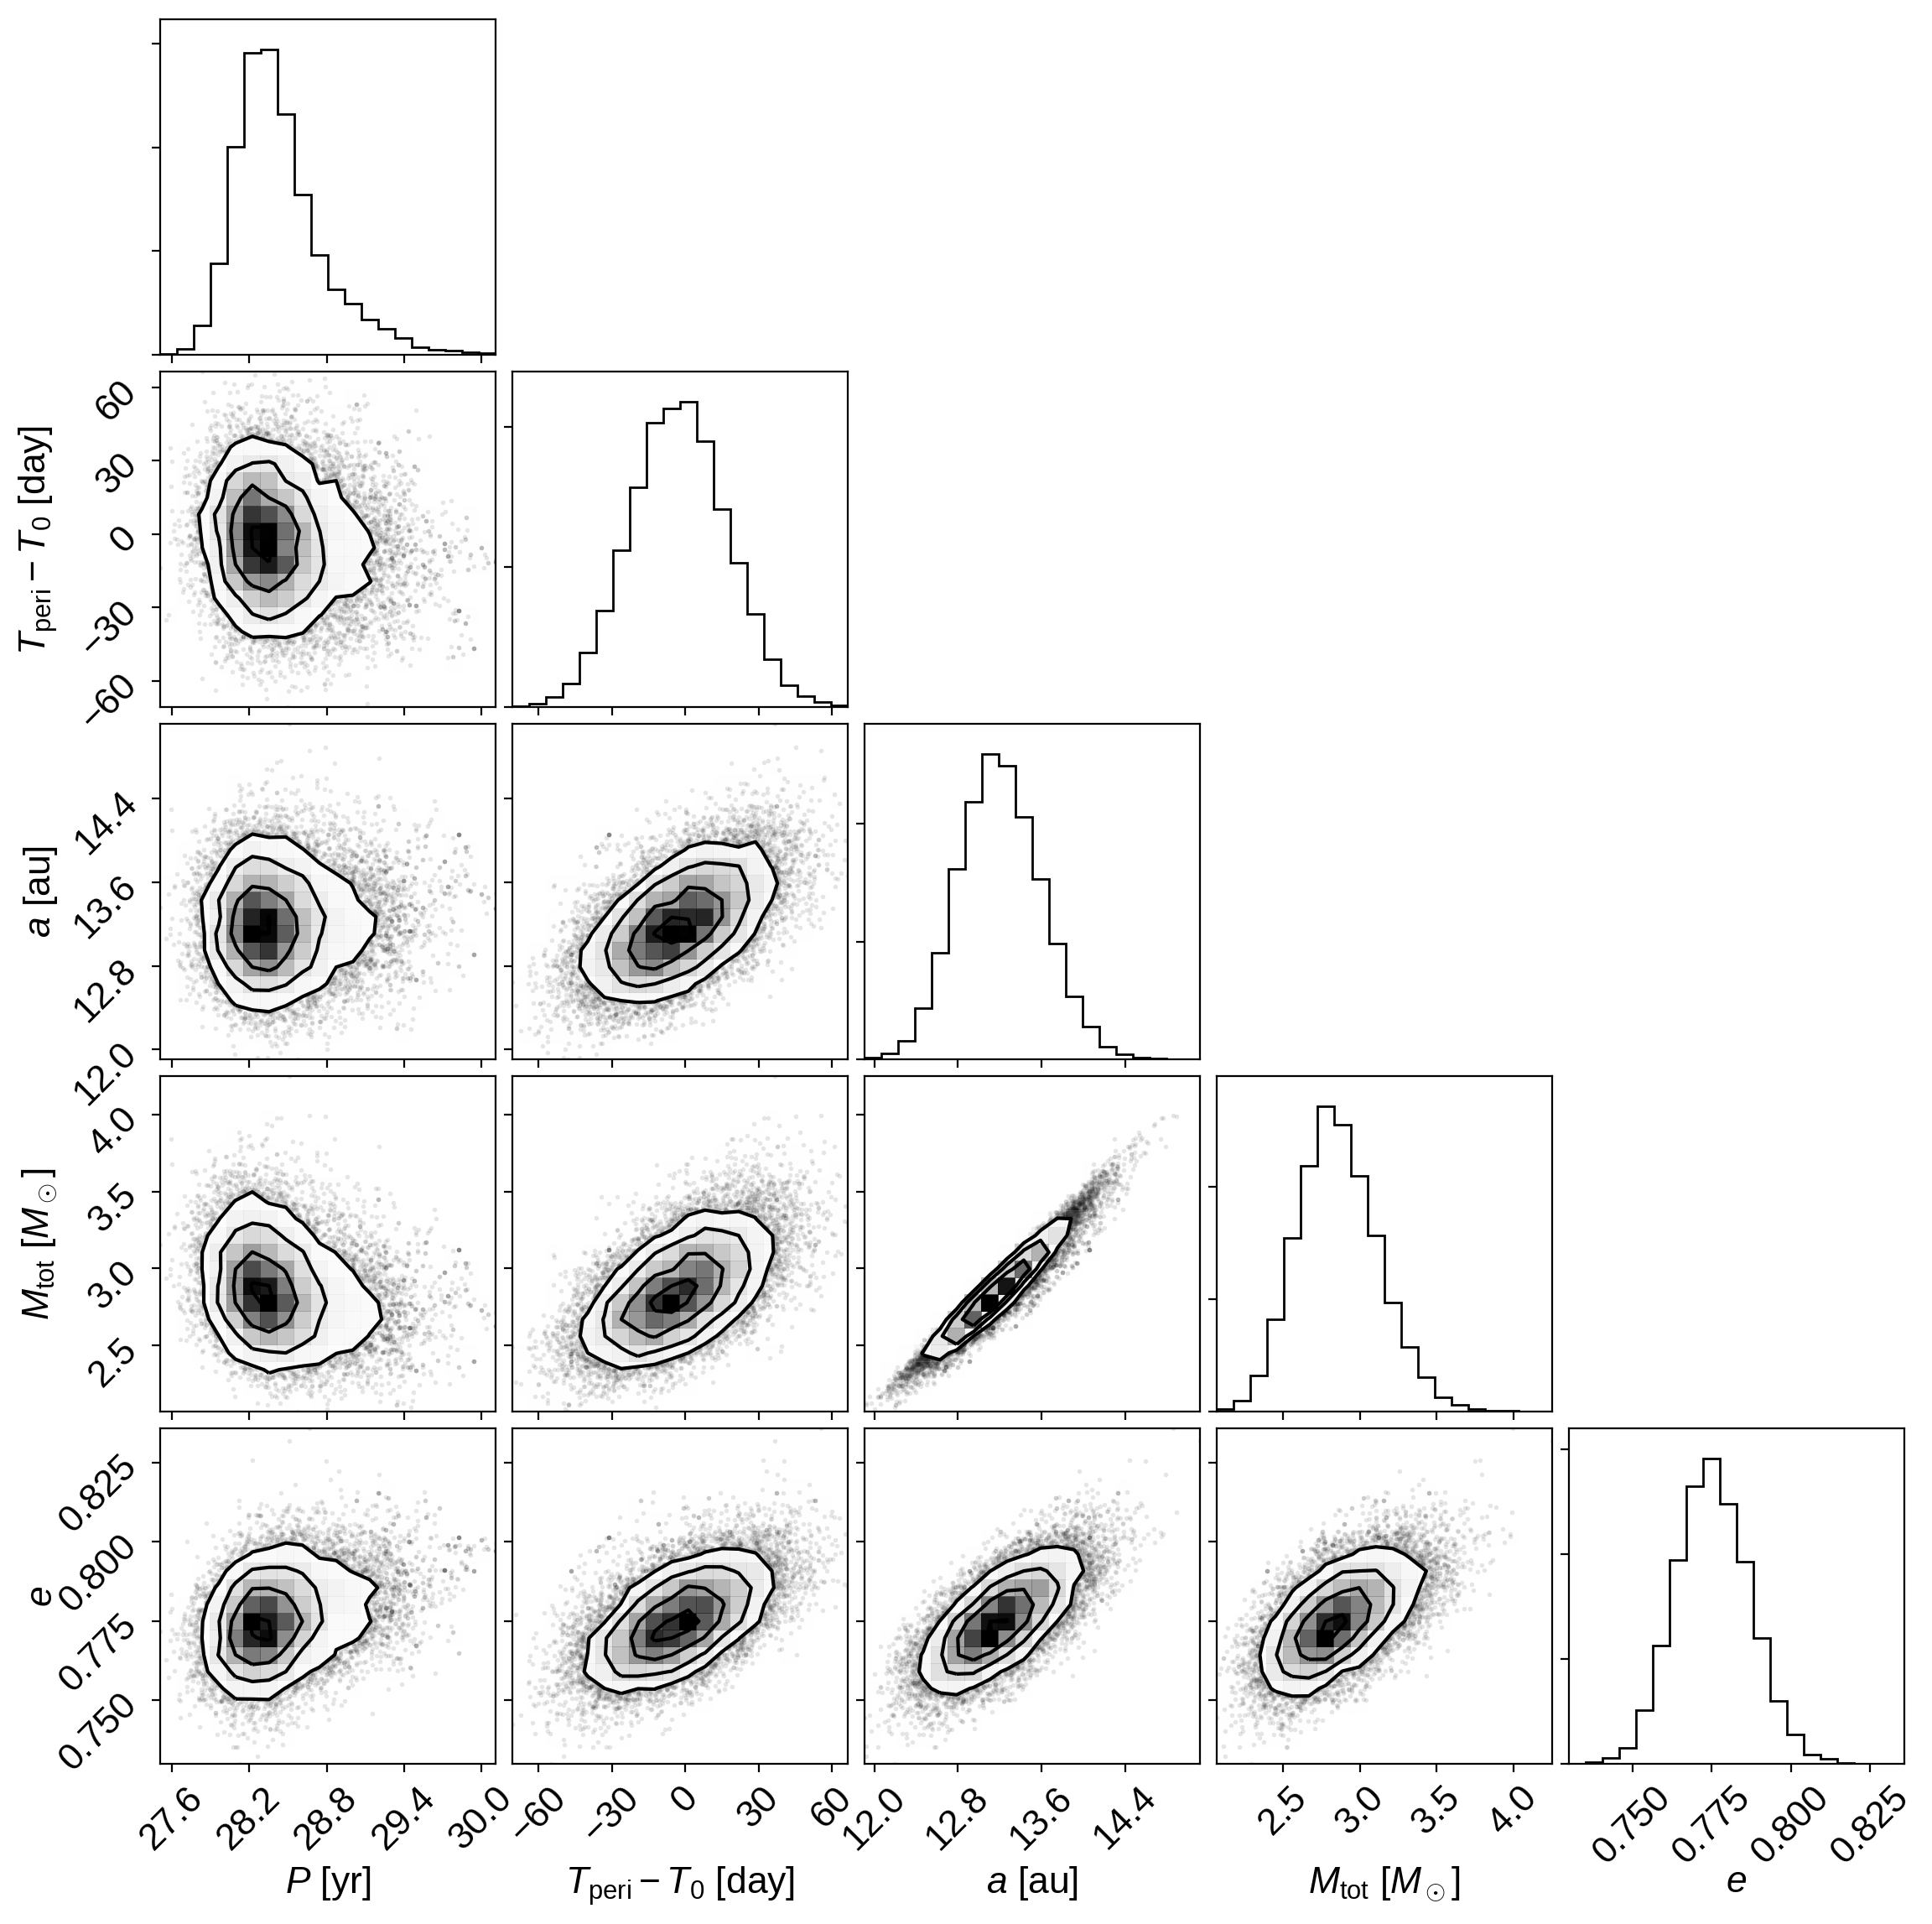

In [17]:
samples = pm.trace_to_dataframe(plx_trace, varnames=["ecc"])
samples["$P$ [yr]"] = plx_trace["P"] / yr
samples["$T_\mathrm{peri} - T_0$ [day]"] = plx_trace["tperi"] - T0
samples["$a$ [au]"] = plx_trace["a"]
samples["$M_\mathrm{tot}$ [$M_\odot$]"] = plx_trace["M_tot"]
samples["$e$"] = plx_trace["ecc"]
del samples["ecc"]
corner.corner(samples);

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [18]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:pymc3, exoplanet:theano}.


In [19]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.6},
   month = apr,
    year = 2019,
     doi = {10.5281/zenodo.2651251},
     url = {https://doi.org/10.5281/zenodo.2651251}
...
